# **CS-419 Deep Learning**

# **Semester Project**

## **Comparative Analysis of Classical and Quantum Deep Learning Approaches for Wildfire Detection**

## **Members:**

### ***Muhammad Furqan Raza (460535)***

### ***Tamkeen Sara (474585)***

# **INSTALL & IMPORT LIBRARIES**

In [ ]:
!pip install -q google-auth google-auth-oauthlib google-auth-httplib2 google-api-python-client

# Install PennyLane and the GPU plugin for Quantum Machine Learning
!pip install pennylane
!pip install pennylane-lightning[gpu]

# Install NVIDIA cuQuantum
!pip install cuquantum-python
!pip install pennylane pennylane-lightning

In [ ]:
import os
import io
import json
import shutil
import pickle
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from pathlib import Path
from PIL import Image
from tqdm import tqdm

# Computer vision libraries
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from datetime import datetime
import torchvision.models as models
import torchvision.transforms as transforms
from collections import defaultdict

# Google Drive API libraries
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload, MediaIoBaseDownload
from google.oauth2 import service_account
from google.auth import default
from google.oauth2.credentials import Credentials
from kaggle_secrets import UserSecretsClient
# Google Colab specific
from google.colab import drive, auth, files

# Quantum computing libraries
import pennylane as qml
from pennylane import numpy as np

# Set random seeds for reproducibility
random.seed(42)
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# **DATA PREPROCESSING**

## **LOAD & ANALYZE DATASETS**

In [5]:
def analyze_dataset(dataset_path, dataset_name):
    """Analyze and print dataset statistics"""
    fire_path = os.path.join(dataset_path, 'Fire')
    nofire_path = os.path.join(dataset_path, 'No_Fire')
    
    fire_count = len([f for f in os.listdir(fire_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    nofire_count = len([f for f in os.listdir(nofire_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    total = fire_count + nofire_count
    
    print(f"\n{'='*50}")
    print(f"{dataset_name} Dataset Statistics:")
    print(f"{'='*50}")
    print(f"Fire images: {fire_count} ({fire_count/total*100:.2f}%)")
    print(f"No_Fire images: {nofire_count} ({nofire_count/total*100:.2f}%)")
    print(f"Total images: {total}")
    print(f"Fire:No_Fire ratio = {fire_count/nofire_count:.2f}:1")
    
    return fire_count, nofire_count, total

# Analyze FLAME 1
flame1_fire, flame1_nofire, flame1_total = analyze_dataset('/kaggle/input/flame-1/FLAME 1', 'FLAME 1')

# Analyze FLAME 2
flame2_fire, flame2_nofire, flame2_total = analyze_dataset('/kaggle/input/flame-2/FLAME 2', 'FLAME 2')


FLAME 1 Dataset Statistics:
Fire images: 30155 (62.83%)
No_Fire images: 17837 (37.17%)
Total images: 47992
Fire:No_Fire ratio = 1.69:1

FLAME 2 Dataset Statistics:
Fire images: 39751 (74.37%)
No_Fire images: 13700 (25.63%)
Total images: 53451
Fire:No_Fire ratio = 2.90:1


## **ANALYZING CLASS IMBALANCE**

### **FLAME 2 BALANCING CALCULATION**

In [6]:
print(f"\n{'='*50}")
print("FLAME 2 BALANCING CALCULATION:")
print(f"{'='*50}")

# Target for FLAME 2: 60% Fire, 40% No_Fire
target_fire_percentage = 0.60
target_nofire_percentage = 0.40

# FLAME 2 Fire count stays the same
# Calculate needed No_Fire count for FLAME 2
flame2_target_total = int(flame2_fire / target_fire_percentage)
flame2_target_nofire = int(flame2_target_total * target_nofire_percentage)
flame2_augmentation_needed = flame2_target_nofire - flame2_nofire

print(f"FLAME 2 Current:")
print(f"  Fire: {flame2_fire} ({flame2_fire/flame2_total*100:.2f}%)")
print(f"  No_Fire: {flame2_nofire} ({flame2_nofire/flame2_total*100:.2f}%)")
print(f"\nFLAME 2 Target (60-40):")
print(f"  Fire: {flame2_fire} (stays same)")
print(f"  No_Fire: {flame2_target_nofire} (original {flame2_nofire} + {flame2_augmentation_needed} augmented)")
print(f"  Total: {flame2_target_total}")
print(f"\nAugmentations needed for FLAME 2: {flame2_augmentation_needed}")


FLAME 2 BALANCING CALCULATION:
FLAME 2 Current:
  Fire: 39751 (74.37%)
  No_Fire: 13700 (25.63%)

FLAME 2 Target (60-40):
  Fire: 39751 (stays same)
  No_Fire: 26500 (original 13700 + 12800 augmented)
  Total: 66251

Augmentations needed for FLAME 2: 12800


### **STATISTICS OF COMBINED DATASET AFTER HANDLING CLASS IMBALANCE**


In [7]:
print(f"\n{'='*50}")
print("FINAL COMBINED DATASET (After FLAME 2 Balancing):")
print(f"{'='*50}")

final_fire = flame1_fire + flame2_fire
final_nofire = flame1_nofire + flame2_target_nofire
final_total = final_fire + final_nofire

print(f"Fire images: {final_fire} ({final_fire/final_total*100:.2f}%)")
print(f"No_Fire images: {final_nofire} ({final_nofire/final_total*100:.2f}%)")
print(f"Total images: {final_total}")
print(f"Fire:No_Fire ratio = {final_fire/final_nofire:.2f}:1")


FINAL COMBINED DATASET (After FLAME 2 Balancing):
Fire images: 69906 (61.19%)
No_Fire images: 44337 (38.81%)
Total images: 114243
Fire:No_Fire ratio = 1.58:1


## **DATA AUGMENTATION FOR HANDLING CLASS IMBALANCE IN FLAME 2**

### **DATA AUGMENTATION FUNCTIONS**

In [8]:
def augment_image(image):
    """
    Apply random augmentation to an image.
    Ethical and conventional augmentations for fire detection.
    """
    augmentation_type = random.choice(['flip', 'rotate', 'brightness', 'noise', 'blur'])
    
    if augmentation_type == 'flip':
        # Horizontal flip
        if random.random() > 0.5:
            image = cv2.flip(image, 1)
        # Vertical flip
        else:
            image = cv2.flip(image, 0)
    
    elif augmentation_type == 'rotate':
        # Random rotation between -15 to 15 degrees
        angle = random.uniform(-15, 15)
        h, w = image.shape[:2]
        matrix = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
        image = cv2.warpAffine(image, matrix, (w, h), borderMode=cv2.BORDER_REFLECT)
    
    elif augmentation_type == 'brightness':
        # Adjust brightness
        factor = random.uniform(0.8, 1.2)
        image = cv2.convertScaleAbs(image, alpha=factor, beta=0)
    
    elif augmentation_type == 'noise':
        # Add Gaussian noise
        noise = np.random.normal(0, 10, image.shape).astype(np.uint8)
        image = cv2.add(image, noise)
    
    elif augmentation_type == 'blur':
        # Apply slight Gaussian blur
        kernel_size = random.choice([3, 5])
        image = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    
    return image

def advanced_augment_image(image):
    """
    Apply multiple augmentations for more variety.
    """
    # Apply 2-3 augmentations
    num_augs = random.randint(2, 3)
    
    for _ in range(num_augs):
        image = augment_image(image)
    
    return image

### **MAIN BALANCING FUNCTION FOR FLAME 2 (BY AUGMENTING NO_FIRE CLASS)**

In [9]:
def balance_flame2(flame2_path, output_path, augmentation_needed):
    """
    Balance FLAME 2 dataset by augmenting No_Fire class.
    """
    print(f"\n{'='*50}")
    print("BALANCING FLAME 2 DATASET:")
    print(f"{'='*50}")
    
    # Create output directories for balanced FLAME 2
    output_fire = os.path.join(output_path, 'Fire')
    output_nofire = os.path.join(output_path, 'No_Fire')
    os.makedirs(output_fire, exist_ok=True)
    os.makedirs(output_nofire, exist_ok=True)
    
    # Step 1: Copy all FLAME 2 Fire images (no changes)
    print("\nStep 1: Copying Fire images from FLAME 2...")
    flame2_fire_path = os.path.join(flame2_path, 'Fire')
    fire_files = [f for f in os.listdir(flame2_fire_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    for i, filename in enumerate(tqdm(fire_files)):
        src = os.path.join(flame2_fire_path, filename)
        dst = os.path.join(output_fire, f'FLAME2_Fire_{i:06d}.jpg')
        shutil.copy2(src, dst)
    
    # Step 2: Copy all original FLAME 2 No_Fire images
    print("\nStep 2: Copying original No_Fire images from FLAME 2...")
    flame2_nofire_path = os.path.join(flame2_path, 'No_Fire')
    nofire_files = [f for f in os.listdir(flame2_nofire_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    for i, filename in enumerate(tqdm(nofire_files)):
        src = os.path.join(flame2_nofire_path, filename)
        dst = os.path.join(output_nofire, f'FLAME2_NoFire_{i:06d}.jpg')
        shutil.copy2(src, dst)
    
    # Step 3: Augment FLAME 2 No_Fire images
    print(f"\nStep 3: Augmenting {augmentation_needed} No_Fire images for FLAME 2...")
    
    # Get all No_Fire image paths
    all_nofire_paths = [os.path.join(flame2_nofire_path, f) for f in nofire_files]
    
    # Calculate augmentations per image
    augmentations_per_image = augmentation_needed // len(all_nofire_paths) + 1
    print(f"Original FLAME 2 No_Fire images: {len(all_nofire_paths)}")
    print(f"Augmentations per image: ~{augmentations_per_image}")
    
    aug_counter = 0
    
    for aug_round in range(augmentations_per_image):
        if aug_counter >= augmentation_needed:
            break
        
        # Shuffle for variety
        random.shuffle(all_nofire_paths)
        
        for img_path in tqdm(all_nofire_paths, desc=f"Aug round {aug_round+1}"):
            if aug_counter >= augmentation_needed:
                break
            
            # Read image
            image = cv2.imread(img_path)
            if image is None:
                continue
            
            # Apply augmentation
            if aug_round == 0:
                augmented = augment_image(image)
            else:
                augmented = advanced_augment_image(image)
            
            # Save augmented image
            output_filename = f'FLAME2_AUG_NoFire_{aug_counter:06d}.jpg'
            output_path_img = os.path.join(output_nofire, output_filename)
            cv2.imwrite(output_path_img, augmented)
            
            aug_counter += 1
    
    print(f"\nFLAME 2 balancing complete! Generated {aug_counter} augmented No_Fire images.")
    
    # Verify FLAME 2 balance
    verify_fire = len([f for f in os.listdir(output_fire) if f.endswith('.jpg')])
    verify_nofire = len([f for f in os.listdir(output_nofire) if f.endswith('.jpg')])
    verify_total = verify_fire + verify_nofire
    
    print(f"\nBalanced FLAME 2 Statistics:")
    print(f"  Fire: {verify_fire} ({verify_fire/verify_total*100:.2f}%)")
    print(f"  No_Fire: {verify_nofire} ({verify_nofire/verify_total*100:.2f}%)")
    print(f"  Total: {verify_total}")

## **DATA INTEGRATION**

### **FUNCTION FOR INTEGRATION OF FLAME 1 AND BALANCED FLAME 2**

In [10]:
def combine_datasets(flame1_path, balanced_flame2_path, output_path):
    """
    Combine FLAME 1 (as-is) and balanced FLAME 2.
    """
    print(f"\n{'='*50}")
    print("COMBINING FLAME 1 AND BALANCED FLAME 2:")
    print(f"{'='*50}")
    
    # Create output directories
    output_fire = os.path.join(output_path, 'Fire')
    output_nofire = os.path.join(output_path, 'No_Fire')
    os.makedirs(output_fire, exist_ok=True)
    os.makedirs(output_nofire, exist_ok=True)
    
    # Copy FLAME 1 Fire images
    print("\nCopying FLAME 1 Fire images...")
    flame1_fire_path = os.path.join(flame1_path, 'Fire')
    fire_files = [f for f in os.listdir(flame1_fire_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    for i, filename in enumerate(tqdm(fire_files)):
        src = os.path.join(flame1_fire_path, filename)
        dst = os.path.join(output_fire, f'FLAME1_Fire_{i:06d}.jpg')
        shutil.copy2(src, dst)
    
    # Copy FLAME 1 No_Fire images
    print("\nCopying FLAME 1 No_Fire images...")
    flame1_nofire_path = os.path.join(flame1_path, 'No_Fire')
    nofire_files = [f for f in os.listdir(flame1_nofire_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    for i, filename in enumerate(tqdm(nofire_files)):
        src = os.path.join(flame1_nofire_path, filename)
        dst = os.path.join(output_nofire, f'FLAME1_NoFire_{i:06d}.jpg')
        shutil.copy2(src, dst)
    
    # Copy Balanced FLAME 2 Fire images
    print("\nCopying Balanced FLAME 2 Fire images...")
    flame2_fire_path = os.path.join(balanced_flame2_path, 'Fire')
    fire_files_2 = [f for f in os.listdir(flame2_fire_path) if f.endswith('.jpg')]
    
    for filename in tqdm(fire_files_2):
        src = os.path.join(flame2_fire_path, filename)
        dst = os.path.join(output_fire, filename)
        shutil.copy2(src, dst)
    
    # Copy Balanced FLAME 2 No_Fire images (including augmented)
    print("\nCopying Balanced FLAME 2 No_Fire images (including augmented)...")
    flame2_nofire_path = os.path.join(balanced_flame2_path, 'No_Fire')
    nofire_files_2 = [f for f in os.listdir(flame2_nofire_path) if f.endswith('.jpg')]
    
    for filename in tqdm(nofire_files_2):
        src = os.path.join(flame2_nofire_path, filename)
        dst = os.path.join(output_nofire, filename)
        shutil.copy2(src, dst)
    
    print("\nDataset combination complete!")

## **PERFORMING THE ACTUAL BALANCING VIA DATA AUGMENTATION, AND DATA INTEGRATION OF FLAME 1 & FLAME 2**

In [11]:
# Balance FLAME 2
balanced_flame2_path = '/kaggle/working/flame2_balanced'
balance_flame2(
    flame2_path='/kaggle/input/flame-2/FLAME 2',
    output_path=balanced_flame2_path,
    augmentation_needed=flame2_augmentation_needed
)

# Combine FLAME 1 and Balanced FLAME 2
final_dataset_path = '/kaggle/working/combined_balanced_dataset'
combine_datasets(
    flame1_path='/kaggle/input/flame-1/FLAME 1',
    balanced_flame2_path=balanced_flame2_path,
    output_path=final_dataset_path
)


BALANCING FLAME 2 DATASET:

Step 1: Copying Fire images from FLAME 2...


100%|██████████| 39751/39751 [08:06<00:00, 81.68it/s]



Step 2: Copying original No_Fire images from FLAME 2...


100%|██████████| 13700/13700 [02:48<00:00, 81.21it/s]



Step 3: Augmenting 12800 No_Fire images for FLAME 2...
Original FLAME 2 No_Fire images: 13700
Augmentations per image: ~1


Aug round 1:  93%|█████████▎| 12800/13700 [01:09<00:04, 183.53it/s]



FLAME 2 balancing complete! Generated 12800 augmented No_Fire images.

Balanced FLAME 2 Statistics:
  Fire: 39751 (60.00%)
  No_Fire: 26500 (40.00%)
  Total: 66251

COMBINING FLAME 1 AND BALANCED FLAME 2:

Copying FLAME 1 Fire images...


100%|██████████| 30155/30155 [05:58<00:00, 84.02it/s]



Copying FLAME 1 No_Fire images...


100%|██████████| 17837/17837 [03:47<00:00, 78.35it/s]



Copying Balanced FLAME 2 Fire images...


100%|██████████| 39751/39751 [00:08<00:00, 4536.14it/s]



Copying Balanced FLAME 2 No_Fire images (including augmented)...


100%|██████████| 26500/26500 [00:10<00:00, 2609.62it/s]


Dataset combination complete!


## **COMBINED DATASET VERIFICATION**

In [12]:
print(f"\n{'='*50}")
print("FINAL COMBINED DATASET VERIFICATION:")
print(f"{'='*50}")

final_fire, final_nofire, final_total = analyze_dataset(final_dataset_path, 'FINAL COMBINED')

print(f"\nFinal Fire:No_Fire ratio = {final_fire/final_nofire:.2f}:1")
print(f"Expected ratio: ~1.5:1 (60:40)")



FINAL COMBINED DATASET VERIFICATION:

FINAL COMBINED Dataset Statistics:
Fire images: 69906 (61.19%)
No_Fire images: 44337 (38.81%)
Total images: 114243
Fire:No_Fire ratio = 1.58:1

Final Fire:No_Fire ratio = 1.58:1
Expected ratio: ~1.5:1 (60:40)


## **AUGMENTATION SAMPLES VISUALIZATION**

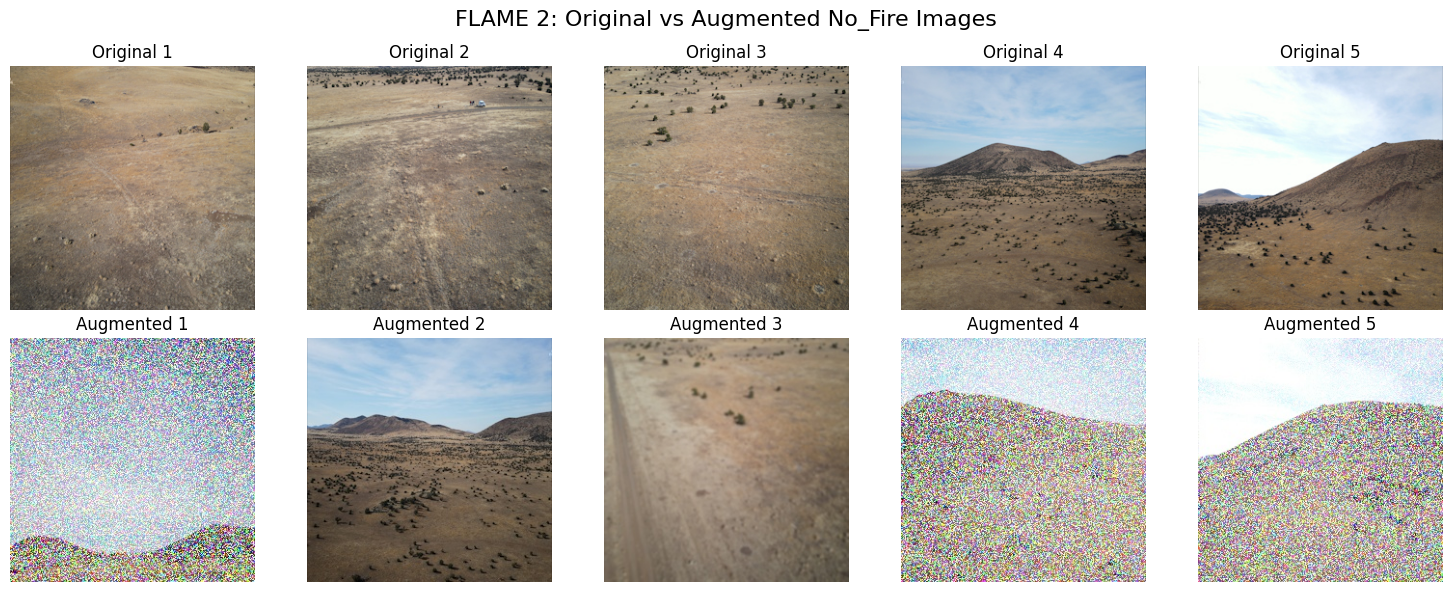

In [13]:
def visualize_flame2_augmentation(balanced_flame2_path, num_samples=5):
    """Visualize FLAME 2 original and augmented samples"""
    
    nofire_path = os.path.join(balanced_flame2_path, 'No_Fire')
    nofire_files = [f for f in os.listdir(nofire_path) if f.endswith('.jpg')]
    
    # Get original and augmented samples
    original_samples = [f for f in nofire_files if f.startswith('FLAME2_NoFire_')][:num_samples]
    augmented_samples = [f for f in nofire_files if f.startswith('FLAME2_AUG_')][:num_samples]
    
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    fig.suptitle('FLAME 2: Original vs Augmented No_Fire Images', fontsize=16)
    
    for i in range(num_samples):
        # Original
        if i < len(original_samples):
            img_orig = cv2.imread(os.path.join(nofire_path, original_samples[i]))
            img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
            axes[0, i].imshow(img_orig)
            axes[0, i].set_title(f'Original {i+1}')
            axes[0, i].axis('off')
        
        # Augmented
        if i < len(augmented_samples):
            img_aug = cv2.imread(os.path.join(nofire_path, augmented_samples[i]))
            img_aug = cv2.cvtColor(img_aug, cv2.COLOR_BGR2RGB)
            axes[1, i].imshow(img_aug)
            axes[1, i].set_title(f'Augmented {i+1}')
            axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/flame2_augmentation_samples.png', dpi=150, bbox_inches='tight')
    plt.show()

visualize_flame2_augmentation(balanced_flame2_path)

## **SUMMARY OF DATA AUGMENTATION & INTEGRATION**

In [14]:
print("\n" + "="*50)
print("PIPELINE COMPLETE!")
print("="*50)
print(f"Balanced FLAME 2 saved at: {balanced_flame2_path}")
print(f"Final combined dataset saved at: {final_dataset_path}")
print(f"Visualization saved at: /kaggle/working/flame2_augmentation_samples.png")
print("\nSummary:")
print(f"  1. FLAME 1: Used as-is (already balanced)")
print(f"  2. FLAME 2: Balanced from 75-25 to 60-40")
print(f"  3. Combined: {final_fire} Fire + {final_nofire} No_Fire = {final_total} total images")


PIPELINE COMPLETE!
Balanced FLAME 2 saved at: /kaggle/working/flame2_balanced
Final combined dataset saved at: /kaggle/working/combined_balanced_dataset
Visualization saved at: /kaggle/working/flame2_augmentation_samples.png

Summary:
  1. FLAME 1: Used as-is (already balanced)
  2. FLAME 2: Balanced from 75-25 to 60-40
  3. Combined: 69906 Fire + 44337 No_Fire = 114243 total images


## From now on, all the working will be done on the Combined Dataset.

## **COLLECT AND CATEGORIZE ALL IMAGES**

In [15]:
def collect_and_categorize_images(dataset_path):
    """
    Collect all images and categorize by dataset source and label.
    """
    print(f"\n{'='*50}")
    print("COLLECTING AND CATEGORIZING IMAGES:")
    print(f"{'='*50}")
    
    fire_path = os.path.join(dataset_path, 'Fire')
    nofire_path = os.path.join(dataset_path, 'No_Fire')
    
    # Dictionaries to store image paths
    flame1_fire = []
    flame1_nofire = []
    flame2_fire = []
    flame2_nofire = []
    
    # Collect Fire images
    print("\nCategorizing Fire images...")
    fire_files = [f for f in os.listdir(fire_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    for filename in tqdm(fire_files):
        img_path = os.path.join(fire_path, filename)
        
        if filename.startswith('FLAME1_'):
            flame1_fire.append(img_path)
        elif filename.startswith('FLAME2_'):
            flame2_fire.append(img_path)
    
    # Collect No_Fire images
    print("\nCategorizing No_Fire images...")
    nofire_files = [f for f in os.listdir(nofire_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    for filename in tqdm(nofire_files):
        img_path = os.path.join(nofire_path, filename)
        
        if filename.startswith('FLAME1_'):
            flame1_nofire.append(img_path)
        elif filename.startswith('FLAME2_'):
            flame2_nofire.append(img_path)
    
    # Shuffle all lists
    random.shuffle(flame1_fire)
    random.shuffle(flame1_nofire)
    random.shuffle(flame2_fire)
    random.shuffle(flame2_nofire)
    
    # Print statistics
    print(f"\n{'='*50}")
    print("CATEGORIZATION COMPLETE:")
    print(f"{'='*50}")
    print(f"FLAME 1 Fire: {len(flame1_fire)}")
    print(f"FLAME 1 No_Fire: {len(flame1_nofire)}")
    print(f"FLAME 2 Fire: {len(flame2_fire)}")
    print(f"FLAME 2 No_Fire: {len(flame2_nofire)}")
    print(f"Total: {len(flame1_fire) + len(flame1_nofire) + len(flame2_fire) + len(flame2_nofire)}")
    
    return {
        'flame1_fire': flame1_fire,
        'flame1_nofire': flame1_nofire,
        'flame2_fire': flame2_fire,
        'flame2_nofire': flame2_nofire
    }

## **NORMALIZATION**

### **FUNCTION FOR NORMALIZING AND SAVING THE DATASET**

In [ ]:
def normalize_and_save_image(img_path, kaggle_jpg_path, mean, std, base_name):
    """
    Save image to Kaggle (JPG only).
    NPY files will be generated on-the-fly during training.
    
    - Kaggle: JPG (local storage)
    """
    try:
        # Read image
        image = cv2.imread(img_path)
        if image is None:
            return False
        
        # SAVE TO KAGGLE (JPG)
        cv2.imwrite(kaggle_jpg_path, image)
        
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return False

### **SAVE IMAGES KAGGLE**

In [17]:
def save_images(image_list, kaggle_jpg_dir, mean, std, description):
    """
    Save images:
    - Kaggle: JPG only
    - NPY files generated on-the-fly during training
    """
    print(f"  Saving {description}: {len(image_list)} images")
    
    for idx, img_path in enumerate(tqdm(image_list, desc=description)):
        filename = os.path.basename(img_path)
        base_name = f'{idx:06d}_{filename[:-4]}'
        
        # Kaggle path
        kaggle_jpg_path = os.path.join(kaggle_jpg_dir, f'{base_name}.jpg')
        
        # Save to the specified location (JPG only)
        normalize_and_save_image(
            img_path, kaggle_jpg_path, mean, std, base_name
        )

# **SPLITTING DATASET**

## **CREATE STRATIFIED SPLITS WITH DUAL FORMAT**

In [ ]:
def create_stratified_splits(categorized_images, kaggle_output_path, mean, std):
    """
    Create train/validation/test splits:
    - Kaggle: JPG images only
    """
    print(f"\n{'='*60}")
    print("CREATING STRATIFIED SPLITS:")
    print(f"{'='*60}")
    print(f"Kaggle: JPG images only (local)")
    print(f"Drive: NPY + JPG images")
    print(f"{'='*60}")
    
    # Extract categorized images
    flame1_fire = categorized_images['flame1_fire']
    flame1_nofire = categorized_images['flame1_nofire']
    flame2_fire = categorized_images['flame2_fire']
    flame2_nofire = categorized_images['flame2_nofire']
    
    # SPLIT 1: TRAIN1 vs TEST
    print(f"\n{'='*50}")
    print("PHASE 1: Creating TRAIN1 and TEST splits")
    print(f"{'='*50}")
    
    # TRAIN1 allocation
    train1_flame1_fire_count = 24107
    train1_flame1_nofire_count = 14279
    train1_flame2_fire_count = 31805
    train1_flame2_nofire_count = 21203
    
    # Allocate images to train1
    train1_flame1_fire = flame1_fire[:train1_flame1_fire_count]
    train1_flame1_nofire = flame1_nofire[:train1_flame1_nofire_count]
    train1_flame2_fire = flame2_fire[:train1_flame2_fire_count]
    train1_flame2_nofire = flame2_nofire[:train1_flame2_nofire_count]
    
    # Remaining images go to test
    test_flame1_fire = flame1_fire[train1_flame1_fire_count:]
    test_flame1_nofire = flame1_nofire[train1_flame1_nofire_count:]
    test_flame2_fire = flame2_fire[train1_flame2_fire_count:]
    test_flame2_nofire = flame2_nofire[train1_flame2_nofire_count:]
    
    # Verify TRAIN1 counts
    print(f"\nTRAIN1 Split (91394 images):")
    print(f"  FLAME 1 Fire: {len(train1_flame1_fire)}")
    print(f"  FLAME 1 No_Fire: {len(train1_flame1_nofire)}")
    print(f"  FLAME 2 Fire: {len(train1_flame2_fire)}")
    print(f"  FLAME 2 No_Fire: {len(train1_flame2_nofire)}")
    train1_total = len(train1_flame1_fire) + len(train1_flame1_nofire) + len(train1_flame2_fire) + len(train1_flame2_nofire)
    print(f"  Total: {train1_total}")
    
    # Verify TEST counts
    print(f"\nTEST Split:")
    print(f"  FLAME 1 Fire: {len(test_flame1_fire)}")
    print(f"  FLAME 1 No_Fire: {len(test_flame1_nofire)}")
    print(f"  FLAME 2 Fire: {len(test_flame2_fire)}")
    print(f"  FLAME 2 No_Fire: {len(test_flame2_nofire)}")
    test_total = len(test_flame1_fire) + len(test_flame1_nofire) + len(test_flame2_fire) + len(test_flame2_nofire)
    print(f"  Total: {test_total}")
    
    # SPLIT 2: TRAIN vs VALIDATION (from TRAIN1)
    print(f"\n{'='*50}")
    print("PHASE 2: Creating TRAIN and VALIDATION splits from TRAIN1")
    print(f"{'='*50}")
    
    # TRAIN (final) allocation - 80% of train1
    train_flame1_fire_count = 19285
    train_flame1_nofire_count = 11423
    train_flame2_fire_count = 25444
    train_flame2_nofire_count = 16963
    
    # Allocate images to final train
    train_flame1_fire = train1_flame1_fire[:train_flame1_fire_count]
    train_flame1_nofire = train1_flame1_nofire[:train_flame1_nofire_count]
    train_flame2_fire = train1_flame2_fire[:train_flame2_fire_count]
    train_flame2_nofire = train1_flame2_nofire[:train_flame2_nofire_count]
    
    # Remaining from train1 go to validation
    val_flame1_fire = train1_flame1_fire[train_flame1_fire_count:]
    val_flame1_nofire = train1_flame1_nofire[train_flame1_nofire_count:]
    val_flame2_fire = train1_flame2_fire[train_flame2_fire_count:]
    val_flame2_nofire = train1_flame2_nofire[train_flame2_nofire_count:]
    
    # Verify TRAIN counts
    print(f"\nTRAIN Split (73115 images):")
    print(f"  FLAME 1 Fire: {len(train_flame1_fire)}")
    print(f"  FLAME 1 No_Fire: {len(train_flame1_nofire)}")
    print(f"  FLAME 2 Fire: {len(train_flame2_fire)}")
    print(f"  FLAME 2 No_Fire: {len(train_flame2_nofire)}")
    train_final_total = len(train_flame1_fire) + len(train_flame1_nofire) + len(train_flame2_fire) + len(train_flame2_nofire)
    print(f"  Total: {train_final_total}")
    
    # Verify VALIDATION counts
    print(f"\nVALIDATION Split (18279 images):")
    print(f"  FLAME 1 Fire: {len(val_flame1_fire)}")
    print(f"  FLAME 1 No_Fire: {len(val_flame1_nofire)}")
    print(f"  FLAME 2 Fire: {len(val_flame2_fire)}")
    print(f"  FLAME 2 No_Fire: {len(val_flame2_nofire)}")
    val_total = len(val_flame1_fire) + len(val_flame1_nofire) + len(val_flame2_fire) + len(val_flame2_nofire)
    print(f"  Total: {val_total}")

    # CREATE KAGGLE OUTPUT DIRECTORIES
    print(f"\n{'='*50}")
    print("Creating Kaggle output directories (JPG only)...")
    print(f"{'='*50}")
    
    kaggle_train_fire = os.path.join(kaggle_output_path, 'train', 'Fire')
    kaggle_train_nofire = os.path.join(kaggle_output_path, 'train', 'No_Fire')
    kaggle_val_fire = os.path.join(kaggle_output_path, 'validation', 'Fire')
    kaggle_val_nofire = os.path.join(kaggle_output_path, 'validation', 'No_Fire')
    kaggle_test_fire = os.path.join(kaggle_output_path, 'test', 'Fire')
    kaggle_test_nofire = os.path.join(kaggle_output_path, 'test', 'No_Fire')
    
    for path in [kaggle_train_fire, kaggle_train_nofire, kaggle_val_fire, 
                 kaggle_val_nofire, kaggle_test_fire, kaggle_test_nofire]:
        os.makedirs(path, exist_ok=True)
    
    print("Kaggle directories created!")
    
    # SAVE TRAIN SPLIT
    print(f"\n{'='*50}")
    print("Saving TRAIN split...")
    print(f"{'='*50}")
    
    train_all_fire = train_flame1_fire + train_flame2_fire
    random.shuffle(train_all_fire)
    save_images(
        train_all_fire, kaggle_train_fire,
        mean, std, "TRAIN Fire"
    )
    
    train_all_nofire = train_flame1_nofire + train_flame2_nofire
    random.shuffle(train_all_nofire)
    save_images(
        train_all_nofire, kaggle_train_nofire,
        mean, std, "TRAIN No_Fire"
    )
    
    # SAVE VALIDATION SPLIT
    print(f"\n{'='*50}")
    print("Saving VALIDATION split...")
    print(f"{'='*50}")
    
    val_all_fire = val_flame1_fire + val_flame2_fire
    random.shuffle(val_all_fire)
    save_images(
        val_all_fire, kaggle_val_fire,
        mean, std, "VALIDATION Fire"
    )
    
    val_all_nofire = val_flame1_nofire + val_flame2_nofire
    random.shuffle(val_all_nofire)
    save_images(
        val_all_nofire, kaggle_val_nofire,
        mean, std, "VALIDATION No_Fire"
    )
    
    # SAVE TEST SPLIT
    print(f"\n{'='*50}")
    print("Saving TEST split...")
    print(f"{'='*50}")
    
    test_all_fire = test_flame1_fire + test_flame2_fire
    random.shuffle(test_all_fire)
    save_images(
        test_all_fire, kaggle_test_fire,
        mean, std, "TEST Fire"
    )
    
    test_all_nofire = test_flame1_nofire + test_flame2_nofire
    random.shuffle(test_all_nofire)
    save_images(
        test_all_nofire, kaggle_test_nofire,
        mean, std, "TEST No_Fire"
    )
    
    print(f"\n{'='*50}")
    print("All splits saved successfully!")
    print(f"{'='*50}")

## **UTILITY FUNCTIONS FOR VISUALIZATION**

### **NORMALIZE IMAGE ON-THE-FLY**

In [35]:
def normalize_image_runtime(jpg_path, mean, std):
    """
    Load a JPG image and normalize it on-the-fly (like during training).
    Returns normalized image ready for visualization.
    """
    # Read image
    image = cv2.imread(jpg_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Normalize to [0, 1]
    image = image.astype(np.float32) / 255.0
    
    # Apply z-score normalization
    normalized_image = (image - mean) / std
    
    # Denormalize for visualization: reverse z-score normalization
    denormalized_img = (normalized_image * std) + mean
    
    # Clip to [0, 1] range
    denormalized_img = np.clip(denormalized_img, 0, 1)
    
    # Convert to uint8 for display
    display_img = (denormalized_img * 255).astype(np.uint8)
    
    return display_img

### **VISUALIZE SAMPLES FROM SPLIT**

In [36]:
def visualize_samples_from_split(jpg_dir, mean, std, num_samples=5, title="Samples"):
    """
    Visualize samples comparing original vs normalized (generated on-the-fly).
    No NPY files needed - normalizes JPG at runtime.
    
    Args:
        jpg_dir: Directory containing JPG images
        mean: Normalization mean values
        std: Normalization std values
        num_samples: Number of samples to visualize
        title: Plot title
    """
    jpg_files = [f for f in os.listdir(jpg_dir) if f.endswith('.jpg')][:num_samples]
    
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    fig.suptitle(title, fontsize=16)
    
    for i, jpg_file in enumerate(jpg_files):
        jpg_path = os.path.join(jpg_dir, jpg_file)
        
        # Load original image
        original_img = cv2.imread(jpg_path)
        original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
        
        # Generate normalized image (on-the-fly, like training does)
        normalized_img = normalize_image_runtime(jpg_path, mean, std)
        
        # Display original
        axes[0, i].imshow(original_img)
        axes[0, i].set_title(f'Original {i+1}')
        axes[0, i].axis('off')
        
        # Display normalized (after round-trip normalization)
        axes[1, i].imshow(normalized_img)
        axes[1, i].set_title(f'Normalized {i+1}')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    return fig

### **CREATE VISUALIZATION NOTEBOOK**

In [21]:
def create_visualization_notebook(kaggle_output_path, mean, std):
    """
    Create sample visualizations from all splits.
    Uses JPG files only - generates normalized versions on-the-fly.
    
    Args:
        kaggle_output_path: Path to Kaggle dataset (JPG images)
        mean: Normalization mean
        std: Normalization std
    """
    print(f"\n{'='*50}")
    print("CREATING VISUALIZATION SAMPLES:")
    print(f"{'='*50}")
    
    vis_output_dir = os.path.join(kaggle_output_path, 'visualizations')
    os.makedirs(vis_output_dir, exist_ok=True)
    
    # Visualize Train Fire
    print("\nCreating Train Fire visualization...")
    fig = visualize_samples_from_split(
        os.path.join(kaggle_output_path, 'train', 'Fire'),
        mean, std, num_samples=5, title="Train Set - Fire Images"
    )
    fig.savefig(os.path.join(vis_output_dir, 'train_fire_samples.png'), dpi=150, bbox_inches='tight')
    plt.close()
    
    # Visualize Train No_Fire
    print("Creating Train No_Fire visualization...")
    fig = visualize_samples_from_split(
        os.path.join(kaggle_output_path, 'train', 'No_Fire'),
        mean, std, num_samples=5, title="Train Set - No_Fire Images"
    )
    fig.savefig(os.path.join(vis_output_dir, 'train_nofire_samples.png'), dpi=150, bbox_inches='tight')
    plt.close()
    
    # Visualize Validation Fire
    print("Creating Validation Fire visualization...")
    fig = visualize_samples_from_split(
        os.path.join(kaggle_output_path, 'validation', 'Fire'),
        mean, std, num_samples=5, title="Validation Set - Fire Images"
    )
    fig.savefig(os.path.join(vis_output_dir, 'validation_fire_samples.png'), dpi=150, bbox_inches='tight')
    plt.close()
    
    # Visualize Test Fire
    print("Creating Test Fire visualization...")
    fig = visualize_samples_from_split(
        os.path.join(kaggle_output_path, 'test', 'Fire'),
        mean, std, num_samples=5, title="Test Set - Fire Images"
    )
    fig.savefig(os.path.join(vis_output_dir, 'test_fire_samples.png'), dpi=150, bbox_inches='tight')
    plt.close()
    
    # Visualize Test No_Fire
    print("Creating Test No_Fire visualization...")
    fig = visualize_samples_from_split(
        os.path.join(kaggle_output_path, 'test', 'No_Fire'),
        mean, std, num_samples=5, title="Test Set - No_Fire Images"
    )
    fig.savefig(os.path.join(vis_output_dir, 'test_nofire_samples.png'), dpi=150, bbox_inches='tight')
    plt.close()
    
    print(f"\nVisualizations saved at: {vis_output_dir}")

## **CREATE SUMMARY STATISTICS**

In [22]:
def create_summary_statistics(output_path):
    """
    Create summary statistics file for all splits.
    """
    print(f"\n{'='*50}")
    print("CREATING SUMMARY STATISTICS:")
    print(f"{'='*50}")
    
    summary = {}
    
    for split in ['train', 'validation', 'test']:
        npy_split_path = os.path.join(output_path, 'npy', split)
        
        if not os.path.exists(npy_split_path):
            continue
        
        fire_path = os.path.join(npy_split_path, 'Fire')
        nofire_path = os.path.join(npy_split_path, 'No_Fire')
        
        fire_count = len([f for f in os.listdir(fire_path) if f.endswith('.npy')])
        nofire_count = len([f for f in os.listdir(nofire_path) if f.endswith('.npy')])
        total = fire_count + nofire_count
        
        summary[split] = {
            'fire': fire_count,
            'nofire': nofire_count,
            'total': total
        }
    
    # Save summary as text file
    summary_file = os.path.join(output_path, 'dataset_summary.txt')
    with open(summary_file, 'w') as f:
        f.write("="*60 + "\n")
        f.write("FOREST FIRE DETECTION DATASET SUMMARY\n")
        f.write("Stratified Split with Dual Format (NPY + JPEG)\n")
        f.write("="*60 + "\n\n")
        f.write("STRUCTURE:\n")
        f.write("  npy/      - Normalized arrays for training (.npy format)\n")
        f.write("  images/   - Original images for visualization (.jpg format)\n")
        f.write("\n")
        
        total_all = 0
        for split, stats in summary.items():
            fire = stats['fire']
            nofire = stats['nofire']
            total = stats['total']
            total_all += total
            
            f.write(f"\n{split.upper()} SET:\n")
            f.write("-"*40 + "\n")
            f.write(f"Fire:     {fire:6d} ({fire/total*100:.2f}%)\n")
            f.write(f"No_Fire:  {nofire:6d} ({nofire/total*100:.2f}%)\n")
            f.write(f"{'='*40}\n")
            f.write(f"Total:    {total:6d}\n")
        
        f.write(f"\n{'='*60}\n")
        f.write(f"GRAND TOTAL: {total_all} images\n")
        f.write(f"{'='*60}\n")
        
        f.write("\n\nHOW TO USE:\n")
        f.write("-"*60 + "\n")
        f.write("For Training: Use files in npy/ directory\n")
        f.write("For Visualization: Use files in images/ directory\n")
        f.write("\nTo load NPY file:\n")
        f.write("  img = np.load('path/to/file.npy')  # Already normalized\n")
        f.write("\nTo visualize NPY file:\n")
        f.write("  img = load_and_visualize_npy('path/to/file.npy', mean, std)\n")
    
    print(f"\nSummary saved at: {summary_file}")
    
    # Print to console
    with open(summary_file, 'r') as f:
        print(f.read())
    
    return summary

## **COPY TO GOOGLE DRIVE**

### **MOUNT GOOGLE DRIVE FOR KAGGLE**

In [3]:
"""
GOOGLE DRIVE MOUNT AND HELPER FUNCTIONS
Using OAuth Method (token.pkl)
"""
def mount_google_drive_kaggle(token_path='/kaggle/input/token1/token.pkl'):
    """
    Mount Google Drive on Kaggle using OAuth token.
    
    Args:
        token_path: Path to the token.pkl file you uploaded to Kaggle
        
    Returns:
        drive_service: Google Drive service object
    """
    print(f"\n{'='*50}")
    print("MOUNTING GOOGLE DRIVE (KAGGLE):")
    print(f"{'='*50}")
    
    try:
        # Load the OAuth token
        print("Loading authentication token...")
        with open(token_path, 'rb') as f:
            creds = pickle.load(f)
        
        # Build Drive service
        drive_service = build('drive', 'v3', credentials=creds)
        
        # Test the connection by listing one file
        print("Testing connection...")
        results = drive_service.files().list(pageSize=1, fields="files(id, name)").execute()
        
        print("Google Drive mounted successfully via OAuth!")
        print(f"Full read/write access enabled")
        return drive_service
        
    except FileNotFoundError:
        print(f"Error: Token file not found at {token_path}")
        print("\nPlease ensure you have:")
        print("1. Generated token.pkl on your local computer")
        print("2. Uploaded token.pkl to your Kaggle notebook")
        print("3. Adjusted the token_path parameter if needed")
        return None
        
    except Exception as e:
        print(f"Error mounting Google Drive: {e}")
        print("\nTroubleshooting:")
        print("- Check if token.pkl is properly uploaded")
        print("- Token might be expired - generate a new one")
        print("- Check the file path matches your upload location")
        return None

### **HELPER FUNCTIONS**

#### **LIST DRIVE FILES**

In [4]:
def list_drive_files(drive_service, max_files=10):
    """
    List files in Google Drive (for testing/debugging).
    
    Args:
        drive_service: Google Drive service object
        max_files: Maximum number of files to list
    """
    print(f"\n{'='*50}")
    print(f"LISTING FILES IN GOOGLE DRIVE (Max: {max_files}):")
    print(f"{'='*50}")
    
    try:
        results = drive_service.files().list(
            pageSize=max_files,
            fields="files(id, name, mimeType, createdTime)"
        ).execute()
        
        files = results.get('files', [])
        
        if not files:
            print("No files found in Drive")
        else:
            print(f"\nFound {len(files)} file(s):\n")
            for i, file in enumerate(files, 1):
                print(f"{i}. {file['name']}")
                print(f"   ID: {file['id']}")
                print(f"   Type: {file.get('mimeType', 'N/A')}\n")
                
        return files
        
    except Exception as e:
        print(f"Error listing files: {e}")
        return []

#### **FIND OR CREATE FOLDER**

In [5]:
def find_or_create_folder(drive_service, folder_name, parent_id=None):
    """
    Find or create a folder in Google Drive.
    
    Args:
        drive_service: Google Drive service object
        folder_name: Name of the folder to find/create
        parent_id: ID of parent folder (None for root)
        
    Returns:
        folder_id: ID of the found/created folder
    """
    try:
        # Search for existing folder
        query = f"name='{folder_name}' and mimeType='application/vnd.google-apps.folder' and trashed=false"
        if parent_id:
            query += f" and '{parent_id}' in parents"
        
        results = drive_service.files().list(
            q=query,
            spaces='drive',
            fields='files(id, name)'
        ).execute()
        
        items = results.get('files', [])
        
        if items:
            print(f"  Found existing folder: {folder_name}")
            return items[0]['id']
        else:
            # Create new folder
            file_metadata = {
                'name': folder_name,
                'mimeType': 'application/vnd.google-apps.folder'
            }
            if parent_id:
                file_metadata['parents'] = [parent_id]
            
            folder = drive_service.files().create(
                body=file_metadata,
                fields='id'
            ).execute()
            
            print(f"  Created folder: {folder_name}")
            return folder.get('id')
            
    except Exception as e:
        print(f"  Error with folder '{folder_name}': {e}")
        return None

#### **UPLOAD FILE TO DRIVE**

In [6]:
def upload_file_to_drive(drive_service, file_path, folder_id, file_name=None):
    """
    Upload a file to Google Drive.
    
    Args:
        drive_service: Google Drive service object
        file_path: Local path to the file to upload
        folder_id: ID of the destination folder
        file_name: Name for the file in Drive (default: same as local)
        
    Returns:
        file_id: ID of the uploaded file, or None if failed
    """
    if file_name is None:
        file_name = os.path.basename(file_path)
    
    try:
        # Check if file exists locally
        if not os.path.exists(file_path):
            print(f"  Local file not found: {file_path}")
            return None
        
        # Check if file already exists in Drive
        query = f"name='{file_name}' and '{folder_id}' in parents and trashed=false"
        results = drive_service.files().list(
            q=query,
            spaces='drive',
            fields='files(id)'
        ).execute()
        
        items = results.get('files', [])
        
        file_metadata = {'name': file_name, 'parents': [folder_id]}
        media = MediaFileUpload(file_path, resumable=True)
        
        if items:
            # Update existing file
            file = drive_service.files().update(
                fileId=items[0]['id'],
                media_body=media
            ).execute()
            print(f"  Updated: {file_name}")
        else:
            # Create new file
            file = drive_service.files().create(
                body=file_metadata,
                media_body=media,
                fields='id'
            ).execute()
            print(f"  Uploaded: {file_name}")
        
        return file.get('id')
    
    except Exception as e:
        print(f"  Error uploading {file_name}: {e}")
        return None

#### **DOWNLOAD FILE FROM DRIVE**

In [7]:
def download_file_from_drive(drive_service, file_id, destination_path):
    """
    Download a file from Google Drive.
    
    Args:
        drive_service: Google Drive service object
        file_id: ID of the file to download
        destination_path: Local path where file will be saved
        
    Returns:
        success: True if successful, False otherwise
    """
    try:
        request = drive_service.files().get_media(fileId=file_id)
        fh = io.BytesIO()
        downloader = MediaIoBaseDownload(fh, request)
        
        done = False
        while not done:
            status, done = downloader.next_chunk()
            # print(f"  Download progress: {int(status.progress() * 100)}%")
        
        # Save to file
        with open(destination_path, 'wb') as f:
            f.write(fh.getvalue())
        
        print(f"  Downloaded: {os.path.basename(destination_path)}")
        return True
        
    except Exception as e:
        print(f"  Error downloading file: {e}")
        return False

#### **FIND FILE ID BY PATH**

In [ ]:
def get_drive_id_by_path(drive_service, path_list):
    """
    Navigates through Drive folders to find the ID of the final item.
    Args:
        path_list: List of folder names leading to file ['Folder', 'Subfolder', 'File']
    """
    parent_id = 'root' # Start searching from root
    
    for name in path_list:
        query = f"name='{name}' and '{parent_id}' in parents and trashed=false"
        results = drive_service.files().list(q=query, fields="files(id, name, mimeType)").execute()
        files = results.get('files', [])
        
        if not files:
            print(f" Error: Could not find '{name}' inside parent '{parent_id}'")
            return None
        
        # Update parent_id to look inside this folder next
        parent_id = files[0]['id']
        found_name = files[0]['name']
    
    return parent_id

#### **CREATE DRIVE FOLDER STRUCTURE**

In [8]:
def create_drive_folder_structure(drive_service, base_folder_name):
    """
    Create the complete folder structure in Google Drive.
    
    Args:
        drive_service: Google Drive service object
        base_folder_name: Name of the base/root folder
        
    Returns:
        folder_dict: Dictionary containing all folder IDs
    """
    print(f"\n{'='*50}")
    print(f"CREATING FOLDER STRUCTURE IN GOOGLE DRIVE:")
    print(f"{'='*50}\n")
    
    try:
        # Create base folder
        print(f"Creating base folder: {base_folder_name}")
        base_folder_id = find_or_create_folder(drive_service, base_folder_name)
        
        if not base_folder_id:
            print("Failed to create base folder")
            return None
        
        # Create data folder
        print(f"\nCreating data folder...")
        data_folder_id = find_or_create_folder(drive_service, 'data', base_folder_id)
        
        
        print(f"\n{'='*50}")
        print("FOLDER STRUCTURE CREATED SUCCESSFULLY!")
        print(f"{'='*50}\n")
        
        folder_dict = {
            'base': base_folder_id,
            'data': data_folder_id,
        }
        
        # Print folder structure summary
        print("Folder Structure:")
        print(f"└── {base_folder_name}/")
        print(f"    └── data/")

        return folder_dict
        
    except Exception as e:
        print(f"\nError creating folder structure: {e}")
        return None

#### **UPLOAD BATCH FILES**

In [9]:
def upload_batch_files(drive_service, file_list, folder_id, show_progress=True):
    """
    Upload multiple files to a Google Drive folder.
    
    Args:
        drive_service: Google Drive service object
        file_list: List of file paths to upload
        folder_id: Destination folder ID
        show_progress: Whether to show progress messages
        
    Returns:
        uploaded_count: Number of successfully uploaded files
    """
    uploaded_count = 0
    total_files = len(file_list)
    
    if show_progress:
        print(f"\nUploading {total_files} files...")
    
    for i, file_path in enumerate(file_list, 1):
        if show_progress and i % 10 == 0:
            print(f"  Progress: {i}/{total_files} files...")
        
        file_id = upload_file_to_drive(drive_service, file_path, folder_id)
        if file_id:
            uploaded_count += 1
    
    if show_progress:
        print(f"\nUpload complete: {uploaded_count}/{total_files} files uploaded successfully")
    
    return uploaded_count

## **EXECUTING THE SPLIT PIPELINE**

In [ ]:
# MAIN EXECUTION
print("="*60)
print("STRATIFIED DATASET CREATION PIPELINE")
print("Storage: Kaggle (JPG) + Google Drive (Model Checkpoints)")
print("="*60)

# Step 1: Mount Google Drive
drive_service = mount_google_drive_kaggle()

if drive_service is None:
    print("\nWARNING: Could not mount Google Drive!")
    print("Data will only be saved to Kaggle (JPG only)")
    response = input("Continue without Drive? (yes/no): ")
    if response.lower() != 'yes':
        print("Exiting...")
        exit()

# Step 2: Create folder structure in Drive
drive_folders = None
if drive_service:
    drive_folders = create_drive_folder_structure(
        drive_service, 
        'Deep Learning Semester Project'
    )

# Paths
combined_dataset_path = '/kaggle/working/combined_balanced_dataset'
kaggle_output_path = '/kaggle/working/final_dataset'

# Step 3: Calculate normalization parameters
print(f"\n{'='*50}")
print("Calculating normalization parameters...")
print(f"{'='*50}")

def calculate_mean_std(dataset_path):
    """Calculate mean and std from the combined dataset"""
    fire_path = os.path.join(dataset_path, 'Fire')
    nofire_path = os.path.join(dataset_path, 'No_Fire')
    
    fire_images = [os.path.join(fire_path, f) for f in os.listdir(fire_path) 
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    nofire_images = [os.path.join(nofire_path, f) for f in os.listdir(nofire_path) 
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    all_images = fire_images + nofire_images
    sample_images = random.sample(all_images, min(10000, len(all_images)))
    
    pixel_sum = np.zeros(3, dtype=np.float64)
    pixel_sum_squared = np.zeros(3, dtype=np.float64)
    pixel_count = 0
    
    print(f"Processing {len(sample_images)} images to calculate mean and std...")
    for img_path in tqdm(sample_images):
        image = cv2.imread(img_path)
        if image is None:
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype(np.float32) / 255.0
        
        pixel_sum += np.sum(image, axis=(0, 1))
        pixel_sum_squared += np.sum(image ** 2, axis=(0, 1))
        pixel_count += image.shape[0] * image.shape[1]
    
    mean = pixel_sum / pixel_count
    std = np.sqrt((pixel_sum_squared / pixel_count) - (mean ** 2))
    
    return mean, std

mean, std = calculate_mean_std(combined_dataset_path)

print(f"Mean (R, G, B): [{mean[0]:.4f}, {mean[1]:.4f}, {mean[2]:.4f}]")
print(f"Std  (R, G, B): [{std[0]:.4f}, {std[1]:.4f}, {std[2]:.4f}]")

# Save normalization params to Kaggle
os.makedirs(kaggle_output_path, exist_ok=True)
np.save(os.path.join(kaggle_output_path, 'mean.npy'), mean)
np.save(os.path.join(kaggle_output_path, 'std.npy'), std)

# Upload normalization params to Drive
if drive_service and drive_folders:
    print("\nUploading normalization parameters to Drive...")
    upload_file_to_drive(
        drive_service,
        os.path.join(kaggle_output_path, 'mean.npy'),
        drive_folders['data'],
        'mean.npy'
    )
    upload_file_to_drive(
        drive_service,
        os.path.join(kaggle_output_path, 'std.npy'),
        drive_folders['data'],
        'std.npy'
    )

# Step 4: Collect and categorize all images
categorized_images = collect_and_categorize_images(combined_dataset_path)

# Step 5: Create stratified splits
create_stratified_splits(
    categorized_images, 
    kaggle_output_path,  
    mean, 
    std
)

# Step 6: Create visualizations
create_visualization_notebook(kaggle_output_path, mean, std)

# Step 7: Create summary statistics
print(f"\n{'='*50}")
print("Creating summary...")
print(f"{'='*50}")

summary = {}
for split in ['train', 'validation', 'test']:
    kaggle_split_path = os.path.join(kaggle_output_path, split)
    
    fire_path = os.path.join(kaggle_split_path, 'Fire')
    nofire_path = os.path.join(kaggle_split_path, 'No_Fire')
    
    fire_count = len([f for f in os.listdir(fire_path) if f.endswith('.jpg')])
    nofire_count = len([f for f in os.listdir(nofire_path) if f.endswith('.jpg')])
    
    summary[split] = {
        'fire': fire_count,
        'nofire': nofire_count,
        'total': fire_count + nofire_count
    }

# Save summary
summary_file = os.path.join(kaggle_output_path, 'dataset_summary.txt')
with open(summary_file, 'w') as f:
    f.write("="*60 + "\n")
    f.write("FOREST FIRE DETECTION DATASET SUMMARY\n")
    f.write("="*60 + "\n")
    f.write("STORAGE:\n")
    f.write("  Kaggle: JPG images only\n")
    f.write("  Google Drive: NPY (normalized) + JPG (original)\n\n")
    
    for split, stats in summary.items():
        f.write(f"\n{split.upper()}:\n")
        f.write(f"  Fire: {stats['fire']}\n")
        f.write(f"  No_Fire: {stats['nofire']}\n")
        f.write(f"  Total: {stats['total']}\n")

print("\n" + "="*60)
print("PIPELINE COMPLETE!")
print("="*60)
print(f"\nKaggle storage: {kaggle_output_path}/ (JPG only)")
print(f"Drive storage: Deep Learning Semester Project/data")
print("="*60)

STRATIFIED DATASET CREATION PIPELINE
Storage: Kaggle (JPG) + Google Drive (Model Checkpoints)

MOUNTING GOOGLE DRIVE (KAGGLE):
Loading authentication token...
Testing connection...
Google Drive mounted successfully via OAuth!
Full read/write access enabled

CREATING FOLDER STRUCTURE IN GOOGLE DRIVE:

Creating base folder: Deep Learning Semester Project
  ✓ Found existing folder: Deep Learning Semester Project

Creating data folder...
  ✓ Found existing folder: data

FOLDER STRUCTURE CREATED SUCCESSFULLY!

Folder Structure:
└── Deep Learning Semester Project/
    └── data/

Calculating normalization parameters...
Processing 10000 images to calculate mean and std...


100%|██████████| 10000/10000 [00:33<00:00, 299.86it/s]


Mean (R, G, B): [0.4744, 0.4802, 0.4669]
Std  (R, G, B): [0.2164, 0.2204, 0.2402]

Uploading normalization parameters to Drive...
  ✓ Updated: mean.npy
  ✓ Updated: std.npy

COLLECTING AND CATEGORIZING IMAGES:

Categorizing Fire images...


100%|██████████| 69906/69906 [00:00<00:00, 1004463.85it/s]



Categorizing No_Fire images...


100%|██████████| 44337/44337 [00:00<00:00, 992198.78it/s]



CATEGORIZATION COMPLETE:
FLAME 1 Fire: 30155
FLAME 1 No_Fire: 17837
FLAME 2 Fire: 39751
FLAME 2 No_Fire: 26500
Total: 114243

CREATING STRATIFIED SPLITS:
Kaggle: JPG images only (local)
Drive: NPY + JPG images

PHASE 1: Creating TRAIN1 and TEST splits

TRAIN1 Split (91394 images):
  FLAME 1 Fire: 24107
  FLAME 1 No_Fire: 14279
  FLAME 2 Fire: 31805
  FLAME 2 No_Fire: 21203
  Total: 91394

TEST Split:
  FLAME 1 Fire: 6048
  FLAME 1 No_Fire: 3558
  FLAME 2 Fire: 7946
  FLAME 2 No_Fire: 5297
  Total: 22849

PHASE 2: Creating TRAIN and VALIDATION splits from TRAIN1

TRAIN Split (73115 images):
  FLAME 1 Fire: 19285
  FLAME 1 No_Fire: 11423
  FLAME 2 Fire: 25444
  FLAME 2 No_Fire: 16963
  Total: 73115

VALIDATION Split (18279 images):
  FLAME 1 Fire: 4822
  FLAME 1 No_Fire: 2856
  FLAME 2 Fire: 6361
  FLAME 2 No_Fire: 4240
  Total: 18279

Creating Kaggle output directories (JPG only)...
Kaggle directories created!

Saving TRAIN split...
  Saving TRAIN Fire: 44729 images


TRAIN Fire: 100%|██████████| 44729/44729 [00:59<00:00, 754.33it/s]


  Saving TRAIN No_Fire: 28386 images


TRAIN No_Fire: 100%|██████████| 28386/28386 [00:32<00:00, 861.26it/s]



Saving VALIDATION split...
  Saving VALIDATION Fire: 11183 images


VALIDATION Fire: 100%|██████████| 11183/11183 [00:14<00:00, 754.54it/s]


  Saving VALIDATION No_Fire: 7096 images


VALIDATION No_Fire: 100%|██████████| 7096/7096 [00:11<00:00, 617.58it/s]



Saving TEST split...
  Saving TEST Fire: 13994 images


TEST Fire: 100%|██████████| 13994/13994 [00:18<00:00, 737.52it/s]


  Saving TEST No_Fire: 8855 images


TEST No_Fire: 100%|██████████| 8855/8855 [00:13<00:00, 664.77it/s]



All splits saved successfully!

CREATING VISUALIZATION SAMPLES:

Creating Train Fire visualization...
Creating Train No_Fire visualization...
Creating Validation Fire visualization...
Creating Test Fire visualization...
Creating Test No_Fire visualization...

Visualizations saved at: /kaggle/working/final_dataset/visualizations

Creating summary...

PIPELINE COMPLETE!

Kaggle storage: /kaggle/working/final_dataset/ (JPG only)
Drive storage: Deep Learning Semester Project/data


# **CLASSICAL DEEP LEARNING MODELS**

### **MOUNT GOOGLE DRIVE**

In [81]:
# Step 1: Mount Google Drive
print("\n" + "="*60)
print("STEP 1: MOUNTING GOOGLE DRIVE")
print("="*60)

drive_service = mount_google_drive_kaggle()

if drive_service is None:
    print("\nWARNING: Could not mount Google Drive!")
    print("Models will only be saved to Kaggle")
    response = input("Continue without Drive? (yes/no): ")
    if response.lower() != 'yes':
        print("Exiting...")
        exit()
else:
    print("Google Drive mounted successfully!")

# Step 2: Define paths
KAGGLE_DATA_PATH = '/kaggle/input/final-dataset/Final_Dataset'  # Where JPG images are stored
KAGGLE_MODELS_PATH = '/kaggle/working/models'
DRIVE_BASE_FOLDER_NAME = 'Deep Learning Semester Project'  # Base folder in Drive

# Create Kaggle directories
os.makedirs(KAGGLE_MODELS_PATH, exist_ok=True)
print(f"\nKaggle working directory created: {KAGGLE_MODELS_PATH}")


STEP 1: MOUNTING GOOGLE DRIVE

MOUNTING GOOGLE DRIVE (KAGGLE):
Loading authentication token...
Testing connection...
Google Drive mounted successfully via OAuth!
Full read/write access enabled
Google Drive mounted successfully!

Kaggle working directory created: /kaggle/working/models


## **PRETRAINED ALEXNET**

### **DATASET CLASS FOR TRANSFER LEARNING**

In [34]:
class FireDatasetTransferLearning(Dataset):
    """
    Dataset class for transfer learning with pre-trained models.
    Pre-trained models expect ImageNet preprocessing (mean and std).
    """
    def __init__(self, data_dir, split='train', use_imagenet_norm=True):
        """
        Args:
            data_dir: Path to the base data directory
            split: 'train', 'validation', or 'test'
            use_imagenet_norm: Use ImageNet normalization (required for pretrained models)
        """
        self.split = split
        self.use_imagenet_norm = use_imagenet_norm
        
        # ImageNet normalization parameters (required for pretrained models)
        self.imagenet_mean = np.array([0.485, 0.456, 0.406])
        self.imagenet_std = np.array([0.229, 0.224, 0.225])
        
        # Paths to Fire and No_Fire directories
        fire_dir = os.path.join(data_dir, split, 'Fire')
        nofire_dir = os.path.join(data_dir, split, 'No_Fire')
        
        # Get all file paths
        self.fire_files = sorted([os.path.join(fire_dir, f) 
                                  for f in os.listdir(fire_dir) if f.endswith('.jpg')])
        self.nofire_files = sorted([os.path.join(nofire_dir, f) 
                                    for f in os.listdir(nofire_dir) if f.endswith('.jpg')])
        
        # Combine and create labels
        self.image_files = self.fire_files + self.nofire_files
        self.labels = [1] * len(self.fire_files) + [0] * len(self.nofire_files)
        
        print(f"{split.capitalize()} dataset: {len(self.fire_files)} Fire, {len(self.nofire_files)} No_Fire")
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load JPG image
        image = cv2.imread(self.image_files[idx])
        
        # Convert BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Resize to 224x224 (required for pretrained AlexNet)
        image = cv2.resize(image, (224, 224))
        
        # Normalize to [0, 1]
        image = image.astype(np.float32) / 255.0
        
        # Apply ImageNet normalization (required for pretrained models)
        if self.use_imagenet_norm:
            image = (image - self.imagenet_mean) / self.imagenet_std
        
        label = self.labels[idx]
        
        # Convert to PyTorch tensor (HWC to CHW format)
        image = torch.FloatTensor(image).permute(2, 0, 1)
        label = torch.LongTensor([label])[0]
        
        return image, label

### **TRANSFER LEARNING ALEXNET MODEL**

In [35]:
class AlexNetTransferLearning(nn.Module):
    """
    AlexNet with transfer learning from ImageNet.
    """
    def __init__(self, num_classes=2, freeze_features=True):
        """
        Args:
            num_classes: Number of output classes
            freeze_features: If True, freeze feature extraction layers (faster training)
        """
        super(AlexNetTransferLearning, self).__init__()
        
        # Load pretrained AlexNet
        self.model = models.alexnet(pretrained=True)
        
        # Freeze feature extraction layers if specified
        if freeze_features:
            for param in self.model.features.parameters():
                param.requires_grad = False
            print("Feature extraction layers frozen (only classifier will be trained)")
        else:
            print("All layers will be fine-tuned")
        
        # Replace the last fully connected layer
        # Original: Linear(4096, 1000) for ImageNet
        # New: Linear(4096, 2) for Fire vs No_Fire
        num_features = self.model.classifier[6].in_features
        self.model.classifier[6] = nn.Linear(num_features, num_classes)
        
        print(f"Loaded pretrained AlexNet from ImageNet")
        print(f"Modified final layer: {num_features} -> {num_classes} classes")
        
    def forward(self, x):
        return self.model(x)
    
    def unfreeze_all_layers(self):
        """Unfreeze all layers for fine-tuning"""
        for param in self.parameters():
            param.requires_grad = True
        print("All layers unfrozen, full fine-tuning enabled")


### **TRAINING FUNCTIONS**

In [36]:
def train_epoch(model, train_loader, criterion, optimizer, device, epoch):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch} [Train]')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f'{running_loss/len(pbar):.4f}',
            'acc': f'{100*correct/total:.2f}%'
        })
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

def validate(model, val_loader, criterion, device, epoch):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc=f'Epoch {epoch} [Val]')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            pbar.set_postfix({
                'loss': f'{running_loss/len(pbar):.4f}',
                'acc': f'{100*correct/total:.2f}%'
            })
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc, all_preds, all_labels

### **CHECKPOINT MANAGER**

In [37]:
class CheckpointManager:
    """Manage model checkpoints with Google Drive API support"""
    def __init__(self, model_name, kaggle_dir, drive_service, drive_base_folder_name):
        self.model_name = model_name
        self.kaggle_dir = os.path.join(kaggle_dir, model_name)
        self.drive_service = drive_service
        
        # Create Kaggle directory
        os.makedirs(self.kaggle_dir, exist_ok=True)
        
        # Create Drive folder structure
        self.drive_folder_id = None
        if drive_service:
            print(f"\nSetting up Google Drive folders for {model_name}...")
            try:
                # Find or create base folder
                base_folder_id = find_or_create_folder(drive_service, drive_base_folder_name)
                
                # Find or create models folder
                models_folder_id = find_or_create_folder(drive_service, 'models', base_folder_id)
                
                # Find or create model-specific folder
                self.drive_folder_id = find_or_create_folder(drive_service, model_name, models_folder_id)
                
                print(f"Drive folder created: {drive_base_folder_name}/models/{model_name}/")
            except Exception as e:
                print(f"Warning: Could not create Drive folders: {e}")
                self.drive_folder_id = None
        
        self.best_val_acc = 0.0
    
    def save_checkpoint(self, epoch, model, optimizer, train_loss, train_acc, 
                       val_loss, val_acc, history, is_best=False):
        """Save checkpoint to Kaggle and upload to Google Drive"""
        
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'history': history,
            'best_val_acc': self.best_val_acc
        }
        
        # Save latest checkpoint locally
        latest_path = os.path.join(self.kaggle_dir, 'ALEXNET_latest_checkpoint.pth')
        torch.save(checkpoint, latest_path)
        print(f"Saved locally: {latest_path}")
        
        # Upload to Google Drive
        if self.drive_service and self.drive_folder_id:
            try:
                upload_file_to_drive(
                    self.drive_service, 
                    latest_path, 
                    self.drive_folder_id,
                    'ALEXNET_latest_checkpoint.pth'
                )
            except Exception as e:
                print(f"Warning: Could not upload to Drive: {e}")
        
        # Save best model
        if is_best:
            best_path = os.path.join(self.kaggle_dir, 'ALEXNET_best_model.pth')
            torch.save(checkpoint, best_path)
            print(f"New best model saved! Val Acc: {val_acc:.2f}%")
            
            # Upload best model to Drive
            if self.drive_service and self.drive_folder_id:
                try:
                    upload_file_to_drive(
                        self.drive_service,
                        best_path,
                        self.drive_folder_id,
                        'ALEXNET_best_model.pth'
                    )
                except Exception as e:
                    print(f"Warning: Could not upload best model to Drive: {e}")
        
        # Save epoch checkpoint every 5 epochs
        if epoch % 5 == 0:
            epoch_path = os.path.join(self.kaggle_dir, f'checkpoint_epoch_{epoch}.pth')
            torch.save(checkpoint, epoch_path)
            
            # Upload to Drive
            if self.drive_service and self.drive_folder_id:
                try:
                    upload_file_to_drive(
                        self.drive_service,
                        epoch_path,
                        self.drive_folder_id,
                        f'checkpoint_epoch_{epoch}.pth'
                    )
                except Exception as e:
                    print(f"Warning: Could not upload epoch checkpoint to Drive: {e}")
    
    def load_checkpoint(self, model, optimizer, checkpoint_type='latest'):
        """Load checkpoint from Kaggle local storage"""
        
        if checkpoint_type == 'latest':
            checkpoint_path = os.path.join(self.kaggle_dir, 'ALEXNET_latest_checkpoint.pth')
        elif checkpoint_type == 'best':
            checkpoint_path = os.path.join(self.kaggle_dir, 'ALEXNET_best_model.pth')
        else:
            checkpoint_path = os.path.join(self.kaggle_dir, f'checkpoint_epoch_{checkpoint_type}.pth')
        
        if os.path.exists(checkpoint_path):
            print(f"Loading checkpoint from: {checkpoint_path}")
            checkpoint = torch.load(checkpoint_path, map_location=device)
            
            model.load_state_dict(checkpoint['model_state_dict'])
            if optimizer:
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            
            self.best_val_acc = checkpoint.get('best_val_acc', 0.0)
            
            return checkpoint['epoch'], checkpoint.get('history', {})
        else:
            print(f"No checkpoint found at {checkpoint_path}")
            return 0, {}

### **TRAINING INTERRUPTION FUNCTION**

In [38]:
import signal
import sys

class TrainingInterruptHandler:
    """Handle graceful interruption of training"""
    
    def __init__(self):
        self.interrupted = False
        self.original_sigint_handler = None
        self.original_sigterm_handler = None
    
    def signal_handler(self, sig, frame):
        """Handle Ctrl+C (SIGINT) or termination signals"""
        if not self.interrupted:
            print("\n" + "="*60)
            print("   INTERRUPTION DETECTED!")
            print("="*60)
            print("\n  Training will stop gracefully after current epoch completes...")
            print("   • Current epoch will finish")
            print("   • Checkpoint will be saved")
            print("   • All data will be preserved")
            print("\n  To resume later, use: resume_from='latest'")
            print("\n  Please wait for current epoch to complete...")
            print("="*60 + "\n")
            
            self.interrupted = True
        else:
            print("\n   FORCE STOP requested!")
            print("   Training will stop immediately (may lose current epoch)")
            print("   Last saved checkpoint will still be available\n")
            sys.exit(0)
    
    def activate(self):
        """Activate the interrupt handler"""
        self.original_sigint_handler = signal.signal(signal.SIGINT, self.signal_handler)
        self.original_sigterm_handler = signal.signal(signal.SIGTERM, self.signal_handler)
        print("  Graceful interruption enabled (Press Ctrl+C to stop training safely)")
    
    def deactivate(self):
        """Restore original signal handlers"""
        if self.original_sigint_handler:
            signal.signal(signal.SIGINT, self.original_sigint_handler)
        if self.original_sigterm_handler:
            signal.signal(signal.SIGTERM, self.original_sigterm_handler)
    
    def check_interrupted(self):
        """Check if training was interrupted"""
        return self.interrupted


### **TRAINING PIPELINE WITH TWO-STAGE STRATEGY**

In [ ]:
def train_model_transfer_learning(model, train_loader, val_loader, num_epochs_frozen, 
                                   num_epochs_finetune, learning_rate_frozen, 
                                   learning_rate_finetune, checkpoint_manager, resume_from=None):
    """
    Two-stage transfer learning with graceful interruption support.
    
    Press Ctrl+C once: Gracefully stop after current epoch
    Press Ctrl+C twice: Force stop immediately
    """
    
    # Initialize interrupt handler
    interrupt_handler = TrainingInterruptHandler()
    interrupt_handler.activate()
    
    criterion = nn.CrossEntropyLoss()
    
    # Initialize history and start epoch
    start_epoch = 0
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'stage': []
    }
    
    # RESUME FROM CHECKPOINT
    if resume_from is not None:
        print(f"\n{'='*60}")
        print(f"RESUMING TRAINING FROM: {resume_from}")
        print(f"{'='*60}\n")
        
        temp_optimizer = optim.Adam(model.parameters(), lr=learning_rate_frozen)
        start_epoch, history = checkpoint_manager.load_checkpoint(
            model, temp_optimizer, resume_from
        )
        
        if start_epoch > 0:
            print(f"  Checkpoint loaded successfully!")
            print(f"  Resuming from epoch: {start_epoch}")
            print(f"  Previous best val acc: {checkpoint_manager.best_val_acc:.2f}%")
            print(f"  History length: {len(history['train_loss'])} epochs")
            
            if start_epoch < num_epochs_frozen:
                print(f"  Resuming in: Stage 1 (Frozen Features)")
            else:
                print(f"  Resuming in: Stage 2 (Fine-tuning)")
                model.unfreeze_all_layers()
        else:
            print(f"   Could not load checkpoint '{resume_from}'")
            print(f"  Starting fresh training instead...")
            start_epoch = 0
    
    print(f"\n{'='*60}")
    print(f"TRANSFER LEARNING STRATEGY:")
    print(f"{'='*60}")
    print(f"Stage 1: Train classifier only ({num_epochs_frozen} epochs)")
    print(f"  - Learning rate: {learning_rate_frozen}")
    print(f"  - Features: Frozen (pretrained)")
    print(f"\nStage 2: Fine-tune all layers ({num_epochs_finetune} epochs)")
    print(f"  - Learning rate: {learning_rate_finetune}")
    print(f"  - Features: Unfrozen")
    
    if start_epoch > 0:
        print(f"\n   Resuming from epoch {start_epoch + 1}")
    
    print(f"{'='*60}\n")
    
    # Flag to track if training was interrupted
    training_interrupted = False
    last_completed_epoch = start_epoch
    
    try:
        # STAGE 1: TRAIN CLASSIFIER ONLY
        if start_epoch < num_epochs_frozen:
            print(f"\n{'='*60}")
            print("STAGE 1: TRAINING CLASSIFIER (FROZEN FEATURES)")
            print(f"{'='*60}\n")
            
            optimizer_stage1 = optim.Adam(
                filter(lambda p: p.requires_grad, model.parameters()),
                lr=learning_rate_frozen
            )
            
            if start_epoch > 0 and resume_from is not None:
                temp_optimizer = optim.Adam(
                    filter(lambda p: p.requires_grad, model.parameters()),
                    lr=learning_rate_frozen
                )
                checkpoint_manager.load_checkpoint(model, temp_optimizer, resume_from)
                optimizer_stage1.load_state_dict(temp_optimizer.state_dict())
            
            scheduler_stage1 = optim.lr_scheduler.StepLR(optimizer_stage1, step_size=10, gamma=0.1)
            
            for _ in range(start_epoch):
                scheduler_stage1.step()
            
            for epoch in range(start_epoch, num_epochs_frozen):
                # Check for interruption before starting epoch
                if interrupt_handler.check_interrupted():
                    training_interrupted = True
                    break
                
                train_loss, train_acc = train_epoch(model, train_loader, criterion, 
                                                   optimizer_stage1, device, epoch+1)
                
                # Check for interruption after training (before validation)
                if interrupt_handler.check_interrupted():
                    print("\n   Interruption detected during training phase")
                    print("   Saving checkpoint with current training results...")
                    training_interrupted = True
                
                val_loss, val_acc, val_preds, val_labels = validate(model, val_loader, 
                                                                    criterion, device, epoch+1)
                
                scheduler_stage1.step()
                
                history['train_loss'].append(train_loss)
                history['train_acc'].append(train_acc)
                history['val_loss'].append(val_loss)
                history['val_acc'].append(val_acc)
                history['stage'].append('frozen')
                
                print(f"\n[Stage 1] Epoch {epoch+1}/{num_epochs_frozen} Summary:")
                print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
                print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
                print(f"  Learning Rate: {scheduler_stage1.get_last_lr()[0]:.6f}\n")
                
                is_best = val_acc > checkpoint_manager.best_val_acc
                if is_best:
                    checkpoint_manager.best_val_acc = val_acc
                
                checkpoint_manager.save_checkpoint(
                    epoch + 1, model, optimizer_stage1, train_loss, train_acc,
                    val_loss, val_acc, history, is_best=is_best
                )
                
                last_completed_epoch = epoch + 1
                
                # Break if interrupted
                if training_interrupted:
                    break
            
            start_epoch = num_epochs_frozen
        
        # STAGE 2: FINE-TUNE ALL LAYERS
        if not training_interrupted:
            print(f"\n{'='*60}")
            print("STAGE 2: FINE-TUNING ALL LAYERS (UNFROZEN FEATURES)")
            print(f"{'='*60}\n")
            
            model.unfreeze_all_layers()
            
            optimizer_stage2 = optim.Adam(model.parameters(), lr=learning_rate_finetune)
            
            if start_epoch >= num_epochs_frozen and resume_from is not None:
                temp_optimizer = optim.Adam(model.parameters(), lr=learning_rate_finetune)
                checkpoint_manager.load_checkpoint(model, temp_optimizer, resume_from)
                optimizer_stage2.load_state_dict(temp_optimizer.state_dict())
            
            scheduler_stage2 = optim.lr_scheduler.StepLR(optimizer_stage2, step_size=15, gamma=0.1)
            
            for _ in range(max(0, start_epoch - num_epochs_frozen)):
                scheduler_stage2.step()
            
            total_epochs = num_epochs_frozen + num_epochs_finetune
            stage2_start = max(start_epoch, num_epochs_frozen)
            
            for epoch in range(stage2_start, total_epochs):
                # Check for interruption before starting epoch
                if interrupt_handler.check_interrupted():
                    training_interrupted = True
                    break
                
                train_loss, train_acc = train_epoch(model, train_loader, criterion, 
                                                   optimizer_stage2, device, epoch + 1)
                
                # Check for interruption after training
                if interrupt_handler.check_interrupted():
                    print("\n   Interruption detected during training phase")
                    print("   Saving checkpoint with current training results...")
                    training_interrupted = True
                
                val_loss, val_acc, val_preds, val_labels = validate(model, val_loader, 
                                                                    criterion, device, epoch + 1)
                
                scheduler_stage2.step()
                
                history['train_loss'].append(train_loss)
                history['train_acc'].append(train_acc)
                history['val_loss'].append(val_loss)
                history['val_acc'].append(val_acc)
                history['stage'].append('finetune')
                
                stage2_epoch_num = epoch - num_epochs_frozen + 1
                print(f"\n[Stage 2] Epoch {stage2_epoch_num}/{num_epochs_finetune} Summary:")
                print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
                print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
                print(f"  Learning Rate: {scheduler_stage2.get_last_lr()[0]:.6f}\n")
                
                is_best = val_acc > checkpoint_manager.best_val_acc
                if is_best:
                    checkpoint_manager.best_val_acc = val_acc
                
                checkpoint_manager.save_checkpoint(
                    epoch + 1, model, optimizer_stage2, train_loss, train_acc,
                    val_loss, val_acc, history, is_best=is_best
                )
                
                last_completed_epoch = epoch + 1
                
                # Break if interrupted
                if training_interrupted:
                    break
    
    except Exception as e:
        print(f"\n{'='*60}")
        print("  UNEXPECTED ERROR OCCURRED!")
        print(f"{'='*60}")
        print(f"Error: {e}")
        print(f"\nLast completed epoch: {last_completed_epoch}")
        print("Checkpoint saved at last completed epoch")
        print("You can resume training using: resume_from='latest'")
        print(f"{'='*60}\n")
        training_interrupted = True
        raise
    
    finally:
        # Deactivate interrupt handler
        interrupt_handler.deactivate()
        
        # Print final message
        if training_interrupted:
            print(f"\n{'='*60}")
            print("  TRAINING STOPPED GRACEFULLY")
            print(f"{'='*60}")
            print(f"\n  PROGRESS:")
            print(f"  Last completed epoch: {last_completed_epoch}")
            print(f"  Total epochs completed: {len(history['train_loss'])}")
            print(f"  Best validation accuracy: {checkpoint_manager.best_val_acc:.2f}%")
            
            print(f"\n  CHECKPOINT SAVED:")
            print(f"  Latest checkpoint at epoch {last_completed_epoch}")
            print(f"  All progress has been saved")
            
            print(f"\n   TO RESUME TRAINING:")
            print(f"  Set: resume_from='latest'")
            print(f"  Training will continue from epoch {last_completed_epoch + 1}")
            
            print(f"\n{'='*60}\n")
        else:
            print(f"\n{'='*60}")
            print("  TRAINING COMPLETED SUCCESSFULLY!")
            print(f"{'='*60}\n")
    
    return history

### **VISUALIZATION**

In [40]:
def plot_training_history_transfer_learning(history, save_path):
    """Plot training history with stage markers"""
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Mark stage transition
    stage1_epochs = sum(1 for s in history['stage'] if s == 'frozen')
    
    # Loss plot
    axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
    axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
    axes[0].axvline(x=stage1_epochs-0.5, color='red', linestyle='--', label='Stage 1→2')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # Accuracy plot
    axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
    axes[1].plot(history['val_acc'], label='Val Acc', marker='s')
    axes[1].axvline(x=stage1_epochs-0.5, color='red', linestyle='--', label='Stage 1→2')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True)
    
    # Add stage labels
    axes[0].text(stage1_epochs/2, axes[0].get_ylim()[1]*0.95, 'Stage 1: Frozen', 
                ha='center', va='top', fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    axes[0].text(stage1_epochs + (len(history['train_loss'])-stage1_epochs)/2, axes[0].get_ylim()[1]*0.95, 
                'Stage 2: Fine-tune', ha='center', va='top', fontsize=10, 
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Training history plot saved to: {save_path}")

def save_training_config(config, save_path):
    """Save training configuration"""
    with open(save_path, 'w') as f:
        json.dump(config, f, indent=2)
    print(f"Training config saved to: {save_path}")

### **MAIN EXECUTION**

In [ ]:
# Step 1: Training configuration
print("\n" + "="*60)
print("STEP 1: TRAINING CONFIGURATION")
print("="*60)

config = {
    'model_name': 'AlexNet_TransferLearning',
    'pretrained': True,
    'input_size': '224x224',  # Required for pretrained AlexNet
    'num_classes': 2,
    'batch_size': 32,
    'num_epochs_frozen': 10,  # Stage 1: Train classifier only
    'num_epochs_finetune': 20,  # Stage 2: Fine-tune all layers
    'learning_rate_frozen': 0.001,  # Higher LR for classifier training
    'learning_rate_finetune': 0.0001,  # Lower LR for fine-tuning
    'device': str(device),
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'normalization': 'ImageNet (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])'
}

print("\nTRANSFER LEARNING CONFIGURATION:")
for key, value in config.items():
    print(f"  {key}: {value}")
print("="*60)

# Step 2: Create datasets
print("\n" + "="*60)
print("STEP 2: LOADING DATASETS")
print("="*60)

print("\nLoading datasets with ImageNet normalization...")
train_dataset = FireDatasetTransferLearning(KAGGLE_DATA_PATH, split='train', use_imagenet_norm=True)
val_dataset = FireDatasetTransferLearning(KAGGLE_DATA_PATH, split='validation', use_imagenet_norm=True)

# Step 3: Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], 
                         shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], 
                       shuffle=False, num_workers=2, pin_memory=True)

print(f"\nDataloaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")

# Step 4: Create model
print("\n" + "="*60)
print("STEP 4: CREATING MODEL")
print("="*60)

model = AlexNetTransferLearning(num_classes=config['num_classes'], freeze_features=True)
model = model.to(device)

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())

print(f"\n  Model created and moved to {device}")
print(f"\nModel parameters:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters (Stage 1): {trainable_params:,}")
print(f"  Frozen parameters: {total_params - trainable_params:,}")

# Step 5: Create checkpoint manager with Drive API support
print("\n" + "="*60)
print("STEP 5: SETTING UP CHECKPOINT MANAGER")
print("="*60)

checkpoint_manager = CheckpointManager(
    model_name='AlexNet_TransferLearning',
    kaggle_dir=KAGGLE_MODELS_PATH,
    drive_service=drive_service,
    drive_base_folder_name=DRIVE_BASE_FOLDER_NAME
)

print(f"\n  Checkpoint manager initialized")
print(f"  Kaggle dir: {checkpoint_manager.kaggle_dir}")
if checkpoint_manager.drive_folder_id:
    print(f"  Drive folder ID: {checkpoint_manager.drive_folder_id}")
else:
    print(f"  Drive: Not connected (saving locally only)")

# Step 6: Save training configuration
print("\n" + "="*60)
print("STEP 6: SAVING TRAINING CONFIGURATION")
print("="*60)

config_save_path = os.path.join(checkpoint_manager.kaggle_dir, 'training_config.json')
save_training_config(config, config_save_path)

# Upload config to Drive
if drive_service and checkpoint_manager.drive_folder_id:
    try:
        upload_file_to_drive(
            drive_service,
            config_save_path,
            checkpoint_manager.drive_folder_id,
            'training_config.json'
        )
        print("  Configuration uploaded to Google Drive")
    except Exception as e:
        print(f"Warning: Could not upload config to Drive: {e}")

# Step 7: Train model
print("\n" + "="*60)
print("STEP 7: STARTING TRAINING")
print("="*60)

history = train_model_transfer_learning(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs_frozen=config['num_epochs_frozen'],
    num_epochs_finetune=config['num_epochs_finetune'],
    learning_rate_frozen=config['learning_rate_frozen'],
    learning_rate_finetune=config['learning_rate_finetune'],
    checkpoint_manager=checkpoint_manager,
    resume_from=None  # Set to 'latest', 'best', or epoch number to resume
)

# Step 8: Plot and save training history
print("\n" + "="*60)
print("STEP 8: SAVING TRAINING RESULTS")
print("="*60)

# Plot training history
plot_path = os.path.join(checkpoint_manager.kaggle_dir, 'training_history.png')
plot_training_history_transfer_learning(history, plot_path)

# Upload plot to Drive
if drive_service and checkpoint_manager.drive_folder_id:
    try:
        upload_file_to_drive(
            drive_service,
            plot_path,
            checkpoint_manager.drive_folder_id,
            'training_history.png'
        )
        print("  Training plot uploaded to Google Drive")
    except Exception as e:
        print(f"Warning: Could not upload plot to Drive: {e}")

# Save final history as JSON
history_path = os.path.join(checkpoint_manager.kaggle_dir, 'training_history.json')
with open(history_path, 'w') as f:
    json.dump(history, f, indent=2)
print(f"  Training history saved to: {history_path}")

# Upload history to Drive
if drive_service and checkpoint_manager.drive_folder_id:
    try:
        upload_file_to_drive(
            drive_service,
            history_path,
            checkpoint_manager.drive_folder_id,
            'training_history.json'
        )
        print("  Training history uploaded to Google Drive")
    except Exception as e:
        print(f"Warning: Could not upload history to Drive: {e}")


STEP 2: TRAINING CONFIGURATION

TRANSFER LEARNING CONFIGURATION:
  model_name: AlexNet_TransferLearning
  pretrained: True
  input_size: 224x224
  num_classes: 2
  batch_size: 32
  num_epochs_frozen: 10
  num_epochs_finetune: 20
  learning_rate_frozen: 0.001
  learning_rate_finetune: 0.0001
  device: cuda
  timestamp: 2025-11-28 18:59:26
  normalization: ImageNet (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

STEP 3: LOADING DATASETS

Loading datasets with ImageNet normalization...
Train dataset: 84860 Fire, 28386 No_Fire
Validation dataset: 11183 Fire, 7096 No_Fire

Dataloaders created:
  Train batches: 3539
  Validation batches: 572

STEP 4: CREATING MODEL
Feature extraction layers frozen (only classifier will be trained)
Loaded pretrained AlexNet from ImageNet
Modified final layer: 4096 -> 2 classes

  Model created and moved to cuda

Model parameters:
  Total parameters: 57,012,034
  Trainable parameters (Stage 1): 54,542,338
  Frozen parameters: 2,469,696

STEP 5: SETTI

Epoch 1 [Val]: 100%|██████████| 572/572 [01:02<00:00,  9.12it/s, loss=0.0218, acc=99.56%]



[Stage 1] Epoch 1/10 Summary:
  Train Loss: 0.0891 | Train Acc: 98.73%
  Val Loss: 0.0218 | Val Acc: 99.56%
  Learning Rate: 0.001000

Saved locally: /kaggle/working/models/AlexNet_TransferLearning/ALEXNET_latest_checkpoint.pth
  Updated: ALEXNET_latest_checkpoint.pth
New best model saved! Val Acc: 99.56%
  Updated: ALEXNET_best_model.pth


Epoch 2 [Val]: 100%|██████████| 572/572 [01:10<00:00,  8.17it/s, loss=0.1603, acc=98.75%] 



[Stage 1] Epoch 2/10 Summary:
  Train Loss: 0.0529 | Train Acc: 99.47%
  Val Loss: 0.1603 | Val Acc: 98.75%
  Learning Rate: 0.001000

Saved locally: /kaggle/working/models/AlexNet_TransferLearning/ALEXNET_latest_checkpoint.pth
  Updated: ALEXNET_latest_checkpoint.pth


Epoch 3 [Val]: 100%|██████████| 572/572 [01:03<00:00,  9.03it/s, loss=0.0159, acc=99.83%]



[Stage 1] Epoch 3/10 Summary:
  Train Loss: 0.0265 | Train Acc: 99.64%
  Val Loss: 0.0159 | Val Acc: 99.83%
  Learning Rate: 0.001000

Saved locally: /kaggle/working/models/AlexNet_TransferLearning/ALEXNET_latest_checkpoint.pth
  Updated: ALEXNET_latest_checkpoint.pth
New best model saved! Val Acc: 99.83%
  Updated: ALEXNET_best_model.pth


Epoch 4 [Val]: 100%|██████████| 572/572 [00:52<00:00, 10.93it/s, loss=0.0054, acc=99.87%]



[Stage 1] Epoch 4/10 Summary:
  Train Loss: 0.0285 | Train Acc: 99.70%
  Val Loss: 0.0054 | Val Acc: 99.87%
  Learning Rate: 0.001000

Saved locally: /kaggle/working/models/AlexNet_TransferLearning/ALEXNET_latest_checkpoint.pth
  Updated: ALEXNET_latest_checkpoint.pth
New best model saved! Val Acc: 99.87%
  Updated: ALEXNET_best_model.pth


Epoch 5 [Val]: 100%|██████████| 572/572 [00:52<00:00, 10.84it/s, loss=0.0113, acc=99.87%]



[Stage 1] Epoch 5/10 Summary:
  Train Loss: 0.0241 | Train Acc: 99.72%
  Val Loss: 0.0113 | Val Acc: 99.87%
  Learning Rate: 0.001000

Saved locally: /kaggle/working/models/AlexNet_TransferLearning/ALEXNET_latest_checkpoint.pth
  Updated: ALEXNET_latest_checkpoint.pth
  Uploaded: checkpoint_epoch_5.pth


Epoch 6 [Val]: 100%|██████████| 572/572 [00:52<00:00, 10.87it/s, loss=0.0272, acc=99.70%]



[Stage 1] Epoch 6/10 Summary:
  Train Loss: 0.0277 | Train Acc: 99.73%
  Val Loss: 0.0272 | Val Acc: 99.70%
  Learning Rate: 0.001000

Saved locally: /kaggle/working/models/AlexNet_TransferLearning/ALEXNET_latest_checkpoint.pth
  Updated: ALEXNET_latest_checkpoint.pth


Epoch 7 [Val]: 100%|██████████| 572/572 [00:56<00:00, 10.11it/s, loss=0.0113, acc=99.79%] 



[Stage 1] Epoch 7/10 Summary:
  Train Loss: 0.0167 | Train Acc: 99.78%
  Val Loss: 0.0113 | Val Acc: 99.79%
  Learning Rate: 0.001000

Saved locally: /kaggle/working/models/AlexNet_TransferLearning/ALEXNET_latest_checkpoint.pth
  Updated: ALEXNET_latest_checkpoint.pth


Epoch 8 [Val]: 100%|██████████| 572/572 [00:58<00:00,  9.80it/s, loss=0.0399, acc=99.70%] 



[Stage 1] Epoch 8/10 Summary:
  Train Loss: 0.0182 | Train Acc: 99.80%
  Val Loss: 0.0399 | Val Acc: 99.70%
  Learning Rate: 0.001000

Saved locally: /kaggle/working/models/AlexNet_TransferLearning/ALEXNET_latest_checkpoint.pth
  Updated: ALEXNET_latest_checkpoint.pth


Epoch 9 [Val]: 100%|██████████| 572/572 [01:12<00:00,  7.91it/s, loss=0.0094, acc=99.84%]



[Stage 1] Epoch 9/10 Summary:
  Train Loss: 0.0250 | Train Acc: 99.78%
  Val Loss: 0.0094 | Val Acc: 99.84%
  Learning Rate: 0.001000

Saved locally: /kaggle/working/models/AlexNet_TransferLearning/ALEXNET_latest_checkpoint.pth
  Updated: ALEXNET_latest_checkpoint.pth


Epoch 10 [Val]: 100%|██████████| 572/572 [00:55<00:00, 10.27it/s, loss=0.0019, acc=99.91%] 



[Stage 1] Epoch 10/10 Summary:
  Train Loss: 0.0197 | Train Acc: 99.82%
  Val Loss: 0.0019 | Val Acc: 99.91%
  Learning Rate: 0.000100

Saved locally: /kaggle/working/models/AlexNet_TransferLearning/ALEXNET_latest_checkpoint.pth
  Updated: ALEXNET_latest_checkpoint.pth
New best model saved! Val Acc: 99.91%
  Updated: ALEXNET_best_model.pth
  Uploaded: checkpoint_epoch_10.pth

STAGE 2: FINE-TUNING ALL LAYERS (UNFROZEN FEATURES)

All layers unfrozen, full fine-tuning enabled


Epoch 11 [Val]: 100%|██████████| 572/572 [01:10<00:00,  8.15it/s, loss=0.0142, acc=99.49%] 



[Stage 2] Epoch 1/20 Summary:
  Train Loss: 0.0468 | Train Acc: 98.95%
  Val Loss: 0.0142 | Val Acc: 99.49%
  Learning Rate: 0.000100

Saved locally: /kaggle/working/models/AlexNet_TransferLearning/ALEXNET_latest_checkpoint.pth
  Updated: ALEXNET_latest_checkpoint.pth


Epoch 12 [Val]: 100%|██████████| 572/572 [01:12<00:00,  7.87it/s, loss=0.0088, acc=99.66%]



[Stage 2] Epoch 2/20 Summary:
  Train Loss: 0.0263 | Train Acc: 99.28%
  Val Loss: 0.0088 | Val Acc: 99.66%
  Learning Rate: 0.000100

Saved locally: /kaggle/working/models/AlexNet_TransferLearning/ALEXNET_latest_checkpoint.pth
  Updated: ALEXNET_latest_checkpoint.pth


Epoch 13 [Val]: 100%|██████████| 572/572 [00:58<00:00,  9.83it/s, loss=0.0489, acc=97.51%] 



[Stage 2] Epoch 3/20 Summary:
  Train Loss: 0.0134 | Train Acc: 99.62%
  Val Loss: 0.0489 | Val Acc: 97.51%
  Learning Rate: 0.000100

Saved locally: /kaggle/working/models/AlexNet_TransferLearning/ALEXNET_latest_checkpoint.pth
  Updated: ALEXNET_latest_checkpoint.pth


Epoch 14 [Val]: 100%|██████████| 572/572 [00:53<00:00, 10.78it/s, loss=0.0043, acc=99.84%]



[Stage 2] Epoch 4/20 Summary:
  Train Loss: 0.0323 | Train Acc: 99.25%
  Val Loss: 0.0043 | Val Acc: 99.84%
  Learning Rate: 0.000100

Saved locally: /kaggle/working/models/AlexNet_TransferLearning/ALEXNET_latest_checkpoint.pth
  Updated: ALEXNET_latest_checkpoint.pth


Epoch 15 [Val]: 100%|██████████| 572/572 [00:57<00:00,  9.87it/s, loss=0.0027, acc=99.93%]



[Stage 2] Epoch 5/20 Summary:
  Train Loss: 0.0058 | Train Acc: 99.82%
  Val Loss: 0.0027 | Val Acc: 99.93%
  Learning Rate: 0.000100

Saved locally: /kaggle/working/models/AlexNet_TransferLearning/ALEXNET_latest_checkpoint.pth
  Updated: ALEXNET_latest_checkpoint.pth
New best model saved! Val Acc: 99.93%
  Updated: ALEXNET_best_model.pth
  Uploaded: checkpoint_epoch_15.pth


Epoch 16 [Val]: 100%|██████████| 572/572 [00:52<00:00, 10.90it/s, loss=0.0067, acc=99.90%]



[Stage 2] Epoch 6/20 Summary:
  Train Loss: 0.0105 | Train Acc: 99.75%
  Val Loss: 0.0067 | Val Acc: 99.90%
  Learning Rate: 0.000100

Saved locally: /kaggle/working/models/AlexNet_TransferLearning/ALEXNET_latest_checkpoint.pth
  Updated: ALEXNET_latest_checkpoint.pth


Epoch 17 [Val]: 100%|██████████| 572/572 [00:52<00:00, 10.82it/s, loss=0.0046, acc=99.87%] 



[Stage 2] Epoch 7/20 Summary:
  Train Loss: 0.0150 | Train Acc: 99.66%
  Val Loss: 0.0046 | Val Acc: 99.87%
  Learning Rate: 0.000100

Saved locally: /kaggle/working/models/AlexNet_TransferLearning/ALEXNET_latest_checkpoint.pth
  Updated: ALEXNET_latest_checkpoint.pth


Epoch 18 [Val]: 100%|██████████| 572/572 [00:57<00:00, 10.01it/s, loss=0.0211, acc=99.22%] 



[Stage 2] Epoch 8/20 Summary:
  Train Loss: 0.0328 | Train Acc: 99.38%
  Val Loss: 0.0211 | Val Acc: 99.22%
  Learning Rate: 0.000100

Saved locally: /kaggle/working/models/AlexNet_TransferLearning/ALEXNET_latest_checkpoint.pth
  Updated: ALEXNET_latest_checkpoint.pth


Epoch 19 [Val]: 100%|██████████| 572/572 [00:53<00:00, 10.76it/s, loss=0.0029, acc=99.92%]



[Stage 2] Epoch 9/20 Summary:
  Train Loss: 0.0094 | Train Acc: 99.74%
  Val Loss: 0.0029 | Val Acc: 99.92%
  Learning Rate: 0.000100

Saved locally: /kaggle/working/models/AlexNet_TransferLearning/ALEXNET_latest_checkpoint.pth
  Updated: ALEXNET_latest_checkpoint.pth


Epoch 20 [Val]: 100%|██████████| 572/572 [00:52<00:00, 10.89it/s, loss=0.0032, acc=99.90%] 



[Stage 2] Epoch 10/20 Summary:
  Train Loss: 0.0068 | Train Acc: 99.86%
  Val Loss: 0.0032 | Val Acc: 99.90%
  Learning Rate: 0.000100

Saved locally: /kaggle/working/models/AlexNet_TransferLearning/ALEXNET_latest_checkpoint.pth
  Updated: ALEXNET_latest_checkpoint.pth
  Uploaded: checkpoint_epoch_20.pth


Epoch 21 [Val]: 100%|██████████| 572/572 [00:52<00:00, 10.90it/s, loss=0.0048, acc=99.91%] 



[Stage 2] Epoch 11/20 Summary:
  Train Loss: 0.0085 | Train Acc: 99.80%
  Val Loss: 0.0048 | Val Acc: 99.91%
  Learning Rate: 0.000100

Saved locally: /kaggle/working/models/AlexNet_TransferLearning/ALEXNET_latest_checkpoint.pth
  Updated: ALEXNET_latest_checkpoint.pth


Epoch 22 [Val]: 100%|██████████| 572/572 [00:53<00:00, 10.78it/s, loss=0.0050, acc=99.97%]



[Stage 2] Epoch 12/20 Summary:
  Train Loss: 0.0175 | Train Acc: 99.79%
  Val Loss: 0.0050 | Val Acc: 99.97%
  Learning Rate: 0.000100

Saved locally: /kaggle/working/models/AlexNet_TransferLearning/ALEXNET_latest_checkpoint.pth
  Updated: ALEXNET_latest_checkpoint.pth
New best model saved! Val Acc: 99.97%
  Updated: ALEXNET_best_model.pth


Epoch 23 [Val]: 100%|██████████| 572/572 [00:53<00:00, 10.67it/s, loss=0.0040, acc=99.89%]



[Stage 2] Epoch 13/20 Summary:
  Train Loss: 0.0097 | Train Acc: 99.78%
  Val Loss: 0.0040 | Val Acc: 99.89%
  Learning Rate: 0.000100

Saved locally: /kaggle/working/models/AlexNet_TransferLearning/ALEXNET_latest_checkpoint.pth
  Updated: ALEXNET_latest_checkpoint.pth


Epoch 24 [Val]: 100%|██████████| 572/572 [00:52<00:00, 10.81it/s, loss=0.0024, acc=99.91%]



[Stage 2] Epoch 14/20 Summary:
  Train Loss: 0.0059 | Train Acc: 99.85%
  Val Loss: 0.0024 | Val Acc: 99.91%
  Learning Rate: 0.000100

Saved locally: /kaggle/working/models/AlexNet_TransferLearning/ALEXNET_latest_checkpoint.pth
  Updated: ALEXNET_latest_checkpoint.pth


Epoch 25 [Train]:  56%|█████▋    | 1999/3539 [03:14<02:23, 10.70it/s, loss=0.0039, acc=99.86%]

### **RESUME TRAINING**

In [ ]:
# Download checkpoint from Drive to Kaggle
def download_checkpoint_from_drive(drive_service, checkpoint_manager, checkpoint_type='latest'):
    """
    Download checkpoint from Google Drive to Kaggle before resuming.
    """
    print(f"\n{'='*60}")
    print(f"DOWNLOADING CHECKPOINT FROM GOOGLE DRIVE")
    print(f"{'='*60}\n")
    
    if not drive_service or not checkpoint_manager.drive_folder_id:
        print("  Google Drive not connected!")
        return False
    
    try:
        # Search for checkpoint file in Drive
        if checkpoint_type == 'latest':
            filename = 'ALEXNET_latest_checkpoint.pth'
        elif checkpoint_type == 'best':
            filename = 'ALEXNET_best_model.pth'
        else:
            filename = f'checkpoint_epoch_{checkpoint_type}.pth'
        
        # Search for file
        query = f"name='{filename}' and '{checkpoint_manager.drive_folder_id}' in parents and trashed=false"
        results = drive_service.files().list(q=query, fields='files(id, name)').execute()
        files = results.get('files', [])
        
        if not files:
            print(f"  Checkpoint '{filename}' not found in Drive")
            return False
        
        file_id = files[0]['id']
        destination = os.path.join(checkpoint_manager.kaggle_dir, filename)
        
        # Download
        download_file_from_drive(drive_service, file_id, destination)
        print(f"  Checkpoint downloaded: {filename}")
        return True
        
    except Exception as e:
        print(f"  Error downloading checkpoint: {e}")
        return False


# Step 1: Create checkpoint manager instance
checkpoint_manager = CheckpointManager(
    model_name='AlexNet_TransferLearning',
    kaggle_dir=KAGGLE_MODELS_PATH,
    drive_service=drive_service,
    drive_base_folder_name='Deep Learning Semester Project'
)

# Step 2: Download epoch 20 checkpoint from Drive
download_checkpoint_from_drive(drive_service, checkpoint_manager, checkpoint_type=20)

# Step 3: Resume from epoch 20
history = train_model_transfer_learning(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs_frozen=10,
    num_epochs_finetune=20,
    learning_rate_frozen=0.001,
    learning_rate_finetune=0.0001,
    checkpoint_manager=checkpoint_manager,
    resume_from=20  # Resume from epoch 21
)


Setting up Google Drive folders for AlexNet_TransferLearning...
  Found existing folder: Deep Learning Semester Project
  Found existing folder: models
  Found existing folder: AlexNet_TransferLearning
Drive folder created: Deep Learning Semester Project/models/AlexNet_TransferLearning/

DOWNLOADING CHECKPOINT FROM GOOGLE DRIVE

  Downloaded: checkpoint_epoch_20.pth
  Checkpoint downloaded: checkpoint_epoch_20.pth
  Graceful interruption enabled (Press Ctrl+C to stop training safely)

RESUMING TRAINING FROM: 20

Loading checkpoint from: /kaggle/working/models/AlexNet_TransferLearning/checkpoint_epoch_20.pth
  Checkpoint loaded successfully!
  Resuming from epoch: 20
  Previous best val acc: 99.93%
  History length: 20 epochs
  Resuming in: Stage 2 (Fine-tuning)
All layers unfrozen, full fine-tuning enabled

TRANSFER LEARNING STRATEGY:
Stage 1: Train classifier only (10 epochs)
  - Learning rate: 0.001
  - Features: Frozen (pretrained)

Stage 2: Fine-tune all layers (20 epochs)
  - Lea

Epoch 21 [Val]: 100%|██████████| 572/572 [02:41<00:00,  3.53it/s, loss=0.0047, acc=99.85%] 



[Stage 2] Epoch 11/20 Summary:
  Train Loss: 0.0065 | Train Acc: 99.84%
  Val Loss: 0.0047 | Val Acc: 99.85%
  Learning Rate: 0.000100

Saved locally: /kaggle/working/models/AlexNet_TransferLearning/ALEXNET_latest_checkpoint.pth
  Updated: ALEXNET_latest_checkpoint.pth


Epoch 22 [Val]: 100%|██████████| 572/572 [01:02<00:00,  9.16it/s, loss=0.0019, acc=99.97%]



[Stage 2] Epoch 12/20 Summary:
  Train Loss: 0.0335 | Train Acc: 99.49%
  Val Loss: 0.0019 | Val Acc: 99.97%
  Learning Rate: 0.000100

Saved locally: /kaggle/working/models/AlexNet_TransferLearning/ALEXNET_latest_checkpoint.pth
  Updated: ALEXNET_latest_checkpoint.pth
New best model saved! Val Acc: 99.97%
  Updated: ALEXNET_best_model.pth


Epoch 23 [Val]: 100%|██████████| 572/572 [01:02<00:00,  9.15it/s, loss=0.0012, acc=99.97%] 



[Stage 2] Epoch 13/20 Summary:
  Train Loss: 0.0048 | Train Acc: 99.90%
  Val Loss: 0.0012 | Val Acc: 99.97%
  Learning Rate: 0.000100

Saved locally: /kaggle/working/models/AlexNet_TransferLearning/ALEXNET_latest_checkpoint.pth
  Updated: ALEXNET_latest_checkpoint.pth


Epoch 24 [Val]: 100%|██████████| 572/572 [01:05<00:00,  8.76it/s, loss=0.0033, acc=99.89%]



[Stage 2] Epoch 14/20 Summary:
  Train Loss: 0.0084 | Train Acc: 99.83%
  Val Loss: 0.0033 | Val Acc: 99.89%
  Learning Rate: 0.000100

Saved locally: /kaggle/working/models/AlexNet_TransferLearning/ALEXNET_latest_checkpoint.pth
  Updated: ALEXNET_latest_checkpoint.pth


Epoch 25 [Val]: 100%|██████████| 572/572 [01:01<00:00,  9.35it/s, loss=0.0012, acc=99.96%]



[Stage 2] Epoch 15/20 Summary:
  Train Loss: 0.0070 | Train Acc: 99.84%
  Val Loss: 0.0012 | Val Acc: 99.96%
  Learning Rate: 0.000010

Saved locally: /kaggle/working/models/AlexNet_TransferLearning/ALEXNET_latest_checkpoint.pth
  Updated: ALEXNET_latest_checkpoint.pth
  Updated: checkpoint_epoch_25.pth


Epoch 26 [Val]: 100%|██████████| 572/572 [01:04<00:00,  8.90it/s, loss=0.0007, acc=99.98%]



[Stage 2] Epoch 16/20 Summary:
  Train Loss: 0.0010 | Train Acc: 99.97%
  Val Loss: 0.0007 | Val Acc: 99.98%
  Learning Rate: 0.000010

Saved locally: /kaggle/working/models/AlexNet_TransferLearning/ALEXNET_latest_checkpoint.pth
  Updated: ALEXNET_latest_checkpoint.pth
New best model saved! Val Acc: 99.98%
  Updated: ALEXNET_best_model.pth


Epoch 27 [Val]: 100%|██████████| 572/572 [01:06<00:00,  8.62it/s, loss=0.0010, acc=99.97%]



[Stage 2] Epoch 17/20 Summary:
  Train Loss: 0.0005 | Train Acc: 99.98%
  Val Loss: 0.0010 | Val Acc: 99.97%
  Learning Rate: 0.000010

Saved locally: /kaggle/working/models/AlexNet_TransferLearning/ALEXNET_latest_checkpoint.pth
  Updated: ALEXNET_latest_checkpoint.pth


Epoch 28 [Val]: 100%|██████████| 572/572 [01:04<00:00,  8.88it/s, loss=0.0007, acc=99.97%]



[Stage 2] Epoch 18/20 Summary:
  Train Loss: 0.0004 | Train Acc: 99.99%
  Val Loss: 0.0007 | Val Acc: 99.97%
  Learning Rate: 0.000010

Saved locally: /kaggle/working/models/AlexNet_TransferLearning/ALEXNET_latest_checkpoint.pth
  Updated: ALEXNET_latest_checkpoint.pth


Epoch 29 [Val]: 100%|██████████| 572/572 [01:03<00:00,  9.01it/s, loss=0.0009, acc=99.98%]



[Stage 2] Epoch 19/20 Summary:
  Train Loss: 0.0005 | Train Acc: 99.98%
  Val Loss: 0.0009 | Val Acc: 99.98%
  Learning Rate: 0.000010

Saved locally: /kaggle/working/models/AlexNet_TransferLearning/ALEXNET_latest_checkpoint.pth
  Updated: ALEXNET_latest_checkpoint.pth


Epoch 30 [Val]: 100%|██████████| 572/572 [01:05<00:00,  8.74it/s, loss=0.0010, acc=99.97%]



[Stage 2] Epoch 20/20 Summary:
  Train Loss: 0.0003 | Train Acc: 99.99%
  Val Loss: 0.0010 | Val Acc: 99.97%
  Learning Rate: 0.000010

Saved locally: /kaggle/working/models/AlexNet_TransferLearning/ALEXNET_latest_checkpoint.pth
  Updated: ALEXNET_latest_checkpoint.pth
  Updated: checkpoint_epoch_30.pth

  TRAINING COMPLETED SUCCESSFULLY!



### **FINAL MODEL SUMMARY**

In [2]:
print("\n" + "="*60)
print("TRAINING COMPLETE!  ")
print("="*60)
print(f"\n  RESULTS SUMMARY:")
print(f"  Best Validation Accuracy: {checkpoint_manager.best_val_acc:.2f}%")
print(f"  Total Epochs: {len(history['train_loss'])}")
print(f"  Stage 1 (Frozen): {config['num_epochs_frozen']} epochs")
print(f"  Stage 2 (Fine-tune): {config['num_epochs_finetune']} epochs")

print(f"\n  FILES SAVED:")
print(f"\n  Kaggle (Local):")
print(f"      {checkpoint_manager.kaggle_dir}/")
print(f"       ├── ALEXNET_latest_checkpoint.pth")
print(f"       ├── ALEXNET_best_model.pth")
print(f"       ├── training_config.json")
print(f"       ├── training_history.json")
print(f"       └── training_history.png")

if drive_service and checkpoint_manager.drive_folder_id:
    print(f"\n  Google Drive:")
    print(f"      {DRIVE_BASE_FOLDER_NAME}/models/AlexNet_TransferLearning/")
    print(f"       ├── ALEXNET_latest_checkpoint.pth")
    print(f"       ├── ALEXNET_best_model.pth")
    print(f"       ├── training_config.json")
    print(f"       ├── training_history.json")
    print(f"       └── training_history.png")
    
    # List all epoch checkpoints
    epoch_checkpoints = [f for f in os.listdir(checkpoint_manager.kaggle_dir) 
                        if f.startswith('checkpoint_epoch_')]
    if epoch_checkpoints:
        print(f"       └── {len(epoch_checkpoints)} epoch checkpoint(s)")
else:
    print(f"\n  Google Drive: Not connected")
    print(f"    (All files saved locally only)")

print("\n" + "="*60)
print("You can now:")
print("  1. View training_history.png for performance plots")
print("  2. Load ALEXNET_best_model.pth for inference")
print("  3. Resume training from ALEXNET_latest_checkpoint.pth")
print("="*60 + "\n")


TRAINING COMPLETE!  

  RESULTS SUMMARY:
  Best Validation Accuracy: 99.98%
  Total Epochs: 30
  Stage 1 (Frozen): 10 epochs
  Stage 2 (Fine-tune): 20 epochs

  FILES SAVED:

  Kaggle (Local):
      /kaggle/working/models/AlexNet_TransferLearning/
       ├── ALEXNET_latest_checkpoint.pth
       ├── ALEXNET_best_model.pth
       ├── training_config.json
       ├── training_history.json
       └── training_history.png

  Google Drive:
      Deep Learning Semester Project/models/AlexNet_TransferLearning/
       ├── ALEXNET_latest_checkpoint.pth
       ├── ALEXNET_best_model.pth
       ├── training_config.json
       ├── training_history.json
       └── training_history.png
       └── 6 epoch checkpoint(s)

You can now:
  1. View training_history.png for performance plots
  2. Load ALEXNET_best_model.pth for inference
  3. Resume training from ALEXNET_latest_checkpoint.pth



### **EVALUATION**

Test dataset: 13994 Fire, 8855 No_Fire


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 218MB/s]  


Feature extraction layers frozen (only classifier will be trained)
Loaded pretrained AlexNet from ImageNet
Modified final layer: 4096 -> 2 classes

Setting up Google Drive folders for AlexNet_TransferLearning...
  Found existing folder: Deep Learning Semester Project
  Found existing folder: models
  Found existing folder: AlexNet_TransferLearning
  Drive folder created: Deep Learning Semester Project/models/AlexNet_TransferLearning/

DOWNLOADING CHECKPOINT FROM GOOGLE DRIVE

  Downloaded: ALEXNET_best_model.pth
  Checkpoint downloaded: ALEXNET_best_model.pth
Loading checkpoint from: /kaggle/working/models/AlexNet_TransferLearning/ALEXNET_best_model.pth

EVALUATING AlexNet ON TEST DATASET



Testing: 100%|██████████| 715/715 [06:09<00:00,  1.94it/s]



TEST RESULTS - AlexNet
  Test Loss:      0.0016
  Accuracy:       99.94%
  Precision:      99.91%
  Recall:         100.00%
  F1-Score:       99.95%

  Confusion Matrix:
    TN: 8842  FP: 13
    FN: 0  TP: 13994

Detailed Classification Report:
              precision    recall  f1-score   support

     No_Fire     1.0000    0.9985    0.9993      8855
        Fire     0.9991    1.0000    0.9995     13994

    accuracy                         0.9994     22849
   macro avg     0.9995    0.9993    0.9994     22849
weighted avg     0.9994    0.9994    0.9994     22849



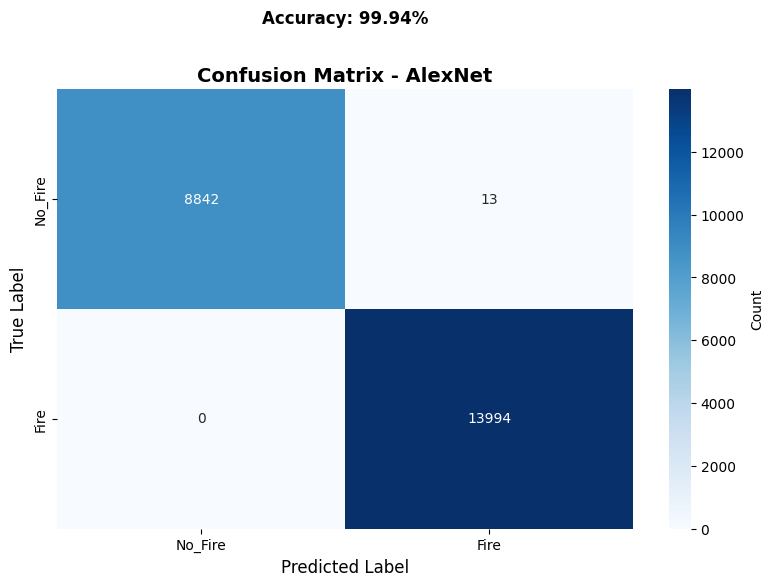

Confusion matrix plot saved to: /kaggle/working/models/AlexNet_TransferLearning/confusion_matrix.png


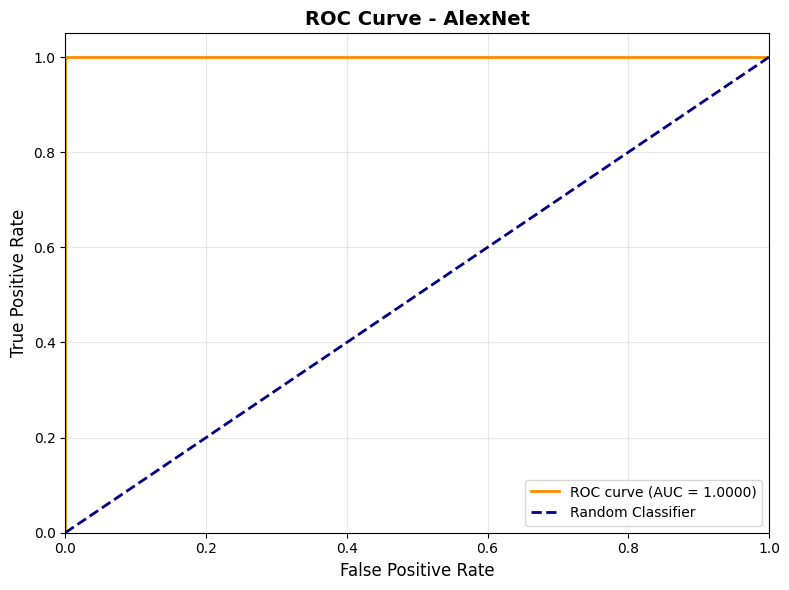

ROC curve plot saved to: /kaggle/working/models/AlexNet_TransferLearning/roc_curve.png
Evaluation results saved to: /kaggle/working/models/AlexNet_TransferLearning/evaluation_results.json

Uploading evaluation results to Google Drive...
  Uploaded: confusion_matrix.png
  Uploaded: roc_curve.png
  Uploaded: evaluation_results.json
  Evaluation results uploaded to Google Drive

EVALUATION COMPLETE - AlexNet
  Files saved:
    - confusion_matrix.png
    - roc_curve.png
    - evaluation_results.json



In [10]:
# Load test dataset
test_dataset = FireDatasetTransferLearning(
    '/kaggle/input/final-dataset/Final_Dataset', 
    split='test'
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Create model and checkpoint manager
model = AlexNetTransferLearning(num_classes=2, freeze_features=True)
model = model.to(device)

checkpoint_manager = CheckpointManager(
    model_name='AlexNet_TransferLearning',
    kaggle_dir='/kaggle/working/models',
    drive_service=drive_service,
    drive_base_folder_name='Deep Learning Semester Project',
    checkpoint_prefix='ALEXNET'
)

# Download best model from Drive (if needed)
download_checkpoint_from_drive(drive_service, checkpoint_manager, 'best')

# Load best model
checkpoint_manager.load_checkpoint(model, None, checkpoint_type='best')

# Evaluate
results = evaluate_and_save_results(
    model=model,
    test_loader=test_loader,
    checkpoint_manager=checkpoint_manager,
    device=device,
    model_name='AlexNet',
    drive_service=drive_service
)

## **SHARED TRAINING UTILITIES (REUSABLE FOR ALL MODELS)**

### **DATASET CLASS**

In [13]:
class FireDatasetTransferLearning(Dataset):
    """
    Dataset class for transfer learning with pre-trained models.
    Pre-trained models expect ImageNet preprocessing (mean and std).
    Works for: AlexNet, VGG19, ResNet50, GoogLeNet
    """
    def __init__(self, data_dir, split='train', use_imagenet_norm=True):
        """
        Args:
            data_dir: Path to the base data directory
            split: 'train', 'validation', or 'test'
            use_imagenet_norm: Use ImageNet normalization (required for pretrained models)
        """
        self.split = split
        self.use_imagenet_norm = use_imagenet_norm
        
        # ImageNet normalization parameters (required for pretrained models)
        self.imagenet_mean = np.array([0.485, 0.456, 0.406])
        self.imagenet_std = np.array([0.229, 0.224, 0.225])
        
        # Paths to Fire and No_Fire directories
        fire_dir = os.path.join(data_dir, split, 'Fire')
        nofire_dir = os.path.join(data_dir, split, 'No_Fire')
        
        # Get all file paths
        self.fire_files = sorted([os.path.join(fire_dir, f) 
                                  for f in os.listdir(fire_dir) if f.endswith('.jpg')])
        self.nofire_files = sorted([os.path.join(nofire_dir, f) 
                                    for f in os.listdir(nofire_dir) if f.endswith('.jpg')])
        
        # Combine and create labels
        self.image_files = self.fire_files + self.nofire_files
        self.labels = [1] * len(self.fire_files) + [0] * len(self.nofire_files)
        
        print(f"{split.capitalize()} dataset: {len(self.fire_files)} Fire, {len(self.nofire_files)} No_Fire")
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load JPG image
        image = cv2.imread(self.image_files[idx])
        
        # Convert BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Resize to 224x224 (required for pretrained models)
        image = cv2.resize(image, (224, 224))
        
        # Normalize to [0, 1]
        image = image.astype(np.float32) / 255.0
        
        # Apply ImageNet normalization (required for pretrained models)
        if self.use_imagenet_norm:
            image = (image - self.imagenet_mean) / self.imagenet_std
        
        label = self.labels[idx]
        
        # Convert to PyTorch tensor (HWC to CHW format)
        image = torch.FloatTensor(image).permute(2, 0, 1)
        label = torch.LongTensor([label])[0]
        
        return image, label

### **TRAINING FUNCTIONS**

In [14]:
def train_epoch(model, train_loader, criterion, optimizer, device, epoch):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch} [Train]')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f'{running_loss/len(pbar):.4f}',
            'acc': f'{100*correct/total:.2f}%'
        })
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc


def validate(model, val_loader, criterion, device, epoch):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc=f'Epoch {epoch} [Val]')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            pbar.set_postfix({
                'loss': f'{running_loss/len(pbar):.4f}',
                'acc': f'{100*correct/total:.2f}%'
            })
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc, all_preds, all_labels

### **CHECKPOINT MANAGER**

In [15]:
class CheckpointManager:
    """
    Manage model checkpoints with Google Drive API support.
    Works for all models - checkpoint filenames based on model_name.
    """
    def __init__(self, model_name, kaggle_dir, drive_service, drive_base_folder_name, 
                 checkpoint_prefix):
        """
        Args:
            model_name: Name of the model folder (e.g., 'AlexNet_TransferLearning')
            kaggle_dir: Base Kaggle directory for models
            drive_service: Google Drive service object
            drive_base_folder_name: Base folder name in Drive
            checkpoint_prefix: Prefix for checkpoint files (e.g., 'ALEXNET', 'VGG19')
        """
        self.model_name = model_name
        self.checkpoint_prefix = checkpoint_prefix
        self.kaggle_dir = os.path.join(kaggle_dir, model_name)
        self.drive_service = drive_service
        
        # Create Kaggle directory
        os.makedirs(self.kaggle_dir, exist_ok=True)
        
        # Create Drive folder structure
        self.drive_folder_id = None
        if drive_service:
            print(f"\nSetting up Google Drive folders for {model_name}...")
            try:
                # Import helper function (must be defined in calling script)
                from __main__ import find_or_create_folder
                
                # Find or create base folder
                base_folder_id = find_or_create_folder(drive_service, drive_base_folder_name)
                
                # Find or create models folder
                models_folder_id = find_or_create_folder(drive_service, 'models', base_folder_id)
                
                # Find or create model-specific folder
                self.drive_folder_id = find_or_create_folder(drive_service, model_name, models_folder_id)
                
                print(f"  Drive folder created: {drive_base_folder_name}/models/{model_name}/")
            except Exception as e:
                print(f"Warning: Could not create Drive folders: {e}")
                self.drive_folder_id = None
        
        self.best_val_acc = 0.0
    
    def save_checkpoint(self, epoch, model, optimizer, train_loss, train_acc, 
                       val_loss, val_acc, history, is_best=False):
        """Save checkpoint to Kaggle and upload to Google Drive"""
        
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'history': history,
            'best_val_acc': self.best_val_acc
        }
        
        # Save latest checkpoint locally
        latest_path = os.path.join(self.kaggle_dir, f'{self.checkpoint_prefix}_latest_checkpoint.pth')
        torch.save(checkpoint, latest_path)
        print(f"  Saved locally: {latest_path}")
        
        # Upload to Google Drive
        if self.drive_service and self.drive_folder_id:
            try:
                from __main__ import upload_file_to_drive
                upload_file_to_drive(
                    self.drive_service, 
                    latest_path, 
                    self.drive_folder_id,
                    f'{self.checkpoint_prefix}_latest_checkpoint.pth'
                )
            except Exception as e:
                print(f"Warning: Could not upload to Drive: {e}")
        
        # Save best model
        if is_best:
            best_path = os.path.join(self.kaggle_dir, f'{self.checkpoint_prefix}_best_model.pth')
            torch.save(checkpoint, best_path)
            print(f"  New best model saved! Val Acc: {val_acc:.2f}%")
            
            # Upload best model to Drive
            if self.drive_service and self.drive_folder_id:
                try:
                    from __main__ import upload_file_to_drive
                    upload_file_to_drive(
                        self.drive_service,
                        best_path,
                        self.drive_folder_id,
                        f'{self.checkpoint_prefix}_best_model.pth'
                    )
                except Exception as e:
                    print(f"Warning: Could not upload best model to Drive: {e}")
        
        # Save epoch checkpoint every 5 epochs
        if epoch % 5 == 0:
            epoch_path = os.path.join(self.kaggle_dir, f'checkpoint_epoch_{epoch}.pth')
            torch.save(checkpoint, epoch_path)
            
            # Upload to Drive
            if self.drive_service and self.drive_folder_id:
                try:
                    from __main__ import upload_file_to_drive
                    upload_file_to_drive(
                        self.drive_service,
                        epoch_path,
                        self.drive_folder_id,
                        f'checkpoint_epoch_{epoch}.pth'
                    )
                except Exception as e:
                    print(f"Warning: Could not upload epoch checkpoint to Drive: {e}")
    
    def load_checkpoint(self, model, optimizer, checkpoint_type='latest'):
        """Load checkpoint from Kaggle local storage"""
        
        if checkpoint_type == 'latest':
            checkpoint_path = os.path.join(self.kaggle_dir, f'{self.checkpoint_prefix}_latest_checkpoint.pth')
        elif checkpoint_type == 'best':
            checkpoint_path = os.path.join(self.kaggle_dir, f'{self.checkpoint_prefix}_best_model.pth')
        else:
            checkpoint_path = os.path.join(self.kaggle_dir, f'checkpoint_epoch_{checkpoint_type}.pth')
        
        if os.path.exists(checkpoint_path):
            print(f"Loading checkpoint from: {checkpoint_path}")
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            checkpoint = torch.load(checkpoint_path, map_location=device)
            
            model.load_state_dict(checkpoint['model_state_dict'])
            if optimizer:
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            
            self.best_val_acc = checkpoint.get('best_val_acc', 0.0)
            
            return checkpoint['epoch'], checkpoint.get('history', {})
        else:
            print(f"No checkpoint found at {checkpoint_path}")
            return 0, {}

### **TRAINING PIPELINE**

In [ ]:
def train_model_transfer_learning(model, train_loader, val_loader, num_epochs, 
                                   learning_rate, checkpoint_manager, 
                                   device, resume_from=None):
    """
    Single-stage transfer learning with frozen backbone.
    Only trains the final classification layer.
    
    Args:
        model: PyTorch model with frozen backbone
        train_loader: Training data loader
        val_loader: Validation data loader
        num_epochs: Total number of epochs to train
        learning_rate: Learning rate
        checkpoint_manager: CheckpointManager instance
        device: torch.device
        resume_from: None, 'latest', 'best', or epoch number
    """
    
    criterion = nn.CrossEntropyLoss()
    
    # Initialize history and start epoch
    start_epoch = 0
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    last_completed_epoch = 0
    
    print("\n" + "="*60)
    print("   TO STOP TRAINING:")
    print("   Click 'Interrupt' button in Kaggle")
    print("   OR press Ctrl+C multiple times")
    print("="*60 + "\n")
    
    try:
        # RESUME FROM CHECKPOINT
        if resume_from is not None:
            print(f"\n{'='*60}")
            print(f"RESUMING TRAINING FROM: {resume_from}")
            print(f"{'='*60}\n")
            
            temp_optimizer = optim.Adam(
                filter(lambda p: p.requires_grad, model.parameters()),
                lr=learning_rate
            )
            start_epoch, history = checkpoint_manager.load_checkpoint(
                model, temp_optimizer, resume_from
            )
            
            if start_epoch > 0:
                print(f"  Checkpoint loaded successfully!")
                print(f"  Resuming from epoch: {start_epoch}")
                print(f"  Previous best val acc: {checkpoint_manager.best_val_acc:.2f}%")
            else:
                start_epoch = 0
        
        print(f"\n{'='*60}")
        print(f"TRANSFER LEARNING STRATEGY:")
        print(f"{'='*60}")
        print(f"Training final classification layer only ({num_epochs} epochs)")
        print(f"  - Learning rate: {learning_rate}")
        print(f"  - Backbone: FROZEN (pretrained weights)")
        print(f"  - Only final layer will be trained")
        
        if start_epoch > 0:
            print(f"\n   Resuming from epoch {start_epoch + 1}")
        
        print(f"{'='*60}\n")
        
        # TRAIN FINAL LAYER ONLY
        print(f"\n{'='*60}")
        print("TRAINING FINAL LAYER (FROZEN BACKBONE)")
        print(f"{'='*60}\n")
        
        # Optimizer for trainable parameters only
        optimizer = optim.Adam(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=learning_rate
        )
        
        # Restore optimizer state if resuming
        if start_epoch > 0 and resume_from is not None:
            temp_optimizer = optim.Adam(
                filter(lambda p: p.requires_grad, model.parameters()),
                lr=learning_rate
            )
            checkpoint_manager.load_checkpoint(model, temp_optimizer, resume_from)
            optimizer.load_state_dict(temp_optimizer.state_dict())
        
        # Learning rate scheduler
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
        
        # Advance scheduler to correct step if resuming
        for _ in range(start_epoch):
            scheduler.step()
        
        # Training loop
        for epoch in range(start_epoch, num_epochs):
            # Train
            train_loss, train_acc = train_epoch(model, train_loader, criterion, 
                                               optimizer, device, epoch+1)
            
            # Validate
            val_loss, val_acc, val_preds, val_labels = validate(model, val_loader, 
                                                                criterion, device, epoch+1)
            
            # Update learning rate
            scheduler.step()
            
            # Update history
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            
            # Print epoch summary
            print(f"\nEpoch {epoch+1}/{num_epochs} Summary:")
            print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
            print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
            print(f"  Learning Rate: {scheduler.get_last_lr()[0]:.6f}\n")
            
            # Check if best model
            is_best = val_acc > checkpoint_manager.best_val_acc
            if is_best:
                checkpoint_manager.best_val_acc = val_acc
            
            # Save checkpoint
            checkpoint_manager.save_checkpoint(
                epoch + 1, model, optimizer, train_loss, train_acc,
                val_loss, val_acc, history, is_best=is_best
            )
            
            last_completed_epoch = epoch + 1
        
        # Training completed successfully
        print(f"\n{'='*60}")
        print("  TRAINING COMPLETED SUCCESSFULLY!")
        print(f"{'='*60}\n")
    
    except KeyboardInterrupt:
        # Graceful handling of Ctrl+C / Interrupt button
        print(f"\n\n{'='*60}")
        print("  TRAINING INTERRUPTED BY USER")
        print(f"{'='*60}")
        print(f"\n  PROGRESS:")
        print(f"  Last completed epoch: {last_completed_epoch}")
        print(f"  Total epochs completed: {len(history['train_loss'])}")
        print(f"  Best validation accuracy: {checkpoint_manager.best_val_acc:.2f}%")
        
        print(f"\n  CHECKPOINT SAVED:")
        print(f"  Latest checkpoint at epoch {last_completed_epoch}")
        print(f"  All progress has been saved")
        
        print(f"\n   TO RESUME TRAINING:")
        print(f"  Set: resume_from='latest'")
        print(f"  Training will continue from epoch {last_completed_epoch + 1}")
        
        print(f"\n{'='*60}\n")
    
    except Exception as e:
        # Handle unexpected errors
        print(f"\n{'='*60}")
        print("  UNEXPECTED ERROR OCCURRED!")
        print(f"{'='*60}")
        print(f"Error: {e}")
        print(f"\nLast completed epoch: {last_completed_epoch}")
        print("Checkpoint saved at last completed epoch")
        print("You can resume training using: resume_from='latest'")
        print(f"{'='*60}\n")
        raise
    
    return history


### **VISUALIZATION**

In [17]:
def plot_training_history_transfer_learning(history, save_path):
    """Plot training history (single stage - no stage markers)"""
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss plot
    axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
    axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # Accuracy plot
    axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
    axes[1].plot(history['val_acc'], label='Val Acc', marker='s')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Training history plot saved to: {save_path}")

### **DOWNLOAD CHECKPOINT FROM DRIVE**

In [18]:
def download_checkpoint_from_drive(drive_service, checkpoint_manager, checkpoint_type='latest'):
    """
    Download checkpoint from Google Drive to Kaggle before resuming.
    Works for all models - uses checkpoint_manager.checkpoint_prefix
    """
    print(f"\n{'='*60}")
    print(f"DOWNLOADING CHECKPOINT FROM GOOGLE DRIVE")
    print(f"{'='*60}\n")
    
    if not drive_service or not checkpoint_manager.drive_folder_id:
        print("  Google Drive not connected!")
        return False
    
    try:
        from __main__ import download_file_from_drive
        
        # Search for checkpoint file in Drive
        if checkpoint_type == 'latest':
            filename = f'{checkpoint_manager.checkpoint_prefix}_latest_checkpoint.pth'
        elif checkpoint_type == 'best':
            filename = f'{checkpoint_manager.checkpoint_prefix}_best_model.pth'
        else:
            filename = f'checkpoint_epoch_{checkpoint_type}.pth'
        
        # Search for file
        query = f"name='{filename}' and '{checkpoint_manager.drive_folder_id}' in parents and trashed=false"
        results = drive_service.files().list(q=query, fields='files(id, name)').execute()
        files = results.get('files', [])
        
        if not files:
            print(f"  Checkpoint '{filename}' not found in Drive")
            return False
        
        file_id = files[0]['id']
        destination = os.path.join(checkpoint_manager.kaggle_dir, filename)
        
        # Download
        download_file_from_drive(drive_service, file_id, destination)
        print(f"  Checkpoint downloaded: {filename}")
        return True
        
    except Exception as e:
        print(f"  Error downloading checkpoint: {e}")
        return False

### **EVALUATION FUNCTIONS**

In [19]:
def evaluate_model(model, test_loader, device, model_name):
    """
    Evaluate model on test dataset.
    
    Args:
        model: PyTorch model
        test_loader: Test data loader
        device: torch.device
        model_name: Name of the model for display
        
    Returns:
        Dictionary with evaluation metrics
    """
    from sklearn.metrics import (
        accuracy_score, precision_score, recall_score, f1_score,
        confusion_matrix, classification_report
    )
    
    print(f"\n{'='*60}")
    print(f"EVALUATING {model_name} ON TEST DATASET")
    print(f"{'='*60}\n")
    
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    criterion = nn.CrossEntropyLoss()
    test_loss = 0.0
    
    with torch.no_grad():
        pbar = tqdm(test_loader, desc='Testing')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            # Get probabilities and predictions
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Calculate metrics
    test_loss = test_loss / len(test_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    # Print results
    print(f"\n{'='*60}")
    print(f"TEST RESULTS - {model_name}")
    print(f"{'='*60}")
    print(f"  Test Loss:      {test_loss:.4f}")
    print(f"  Accuracy:       {accuracy*100:.2f}%")
    print(f"  Precision:      {precision*100:.2f}%")
    print(f"  Recall:         {recall*100:.2f}%")
    print(f"  F1-Score:       {f1*100:.2f}%")
    print(f"\n  Confusion Matrix:")
    print(f"    TN: {conf_matrix[0][0]}  FP: {conf_matrix[0][1]}")
    print(f"    FN: {conf_matrix[1][0]}  TP: {conf_matrix[1][1]}")
    print(f"{'='*60}\n")
    
    # Detailed classification report
    print("Detailed Classification Report:")
    print(classification_report(all_labels, all_preds, 
                                target_names=['No_Fire', 'Fire'], digits=4))
    
    # Return metrics dictionary
    results = {
        'test_loss': test_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': conf_matrix,
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs
    }
    
    return results


def plot_confusion_matrix(conf_matrix, save_path, model_name):
    """
    Plot confusion matrix as a heatmap.
    
    Args:
        conf_matrix: Confusion matrix array
        save_path: Path to save the plot
        model_name: Name of the model for title
    """
    import seaborn as sns
    
    plt.figure(figsize=(8, 6))
    
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No_Fire', 'Fire'],
                yticklabels=['No_Fire', 'Fire'],
                cbar_kws={'label': 'Count'})
    
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    
    # Add accuracy text
    accuracy = (conf_matrix[0][0] + conf_matrix[1][1]) / conf_matrix.sum()
    plt.text(1, -0.3, f'Accuracy: {accuracy*100:.2f}%', 
             ha='center', fontsize=12, fontweight='bold',
             transform=plt.gca().transData)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Confusion matrix plot saved to: {save_path}")


def plot_roc_curve(labels, probs, save_path, model_name):
    """
    Plot ROC curve.
    
    Args:
        labels: True labels
        probs: Predicted probabilities (for positive class)
        save_path: Path to save the plot
        model_name: Name of the model for title
    """
    from sklearn.metrics import roc_curve, auc
    
    # Get probabilities for positive class (Fire = 1)
    probs_positive = [p[1] for p in probs]
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(labels, probs_positive)
    roc_auc = auc(fpr, tpr)
    
    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curve - {model_name}', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"ROC curve plot saved to: {save_path}")
    
    return roc_auc


def save_evaluation_results(results, save_path, model_name):
    """
    Save evaluation results to JSON file.
    
    Args:
        results: Dictionary of evaluation metrics
        save_path: Path to save the JSON file
        model_name: Name of the model
    """
    # Convert numpy arrays to lists for JSON serialization
    results_json = {
        'model_name': model_name,
        'test_loss': float(results['test_loss']),
        'accuracy': float(results['accuracy']),
        'precision': float(results['precision']),
        'recall': float(results['recall']),
        'f1_score': float(results['f1_score']),
        'confusion_matrix': results['confusion_matrix'].tolist(),
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }
    
    with open(save_path, 'w') as f:
        json.dump(results_json, f, indent=2)
    
    print(f"Evaluation results saved to: {save_path}")


def evaluate_and_save_results(model, test_loader, checkpoint_manager, device, 
                              model_name, drive_service=None):
    """
    Complete evaluation pipeline: evaluate, plot, and save results.
    
    Args:
        model: PyTorch model
        test_loader: Test data loader
        checkpoint_manager: CheckpointManager instance
        device: torch.device
        model_name: Name of the model
        drive_service: Google Drive service (optional)
        
    Returns:
        Dictionary with evaluation results
    """
    
    # Evaluate model
    results = evaluate_model(model, test_loader, device, model_name)
    
    # Plot confusion matrix
    conf_matrix_path = os.path.join(checkpoint_manager.kaggle_dir, 'confusion_matrix.png')
    plot_confusion_matrix(results['confusion_matrix'], conf_matrix_path, model_name)
    
    # Plot ROC curve
    roc_path = os.path.join(checkpoint_manager.kaggle_dir, 'roc_curve.png')
    roc_auc = plot_roc_curve(results['labels'], results['probabilities'], roc_path, model_name)
    results['roc_auc'] = roc_auc
    
    # Save evaluation results
    results_path = os.path.join(checkpoint_manager.kaggle_dir, 'evaluation_results.json')
    save_evaluation_results(results, results_path, model_name)
    
    # Upload to Google Drive
    if drive_service and checkpoint_manager.drive_folder_id:
        try:
            from __main__ import upload_file_to_drive
            
            print("\nUploading evaluation results to Google Drive...")
            upload_file_to_drive(drive_service, conf_matrix_path, 
                               checkpoint_manager.drive_folder_id, 'confusion_matrix.png')
            upload_file_to_drive(drive_service, roc_path, 
                               checkpoint_manager.drive_folder_id, 'roc_curve.png')
            upload_file_to_drive(drive_service, results_path, 
                               checkpoint_manager.drive_folder_id, 'evaluation_results.json')
            print("  Evaluation results uploaded to Google Drive")
        except Exception as e:
            print(f"Warning: Could not upload evaluation results to Drive: {e}")
    
    print(f"\n{'='*60}")
    print(f"EVALUATION COMPLETE - {model_name}")
    print(f"{'='*60}")
    print(f"  Files saved:")
    print(f"    - confusion_matrix.png")
    print(f"    - roc_curve.png")
    print(f"    - evaluation_results.json")
    print(f"{'='*60}\n")
    
    return results

### **TRAIN & EVALUATE FUNCTION FOR ALL MODELS**

In [ ]:
def train_and_evaluate_model(model_class, model_name, checkpoint_prefix, config):
    """
    Complete pipeline: train model (single-stage) and evaluate on test set.
    
    Args:
        model_class: Model class to instantiate
        model_name: Name for folders (e.g., 'AlexNet_TransferLearning')
        checkpoint_prefix: Prefix for checkpoints (e.g., 'ALEXNET')
        config: Configuration dictionary
    
    Returns:
        tuple: (training_history, evaluation_results, checkpoint_manager)
    """
    
    print(f"\n{'='*70}")
    print(f"  TRAINING AND EVALUATING: {model_name}")
    print(f"{'='*70}\n")
    
    # STEP 1: CREATE DATASETS
    print(f"\n{'='*60}")
    print("LOADING DATASETS")
    print(f"{'='*60}")
    
    train_dataset = FireDatasetTransferLearning(config['data_path'], split='train')
    val_dataset = FireDatasetTransferLearning(config['data_path'], split='validation')
    test_dataset = FireDatasetTransferLearning(config['data_path'], split='test')
    
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], 
                             shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], 
                           shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], 
                            shuffle=False, num_workers=2, pin_memory=True)
    
    print(f"  Datasets loaded successfully")
    
    # STEP 2: CREATE MODEL
    print(f"\n{'='*60}")
    print("CREATING MODEL")
    print(f"{'='*60}")
    
    model = model_class(num_classes=config['num_classes'])
    model = model.to(device)
    
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    print(f" Model created: {total_params:,} total params, {trainable_params:,} trainable")
    
    # STEP 3: CREATE CHECKPOINT MANAGER
    print(f"\n{'='*60}")
    print("SETTING UP CHECKPOINT MANAGER")
    print(f"{'='*60}")
    
    checkpoint_manager = CheckpointManager(
        model_name=model_name,
        kaggle_dir=config['kaggle_models_path'],
        drive_service=config.get('drive_service'),
        drive_base_folder_name=config['drive_base_folder'],
        checkpoint_prefix=checkpoint_prefix
    )
    
    # STEP 4: TRAIN MODEL (SINGLE-STAGE)
    print(f"\n{'='*60}")
    print("TRAINING MODEL (FROZEN BACKBONE)")
    print(f"{'='*60}")
    
    history = train_model_transfer_learning(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=config['num_epochs'],             
        learning_rate=config['learning_rate'],       
        checkpoint_manager=checkpoint_manager,
        device=device,
        resume_from=config.get('resume_from', None)
    )
    
    # Plot training history
    plot_path = os.path.join(checkpoint_manager.kaggle_dir, 'training_history.png')
    plot_training_history_transfer_learning(history, plot_path)
    
    if config.get('drive_service') and checkpoint_manager.drive_folder_id:
        upload_file_to_drive(config['drive_service'], plot_path, 
                           checkpoint_manager.drive_folder_id, 'training_history.png')
    
    # STEP 5: LOAD BEST MODEL FOR EVALUATION
    print(f"\n{'='*60}")
    print("LOADING BEST MODEL FOR EVALUATION")
    print(f"{'='*60}")
    
    # Load best model checkpoint
    checkpoint_manager.load_checkpoint(model, None, checkpoint_type='best')
    print(" Best model loaded")
    
    # STEP 6: EVALUATE ON TEST SET
    print(f"\n{'='*60}")
    print("EVALUATING ON TEST SET")
    print(f"{'='*60}")
    
    results = evaluate_and_save_results(
        model=model,
        test_loader=test_loader,
        checkpoint_manager=checkpoint_manager,
        device=device,
        model_name=model_name,
        drive_service=config.get('drive_service')
    )
    
    print(f"\n{'='*70}")
    print(f"  COMPLETED: {model_name}")
    print(f"  Best Val Acc: {checkpoint_manager.best_val_acc:.2f}%")
    print(f"  Test Acc: {results['accuracy']*100:.2f}%")
    print(f"{'='*70}\n")
    
    return history, results, checkpoint_manager

## **DEFINE ALL 4 MODELS**

### **ALEXNET**

In [21]:
class AlexNetTransferLearning(nn.Module):
    """AlexNet with transfer learning - Frozen backbone only"""
    
    def __init__(self, num_classes=2):
        super(AlexNetTransferLearning, self).__init__()
        
        # Load pretrained AlexNet
        self.model = models.alexnet(pretrained=True)
        
        # ALWAYS freeze feature extraction layers
        for param in self.model.features.parameters():
            param.requires_grad = False
        
        print("Feature extraction layers FROZEN (will not be trained)")
        
        # Replace the last fully connected layer
        num_features = self.model.classifier[6].in_features
        self.model.classifier[6] = nn.Linear(num_features, num_classes)
        
        print(f"Loaded pretrained AlexNet from ImageNet")
        print(f"Modified final layer: {num_features} -> {num_classes} classes")
        print("   Only final layer will be trained")
        
    def forward(self, x):
        return self.model(x)

### **VGG19**

In [22]:
class VGG19TransferLearning(nn.Module):
    
    def __init__(self, num_classes=2, freeze_features=True):
        super(VGG19TransferLearning, self).__init__()
        self.model = models.vgg19(pretrained=True)
            
        for param in self.model.features.parameters():
            param.requires_grad = False
            
        num_features = self.model.classifier[6].in_features
        self.model.classifier[6] = nn.Linear(num_features, num_classes)
    
    def forward(self, x):
        return self.model(x)
    

### **RESNET50**

In [41]:
class ResNet50TransferLearning(nn.Module):
    def __init__(self, num_classes=2, freeze_features=True):
        super(ResNet50TransferLearning, self).__init__()
        self.model = models.resnet50(pretrained=True)
        
        for param in self.model.parameters():
            param.requires_grad = False
        
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, num_classes)
    
    def forward(self, x):
        return self.model(x)

### **GOOGLENET**

In [123]:
class GoogLeNetTransferLearning(nn.Module):
    def __init__(self, num_classes=2, freeze_features=True):
        super(GoogLeNetTransferLearning, self).__init__()
        self.model = models.googlenet(pretrained=True)
        self.model.aux_logits = False

        for param in self.model.parameters():
            param.requires_grad = False
        
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, num_classes)
    
    def forward(self, x):
        return self.model(x)

## **MAIN EXECUTION**

In [23]:
# Mount Drive and setup paths
drive_service = mount_google_drive_kaggle()
    
config = {
    'data_path': '/kaggle/input/final-dataset/Final_Dataset',
    'kaggle_models_path': '/kaggle/working/models',
    'drive_service': drive_service,
    'drive_base_folder': 'Deep Learning Semester Project',
    'num_classes': 2,
    'batch_size': 32,
    'num_epochs': 20,              
    'learning_rate': 0.001,       
    'resume_from': None
}
    
# Dictionary to store all results
all_results = {}
all_histories = {}
all_checkpoint_managers = {}


MOUNTING GOOGLE DRIVE (KAGGLE):
Loading authentication token...
Testing connection...
Google Drive mounted successfully via OAuth!
Full read/write access enabled


### **ALEXNET**

In [ ]:
print("\n\n" + "="*70)
print("STARTING ALEXNET")
print("="*70)
    
history_alexnet, results_alexnet, cm_alexnet = train_and_evaluate_model(
    model_class=AlexNetTransferLearning,
    model_name='AlexNet_TransferLearning',
    checkpoint_prefix='ALEXNET',
    config=config
)

all_results['AlexNet'] = results_alexnet
all_histories['AlexNet'] = history_alexnet
all_checkpoint_managers['AlexNet'] = cm_alexnet

### **VGG19**

In [ ]:
print("\n\n" + "="*70)
print("STARTING VGG19")
print("="*70)
    
history_vgg19, results_vgg19, cm_vgg19 = train_and_evaluate_model(
    model_class=VGG19TransferLearning,
    model_name='VGG19_TransferLearning',
    checkpoint_prefix='VGG19',
    config=config
)

all_results['VGG19'] = results_vgg19
all_histories['VGG19'] = history_vgg19
all_checkpoint_managers['VGG19'] = cm_vgg19



STARTING VGG19

  TRAINING AND EVALUATING: VGG19_TransferLearning


LOADING DATASETS
Train dataset: 84860 Fire, 28386 No_Fire
Validation dataset: 11183 Fire, 7096 No_Fire
Test dataset: 13994 Fire, 8855 No_Fire
  Datasets loaded successfully

CREATING MODEL


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 222MB/s]  


 Model created: 139,578,434 total params, 119,554,050 trainable

SETTING UP CHECKPOINT MANAGER

Setting up Google Drive folders for VGG19_TransferLearning...
  Found existing folder: Deep Learning Semester Project
  Found existing folder: models
  Found existing folder: VGG19_TransferLearning
  Drive folder created: Deep Learning Semester Project/models/VGG19_TransferLearning/

TRAINING MODEL (FROZEN BACKBONE)

   TO STOP TRAINING:
   Click 'Interrupt' button in Kaggle
   OR press Ctrl+C multiple times


TRANSFER LEARNING STRATEGY:
Training final classification layer only (20 epochs)
  - Learning rate: 0.001
  - Backbone: FROZEN (pretrained weights)
  - Only final layer will be trained


TRAINING FINAL LAYER (FROZEN BACKBONE)



Epoch 1 [Val]: 100%|██████████| 572/572 [02:42<00:00,  3.51it/s, loss=0.1737, acc=99.63%]



Epoch 1/20 Summary:
  Train Loss: 0.2607 | Train Acc: 98.96%
  Val Loss: 0.1737 | Val Acc: 99.63%
  Learning Rate: 0.001000

  Saved locally: /kaggle/working/models/VGG19_TransferLearning/VGG19_latest_checkpoint.pth
  Updated: VGG19_latest_checkpoint.pth
  New best model saved! Val Acc: 99.63%
  Updated: VGG19_best_model.pth


Epoch 2 [Val]: 100%|██████████| 572/572 [02:02<00:00,  4.65it/s, loss=0.0637, acc=99.84%]



Epoch 2/20 Summary:
  Train Loss: 0.1914 | Train Acc: 99.60%
  Val Loss: 0.0637 | Val Acc: 99.84%
  Learning Rate: 0.001000

  Saved locally: /kaggle/working/models/VGG19_TransferLearning/VGG19_latest_checkpoint.pth
  Updated: VGG19_latest_checkpoint.pth
  New best model saved! Val Acc: 99.84%
  Updated: VGG19_best_model.pth


Epoch 3 [Val]: 100%|██████████| 572/572 [02:03<00:00,  4.65it/s, loss=0.0965, acc=99.81%]



Epoch 3/20 Summary:
  Train Loss: 0.1968 | Train Acc: 99.74%
  Val Loss: 0.0965 | Val Acc: 99.81%
  Learning Rate: 0.001000

  Saved locally: /kaggle/working/models/VGG19_TransferLearning/VGG19_latest_checkpoint.pth
  Updated: VGG19_latest_checkpoint.pth


Epoch 4 [Val]: 100%|██████████| 572/572 [02:03<00:00,  4.65it/s, loss=0.0193, acc=99.93%]



Epoch 4/20 Summary:
  Train Loss: 0.1160 | Train Acc: 99.81%
  Val Loss: 0.0193 | Val Acc: 99.93%
  Learning Rate: 0.001000

  Saved locally: /kaggle/working/models/VGG19_TransferLearning/VGG19_latest_checkpoint.pth
  Updated: VGG19_latest_checkpoint.pth
  New best model saved! Val Acc: 99.93%
  Updated: VGG19_best_model.pth


Epoch 5 [Val]: 100%|██████████| 572/572 [02:02<00:00,  4.66it/s, loss=0.1297, acc=99.83%]



Epoch 5/20 Summary:
  Train Loss: 0.1306 | Train Acc: 99.83%
  Val Loss: 0.1297 | Val Acc: 99.83%
  Learning Rate: 0.001000

  Saved locally: /kaggle/working/models/VGG19_TransferLearning/VGG19_latest_checkpoint.pth
  Updated: VGG19_latest_checkpoint.pth
  Updated: checkpoint_epoch_5.pth


Epoch 6 [Val]: 100%|██████████| 572/572 [02:02<00:00,  4.66it/s, loss=0.1368, acc=99.86%]



Epoch 6/20 Summary:
  Train Loss: 0.1419 | Train Acc: 99.85%
  Val Loss: 0.1368 | Val Acc: 99.86%
  Learning Rate: 0.001000

  Saved locally: /kaggle/working/models/VGG19_TransferLearning/VGG19_latest_checkpoint.pth
  Updated: VGG19_latest_checkpoint.pth


Epoch 7 [Val]: 100%|██████████| 572/572 [02:02<00:00,  4.68it/s, loss=0.0574, acc=99.91%]



Epoch 7/20 Summary:
  Train Loss: 0.1112 | Train Acc: 99.86%
  Val Loss: 0.0574 | Val Acc: 99.91%
  Learning Rate: 0.001000

  Saved locally: /kaggle/working/models/VGG19_TransferLearning/VGG19_latest_checkpoint.pth
  Updated: VGG19_latest_checkpoint.pth


Epoch 8 [Val]: 100%|██████████| 572/572 [02:02<00:00,  4.65it/s, loss=0.0732, acc=99.91%]



Epoch 8/20 Summary:
  Train Loss: 0.0806 | Train Acc: 99.89%
  Val Loss: 0.0732 | Val Acc: 99.91%
  Learning Rate: 0.001000

  Saved locally: /kaggle/working/models/VGG19_TransferLearning/VGG19_latest_checkpoint.pth
  Updated: VGG19_latest_checkpoint.pth


Epoch 9 [Val]: 100%|██████████| 572/572 [02:02<00:00,  4.66it/s, loss=0.1112, acc=99.90%]



Epoch 9/20 Summary:
  Train Loss: 0.1061 | Train Acc: 99.87%
  Val Loss: 0.1112 | Val Acc: 99.90%
  Learning Rate: 0.001000

  Saved locally: /kaggle/working/models/VGG19_TransferLearning/VGG19_latest_checkpoint.pth
  Updated: VGG19_latest_checkpoint.pth


Epoch 10 [Val]: 100%|██████████| 572/572 [02:02<00:00,  4.65it/s, loss=0.0372, acc=99.95%]



Epoch 10/20 Summary:
  Train Loss: 0.0881 | Train Acc: 99.90%
  Val Loss: 0.0372 | Val Acc: 99.95%
  Learning Rate: 0.000100

  Saved locally: /kaggle/working/models/VGG19_TransferLearning/VGG19_latest_checkpoint.pth
  Updated: VGG19_latest_checkpoint.pth
  New best model saved! Val Acc: 99.95%
  Updated: VGG19_best_model.pth
  Updated: checkpoint_epoch_10.pth


Epoch 11 [Train]:  62%|██████▏   | 2210/3539 [09:14<05:33,  3.98it/s, loss=0.0497, acc=99.93%]

#### **RESUME TRAINING**


MOUNTING GOOGLE DRIVE (KAGGLE):
Loading authentication token...
Testing connection...
Google Drive mounted successfully via OAuth!
Full read/write access enabled


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 223MB/s] 



Setting up Google Drive folders for VGG19_TransferLearning...
  Found existing folder: Deep Learning Semester Project
  Found existing folder: models
  Found existing folder: VGG19_TransferLearning
  Drive folder created: Deep Learning Semester Project/models/VGG19_TransferLearning/

DOWNLOADING CHECKPOINT FROM GOOGLE DRIVE

  Downloaded: checkpoint_epoch_15.pth
  Checkpoint downloaded: checkpoint_epoch_15.pth
  Checkpoint downloaded!

  TRAINING AND EVALUATING: VGG19_TransferLearning


LOADING DATASETS
Train dataset: 84860 Fire, 28386 No_Fire
Validation dataset: 11183 Fire, 7096 No_Fire
Test dataset: 13994 Fire, 8855 No_Fire
  Datasets loaded successfully

CREATING MODEL
 Model created: 139,578,434 total params, 119,554,050 trainable

SETTING UP CHECKPOINT MANAGER

Setting up Google Drive folders for VGG19_TransferLearning...
  Found existing folder: Deep Learning Semester Project
  Found existing folder: models
  Found existing folder: VGG19_TransferLearning
  Drive folder created: 

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
Epoch 16 [Val]: 100%|██████████| 572/572 [01:24<00:00,  6.79it/s, loss=0.0381, acc=99.96%]



Epoch 16/20 Summary:
  Train Loss: 0.0466 | Train Acc: 99.95%
  Val Loss: 0.0381 | Val Acc: 99.96%
  Learning Rate: 0.000001

  Saved locally: /kaggle/working/models/VGG19_TransferLearning/VGG19_latest_checkpoint.pth
  Updated: VGG19_latest_checkpoint.pth


Epoch 17 [Val]: 100%|██████████| 572/572 [00:55<00:00, 10.32it/s, loss=0.0379, acc=99.96%]



Epoch 17/20 Summary:
  Train Loss: 0.0368 | Train Acc: 99.95%
  Val Loss: 0.0379 | Val Acc: 99.96%
  Learning Rate: 0.000001

  Saved locally: /kaggle/working/models/VGG19_TransferLearning/VGG19_latest_checkpoint.pth
  Updated: VGG19_latest_checkpoint.pth


Epoch 18 [Val]: 100%|██████████| 572/572 [00:54<00:00, 10.53it/s, loss=0.0376, acc=99.96%]



Epoch 18/20 Summary:
  Train Loss: 0.0439 | Train Acc: 99.95%
  Val Loss: 0.0376 | Val Acc: 99.96%
  Learning Rate: 0.000001

  Saved locally: /kaggle/working/models/VGG19_TransferLearning/VGG19_latest_checkpoint.pth
  Updated: VGG19_latest_checkpoint.pth


Epoch 19 [Val]: 100%|██████████| 572/572 [00:54<00:00, 10.52it/s, loss=0.0371, acc=99.96%]



Epoch 19/20 Summary:
  Train Loss: 0.0448 | Train Acc: 99.96%
  Val Loss: 0.0371 | Val Acc: 99.96%
  Learning Rate: 0.000001

  Saved locally: /kaggle/working/models/VGG19_TransferLearning/VGG19_latest_checkpoint.pth
  Updated: VGG19_latest_checkpoint.pth


Epoch 20 [Val]: 100%|██████████| 572/572 [00:54<00:00, 10.52it/s, loss=0.0369, acc=99.96%]



Epoch 20/20 Summary:
  Train Loss: 0.0412 | Train Acc: 99.96%
  Val Loss: 0.0369 | Val Acc: 99.96%
  Learning Rate: 0.000000

  Saved locally: /kaggle/working/models/VGG19_TransferLearning/VGG19_latest_checkpoint.pth
  Updated: VGG19_latest_checkpoint.pth
  Updated: checkpoint_epoch_20.pth

  TRAINING COMPLETED SUCCESSFULLY!



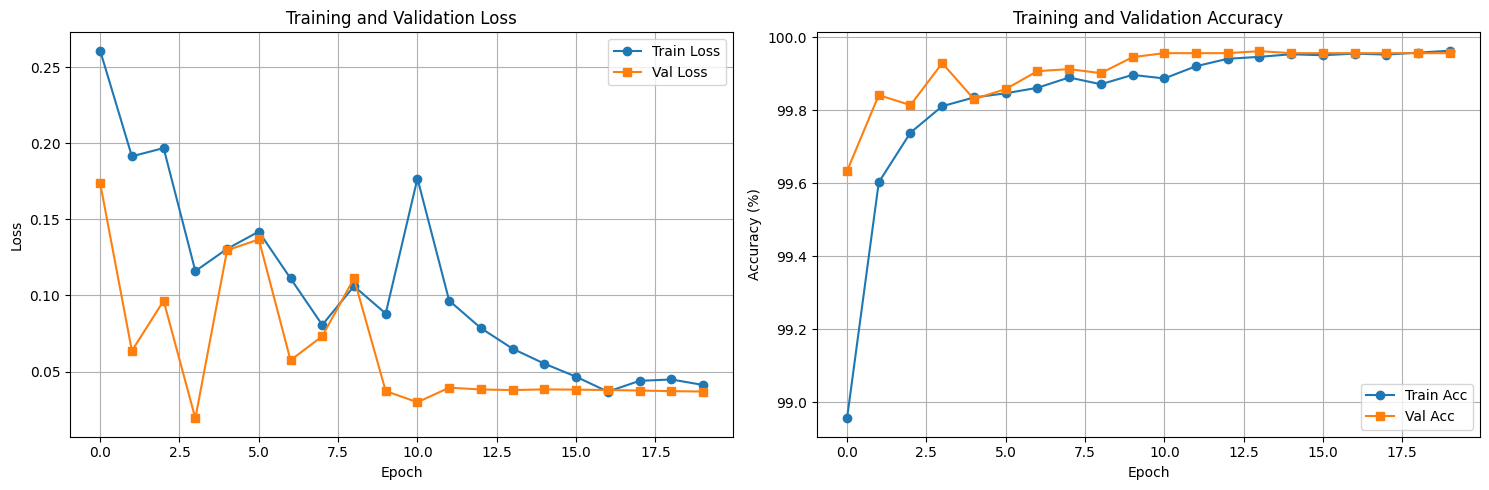

Training history plot saved to: /kaggle/working/models/VGG19_TransferLearning/training_history.png
  Updated: training_history.png

LOADING BEST MODEL FOR EVALUATION
No checkpoint found at /kaggle/working/models/VGG19_TransferLearning/VGG19_best_model.pth
 Best model loaded

EVALUATING ON TEST SET

EVALUATING VGG19_TransferLearning ON TEST DATASET



Testing: 100%|██████████| 715/715 [02:05<00:00,  5.70it/s]



TEST RESULTS - VGG19_TransferLearning
  Test Loss:      0.0618
  Accuracy:       99.93%
  Precision:      99.91%
  Recall:         99.98%
  F1-Score:       99.94%

  Confusion Matrix:
    TN: 8842  FP: 13
    FN: 3  TP: 13991

Detailed Classification Report:
              precision    recall  f1-score   support

     No_Fire     0.9997    0.9985    0.9991      8855
        Fire     0.9991    0.9998    0.9994     13994

    accuracy                         0.9993     22849
   macro avg     0.9994    0.9992    0.9993     22849
weighted avg     0.9993    0.9993    0.9993     22849



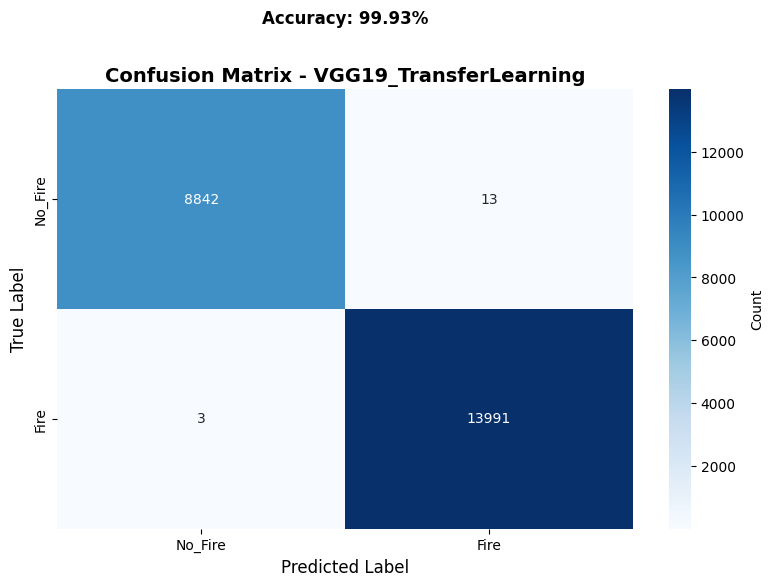

Confusion matrix plot saved to: /kaggle/working/models/VGG19_TransferLearning/confusion_matrix.png


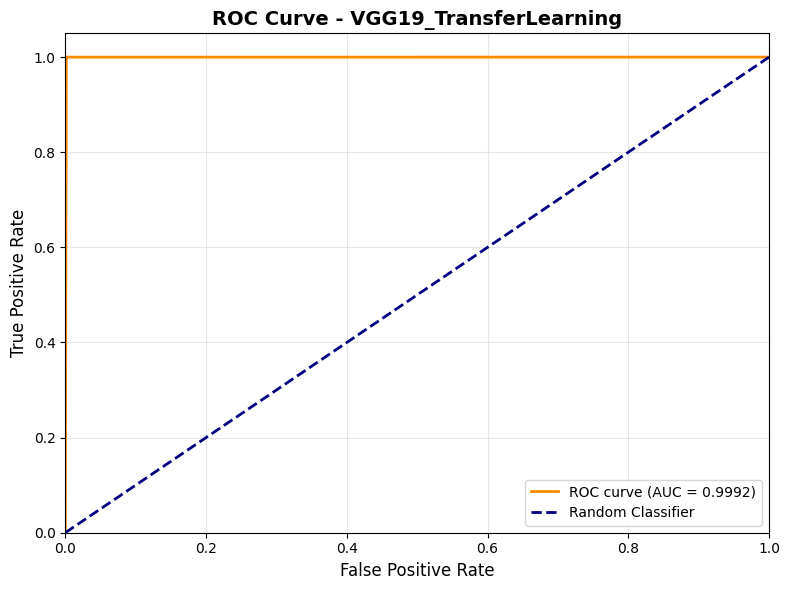

ROC curve plot saved to: /kaggle/working/models/VGG19_TransferLearning/roc_curve.png
Evaluation results saved to: /kaggle/working/models/VGG19_TransferLearning/evaluation_results.json

Uploading evaluation results to Google Drive...
  Updated: confusion_matrix.png
  Updated: roc_curve.png
  Updated: evaluation_results.json
  Evaluation results uploaded to Google Drive

EVALUATION COMPLETE - VGG19_TransferLearning
  Files saved:
    - confusion_matrix.png
    - roc_curve.png
    - evaluation_results.json


  COMPLETED: VGG19_TransferLearning
  Best Val Acc: 99.96%
  Test Acc: 99.93%



In [ ]:
# Step 1: Setup paths and device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
KAGGLE_DATA_PATH = '/kaggle/input/final-dataset/Final_Dataset'
KAGGLE_MODELS_PATH = '/kaggle/working/models'
DRIVE_BASE_FOLDER_NAME = 'Deep Learning Semester Project'

# Step 2: Mount Drive
drive_service = mount_google_drive_kaggle()

# Step 3: Create the model instance
model = VGG19TransferLearning(num_classes=2)
model = model.to(device)

# Step 4: CREATE CHECKPOINT MANAGER
checkpoint_manager = CheckpointManager(
    model_name='VGG19_TransferLearning',
    kaggle_dir=KAGGLE_MODELS_PATH,
    drive_service=drive_service,
    drive_base_folder_name=DRIVE_BASE_FOLDER_NAME,
    checkpoint_prefix='VGG19'
)

# Step 5: Now download the checkpoint
print("Downloading checkpoint from Google Drive...")
success = download_checkpoint_from_drive(
    drive_service=drive_service,
    checkpoint_manager=checkpoint_manager,
    checkpoint_type=15  # or 'latest' or 'best'
)

if success:
    print("  Checkpoint downloaded!")
    
    # Step 6: Configure for resume
    config = {
        'data_path': KAGGLE_DATA_PATH,
        'kaggle_models_path': KAGGLE_MODELS_PATH,
        'drive_service': drive_service,
        'drive_base_folder': DRIVE_BASE_FOLDER_NAME,
        'num_classes': 2,
        'batch_size': 32,
        'num_epochs': 20,
        'learning_rate': 0.001,
        'resume_from': 15  # or 'latest' or 'best'
    }
    
    # Step 7: Resume training
    history, results, cm = train_and_evaluate_model(
        model_class=VGG19TransferLearning,
        model_name='VGG19_TransferLearning',
        checkpoint_prefix='VGG19',
        config=config
    )
else:
    print("  Could not download checkpoint")

### **RESNET50**



STARTING RESNET50

  TRAINING AND EVALUATING: ResNet50_TransferLearning


LOADING DATASETS
Train dataset: 84860 Fire, 28386 No_Fire
Validation dataset: 11183 Fire, 7096 No_Fire
Test dataset: 13994 Fire, 8855 No_Fire
  Datasets loaded successfully

CREATING MODEL
 Model created: 23,512,130 total params, 4,098 trainable

SETTING UP CHECKPOINT MANAGER

Setting up Google Drive folders for ResNet50_TransferLearning...
  Found existing folder: Deep Learning Semester Project
  Found existing folder: models
  Found existing folder: ResNet50_TransferLearning
  Drive folder created: Deep Learning Semester Project/models/ResNet50_TransferLearning/

TRAINING MODEL (FROZEN BACKBONE)

   TO STOP TRAINING:
   Click 'Interrupt' button in Kaggle
   OR press Ctrl+C multiple times


TRANSFER LEARNING STRATEGY:
Training final classification layer only (20 epochs)
  - Learning rate: 0.001
  - Backbone: FROZEN (pretrained weights)
  - Only final layer will be trained


TRAINING FINAL LAYER (FROZEN BACKBON

Epoch 1 [Val]: 100%|██████████| 572/572 [00:54<00:00, 10.50it/s, loss=0.0534, acc=97.87%]



Epoch 1/20 Summary:
  Train Loss: 0.0594 | Train Acc: 97.90%
  Val Loss: 0.0534 | Val Acc: 97.87%
  Learning Rate: 0.001000

  Saved locally: /kaggle/working/models/ResNet50_TransferLearning/RESNET50_latest_checkpoint.pth
  Updated: RESNET50_latest_checkpoint.pth
  New best model saved! Val Acc: 97.87%
  Updated: RESNET50_best_model.pth


Epoch 2 [Val]: 100%|██████████| 572/572 [00:46<00:00, 12.36it/s, loss=0.0489, acc=98.18%]



Epoch 2/20 Summary:
  Train Loss: 0.0393 | Train Acc: 98.61%
  Val Loss: 0.0489 | Val Acc: 98.18%
  Learning Rate: 0.001000

  Saved locally: /kaggle/working/models/ResNet50_TransferLearning/RESNET50_latest_checkpoint.pth
  Updated: RESNET50_latest_checkpoint.pth
  New best model saved! Val Acc: 98.18%
  Updated: RESNET50_best_model.pth


Epoch 3 [Val]: 100%|██████████| 572/572 [00:47<00:00, 12.07it/s, loss=0.0255, acc=99.02%]



Epoch 3/20 Summary:
  Train Loss: 0.0342 | Train Acc: 98.78%
  Val Loss: 0.0255 | Val Acc: 99.02%
  Learning Rate: 0.001000

  Saved locally: /kaggle/working/models/ResNet50_TransferLearning/RESNET50_latest_checkpoint.pth
  Updated: RESNET50_latest_checkpoint.pth
  New best model saved! Val Acc: 99.02%
  Updated: RESNET50_best_model.pth


Epoch 4 [Val]: 100%|██████████| 572/572 [00:46<00:00, 12.21it/s, loss=0.0178, acc=99.35%]



Epoch 4/20 Summary:
  Train Loss: 0.0297 | Train Acc: 98.97%
  Val Loss: 0.0178 | Val Acc: 99.35%
  Learning Rate: 0.001000

  Saved locally: /kaggle/working/models/ResNet50_TransferLearning/RESNET50_latest_checkpoint.pth
  Updated: RESNET50_latest_checkpoint.pth
  New best model saved! Val Acc: 99.35%
  Updated: RESNET50_best_model.pth


Epoch 5 [Val]: 100%|██████████| 572/572 [00:46<00:00, 12.27it/s, loss=0.0211, acc=99.16%]



Epoch 5/20 Summary:
  Train Loss: 0.0269 | Train Acc: 99.08%
  Val Loss: 0.0211 | Val Acc: 99.16%
  Learning Rate: 0.001000

  Saved locally: /kaggle/working/models/ResNet50_TransferLearning/RESNET50_latest_checkpoint.pth
  Updated: RESNET50_latest_checkpoint.pth
  Updated: checkpoint_epoch_5.pth


Epoch 6 [Val]: 100%|██████████| 572/572 [00:46<00:00, 12.43it/s, loss=0.0134, acc=99.51%]



Epoch 6/20 Summary:
  Train Loss: 0.0253 | Train Acc: 99.09%
  Val Loss: 0.0134 | Val Acc: 99.51%
  Learning Rate: 0.001000

  Saved locally: /kaggle/working/models/ResNet50_TransferLearning/RESNET50_latest_checkpoint.pth
  Updated: RESNET50_latest_checkpoint.pth
  New best model saved! Val Acc: 99.51%
  Updated: RESNET50_best_model.pth


Epoch 7 [Val]: 100%|██████████| 572/572 [00:47<00:00, 12.12it/s, loss=0.0184, acc=99.33%]



Epoch 7/20 Summary:
  Train Loss: 0.0240 | Train Acc: 99.15%
  Val Loss: 0.0184 | Val Acc: 99.33%
  Learning Rate: 0.001000

  Saved locally: /kaggle/working/models/ResNet50_TransferLearning/RESNET50_latest_checkpoint.pth
  Updated: RESNET50_latest_checkpoint.pth


Epoch 8 [Val]: 100%|██████████| 572/572 [00:47<00:00, 12.11it/s, loss=0.0128, acc=99.47%]



Epoch 8/20 Summary:
  Train Loss: 0.0236 | Train Acc: 99.18%
  Val Loss: 0.0128 | Val Acc: 99.47%
  Learning Rate: 0.001000

  Saved locally: /kaggle/working/models/ResNet50_TransferLearning/RESNET50_latest_checkpoint.pth
  Updated: RESNET50_latest_checkpoint.pth


Epoch 9 [Val]: 100%|██████████| 572/572 [00:46<00:00, 12.18it/s, loss=0.0098, acc=99.67%]



Epoch 9/20 Summary:
  Train Loss: 0.0223 | Train Acc: 99.21%
  Val Loss: 0.0098 | Val Acc: 99.67%
  Learning Rate: 0.001000

  Saved locally: /kaggle/working/models/ResNet50_TransferLearning/RESNET50_latest_checkpoint.pth
  Updated: RESNET50_latest_checkpoint.pth
  New best model saved! Val Acc: 99.67%
  Updated: RESNET50_best_model.pth


Epoch 10 [Val]: 100%|██████████| 572/572 [00:46<00:00, 12.18it/s, loss=0.0375, acc=98.67%] 



Epoch 10/20 Summary:
  Train Loss: 0.0205 | Train Acc: 99.29%
  Val Loss: 0.0375 | Val Acc: 98.67%
  Learning Rate: 0.000100

  Saved locally: /kaggle/working/models/ResNet50_TransferLearning/RESNET50_latest_checkpoint.pth
  Updated: RESNET50_latest_checkpoint.pth
  Updated: checkpoint_epoch_10.pth


Epoch 11 [Val]: 100%|██████████| 572/572 [00:47<00:00, 11.97it/s, loss=0.0105, acc=99.63%]



Epoch 11/20 Summary:
  Train Loss: 0.0145 | Train Acc: 99.49%
  Val Loss: 0.0105 | Val Acc: 99.63%
  Learning Rate: 0.000100

  Saved locally: /kaggle/working/models/ResNet50_TransferLearning/RESNET50_latest_checkpoint.pth
  Updated: RESNET50_latest_checkpoint.pth


Epoch 12 [Val]: 100%|██████████| 572/572 [00:47<00:00, 12.06it/s, loss=0.0092, acc=99.68%]



Epoch 12/20 Summary:
  Train Loss: 0.0131 | Train Acc: 99.54%
  Val Loss: 0.0092 | Val Acc: 99.68%
  Learning Rate: 0.000100

  Saved locally: /kaggle/working/models/ResNet50_TransferLearning/RESNET50_latest_checkpoint.pth
  Updated: RESNET50_latest_checkpoint.pth
  New best model saved! Val Acc: 99.68%
  Updated: RESNET50_best_model.pth


Epoch 13 [Val]: 100%|██████████| 572/572 [00:49<00:00, 11.62it/s, loss=0.0090, acc=99.67%]



Epoch 13/20 Summary:
  Train Loss: 0.0136 | Train Acc: 99.52%
  Val Loss: 0.0090 | Val Acc: 99.67%
  Learning Rate: 0.000100

  Saved locally: /kaggle/working/models/ResNet50_TransferLearning/RESNET50_latest_checkpoint.pth
  Updated: RESNET50_latest_checkpoint.pth


Epoch 14 [Val]: 100%|██████████| 572/572 [00:46<00:00, 12.30it/s, loss=0.0091, acc=99.69%]



Epoch 14/20 Summary:
  Train Loss: 0.0137 | Train Acc: 99.52%
  Val Loss: 0.0091 | Val Acc: 99.69%
  Learning Rate: 0.000100

  Saved locally: /kaggle/working/models/ResNet50_TransferLearning/RESNET50_latest_checkpoint.pth
  Updated: RESNET50_latest_checkpoint.pth
  New best model saved! Val Acc: 99.69%
  Updated: RESNET50_best_model.pth


Epoch 15 [Val]: 100%|██████████| 572/572 [00:46<00:00, 12.29it/s, loss=0.0093, acc=99.72%]



Epoch 15/20 Summary:
  Train Loss: 0.0129 | Train Acc: 99.56%
  Val Loss: 0.0093 | Val Acc: 99.72%
  Learning Rate: 0.000100

  Saved locally: /kaggle/working/models/ResNet50_TransferLearning/RESNET50_latest_checkpoint.pth
  Updated: RESNET50_latest_checkpoint.pth
  New best model saved! Val Acc: 99.72%
  Updated: RESNET50_best_model.pth
  Uploaded: checkpoint_epoch_15.pth


Epoch 16 [Val]: 100%|██████████| 572/572 [00:47<00:00, 12.13it/s, loss=0.0096, acc=99.71%]



Epoch 16/20 Summary:
  Train Loss: 0.0131 | Train Acc: 99.54%
  Val Loss: 0.0096 | Val Acc: 99.71%
  Learning Rate: 0.000100

  Saved locally: /kaggle/working/models/ResNet50_TransferLearning/RESNET50_latest_checkpoint.pth
  Updated: RESNET50_latest_checkpoint.pth


Epoch 17 [Val]: 100%|██████████| 572/572 [00:46<00:00, 12.29it/s, loss=0.0100, acc=99.63%]



Epoch 17/20 Summary:
  Train Loss: 0.0134 | Train Acc: 99.55%
  Val Loss: 0.0100 | Val Acc: 99.63%
  Learning Rate: 0.000100

  Saved locally: /kaggle/working/models/ResNet50_TransferLearning/RESNET50_latest_checkpoint.pth
  Updated: RESNET50_latest_checkpoint.pth


Epoch 18 [Val]: 100%|██████████| 572/572 [00:48<00:00, 11.85it/s, loss=0.0099, acc=99.66%]



Epoch 18/20 Summary:
  Train Loss: 0.0131 | Train Acc: 99.53%
  Val Loss: 0.0099 | Val Acc: 99.66%
  Learning Rate: 0.000100

  Saved locally: /kaggle/working/models/ResNet50_TransferLearning/RESNET50_latest_checkpoint.pth
  Updated: RESNET50_latest_checkpoint.pth


Epoch 19 [Val]: 100%|██████████| 572/572 [00:49<00:00, 11.63it/s, loss=0.0090, acc=99.75%]



Epoch 19/20 Summary:
  Train Loss: 0.0129 | Train Acc: 99.55%
  Val Loss: 0.0090 | Val Acc: 99.75%
  Learning Rate: 0.000100

  Saved locally: /kaggle/working/models/ResNet50_TransferLearning/RESNET50_latest_checkpoint.pth
  Updated: RESNET50_latest_checkpoint.pth
  New best model saved! Val Acc: 99.75%
  Updated: RESNET50_best_model.pth


Epoch 20 [Val]: 100%|██████████| 572/572 [00:47<00:00, 12.08it/s, loss=0.0088, acc=99.73%]



Epoch 20/20 Summary:
  Train Loss: 0.0129 | Train Acc: 99.55%
  Val Loss: 0.0088 | Val Acc: 99.73%
  Learning Rate: 0.000010

  Saved locally: /kaggle/working/models/ResNet50_TransferLearning/RESNET50_latest_checkpoint.pth
  Updated: RESNET50_latest_checkpoint.pth
  Uploaded: checkpoint_epoch_20.pth

  TRAINING COMPLETED SUCCESSFULLY!



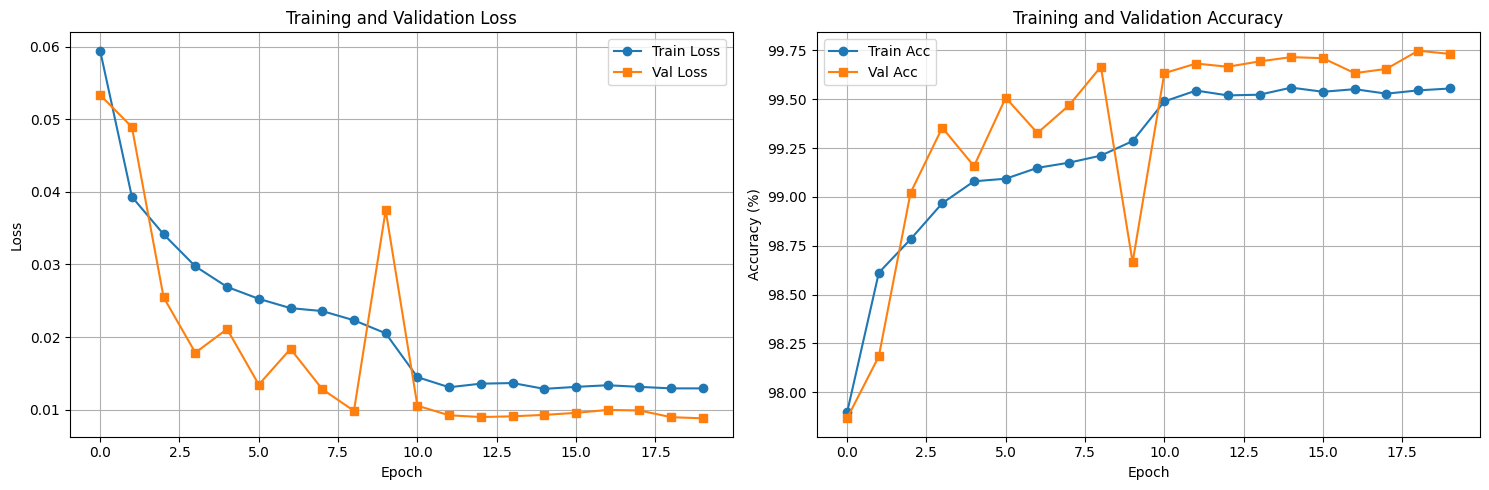

Training history plot saved to: /kaggle/working/models/ResNet50_TransferLearning/training_history.png
  Updated: training_history.png

LOADING BEST MODEL FOR EVALUATION
Loading checkpoint from: /kaggle/working/models/ResNet50_TransferLearning/RESNET50_best_model.pth
 Best model loaded

EVALUATING ON TEST SET

EVALUATING ResNet50_TransferLearning ON TEST DATASET



Testing: 100%|██████████| 715/715 [01:10<00:00, 10.10it/s]



TEST RESULTS - ResNet50_TransferLearning
  Test Loss:      0.0105
  Accuracy:       99.65%
  Precision:      99.76%
  Recall:         99.67%
  F1-Score:       99.71%

  Confusion Matrix:
    TN: 8821  FP: 34
    FN: 46  TP: 13948

Detailed Classification Report:
              precision    recall  f1-score   support

     No_Fire     0.9948    0.9962    0.9955      8855
        Fire     0.9976    0.9967    0.9971     13994

    accuracy                         0.9965     22849
   macro avg     0.9962    0.9964    0.9963     22849
weighted avg     0.9965    0.9965    0.9965     22849



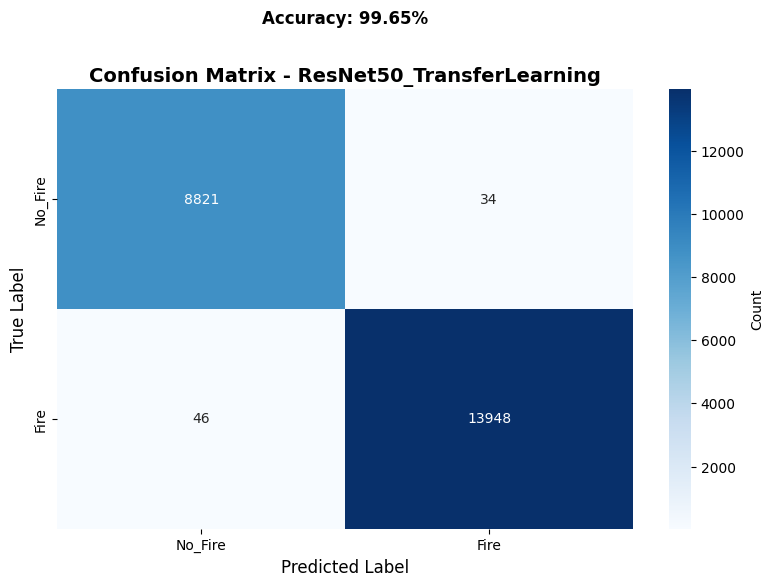

Confusion matrix plot saved to: /kaggle/working/models/ResNet50_TransferLearning/confusion_matrix.png


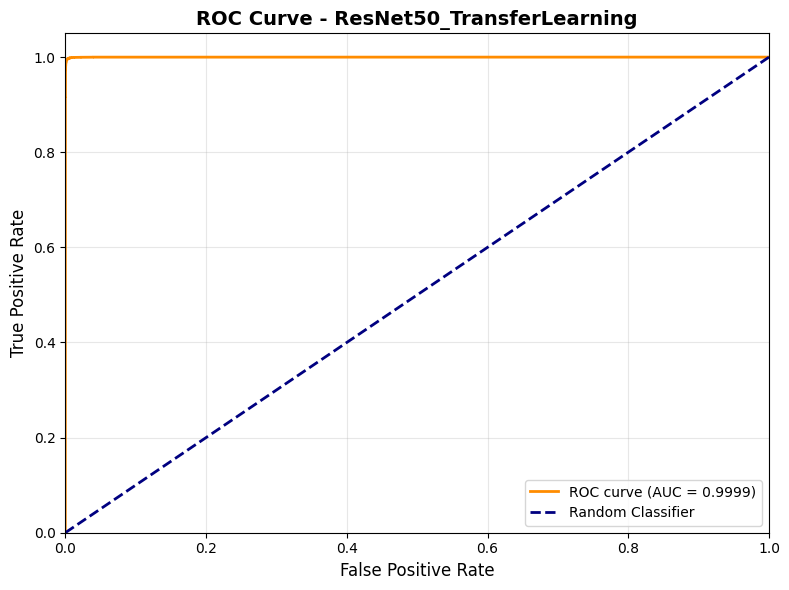

ROC curve plot saved to: /kaggle/working/models/ResNet50_TransferLearning/roc_curve.png
Evaluation results saved to: /kaggle/working/models/ResNet50_TransferLearning/evaluation_results.json

Uploading evaluation results to Google Drive...
  Updated: confusion_matrix.png
  Updated: roc_curve.png
  Updated: evaluation_results.json
  Evaluation results uploaded to Google Drive

EVALUATION COMPLETE - ResNet50_TransferLearning
  Files saved:
    - confusion_matrix.png
    - roc_curve.png
    - evaluation_results.json


  COMPLETED: ResNet50_TransferLearning
  Best Val Acc: 99.75%
  Test Acc: 99.65%



In [ ]:
print("\n\n" + "="*70)
print("STARTING RESNET50")
print("="*70)

history_resnet50, results_resnet50, cm_resnet50 = train_and_evaluate_model(
    model_class=ResNet50TransferLearning,
    model_name='ResNet50_TransferLearning',
    checkpoint_prefix='RESNET50',
    config=config
)

all_results['ResNet50'] = results_resnet50
all_histories['ResNet50'] = history_resnet50
all_checkpoint_managers['ResNet50'] = cm_resnet50

#### **RESUME TRAINING**

In [ ]:
# Step 1: Setup paths and device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
KAGGLE_DATA_PATH = '/kaggle/input/final-dataset/Final_Dataset'
KAGGLE_MODELS_PATH = '/kaggle/working/models'
DRIVE_BASE_FOLDER_NAME = 'Deep Learning Semester Project'

# Step 2: Mount Drive
drive_service = mount_google_drive_kaggle()

# Step 3: Create the model instance
model = ResNet50TransferLearning(num_classes=2)
model = model.to(device)

# Step 4: CREATE CHECKPOINT MANAGER
checkpoint_manager = CheckpointManager(
    model_name='ResNet50_TransferLearning',
    kaggle_dir=KAGGLE_MODELS_PATH,
    drive_service=drive_service,
    drive_base_folder_name=DRIVE_BASE_FOLDER_NAME,
    checkpoint_prefix='RESNET50'
)

# Step 5: Now download the checkpoint
print("Downloading checkpoint from Google Drive...")
success = download_checkpoint_from_drive(
    drive_service=drive_service,
    checkpoint_manager=checkpoint_manager,
    checkpoint_type=10  # or 'latest' or 'best'
)

if success:
    print("  Checkpoint downloaded!")
    
    # Step 6: Configure for resume
    config = {
        'data_path': KAGGLE_DATA_PATH,
        'kaggle_models_path': KAGGLE_MODELS_PATH,
        'drive_service': drive_service,
        'drive_base_folder': DRIVE_BASE_FOLDER_NAME,
        'num_classes': 2,
        'batch_size': 32,
        'num_epochs': 20,
        'learning_rate': 0.001,
        'resume_from': 10  # or 'latest' or 'best'
    }
    
    # Step 7: Resume training
    history, results, cm = train_and_evaluate_model(
        model_class=ResNet50TransferLearning,
        model_name='ResNet50_TransferLearning',
        checkpoint_prefix='RESNET50',
        config=config
    )
else:
    print("  Could not download checkpoint")

### **GOOGLENET**

In [ ]:
print("\n\n" + "="*70)
print("STARTING GOOGLENET")
print("="*70)
    
history_googlenet, results_googlenet, cm_googlenet = train_and_evaluate_model(
    model_class=GoogLeNetTransferLearning,
    model_name='GoogLeNet_TransferLearning',
    checkpoint_prefix='GOOGLENET',
    config=config
)

all_results['GoogLeNet'] = results_googlenet
all_histories['GoogLeNet'] = history_googlenet
all_checkpoint_managers['GoogLeNet'] = cm_googlenet



STARTING GOOGLENET

  TRAINING AND EVALUATING: GoogLeNet_TransferLearning


LOADING DATASETS
Train dataset: 84860 Fire, 28386 No_Fire
Validation dataset: 11183 Fire, 7096 No_Fire
Test dataset: 13994 Fire, 8855 No_Fire
  Datasets loaded successfully

CREATING MODEL


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 189MB/s] 


 Model created: 5,601,954 total params, 2,050 trainable

SETTING UP CHECKPOINT MANAGER

Setting up Google Drive folders for GoogLeNet_TransferLearning...
  Found existing folder: Deep Learning Semester Project
  Found existing folder: models
  Created folder: GoogLeNet_TransferLearning
  Drive folder created: Deep Learning Semester Project/models/GoogLeNet_TransferLearning/

TRAINING MODEL (FROZEN BACKBONE)

   TO STOP TRAINING:
   Click 'Interrupt' button in Kaggle
   OR press Ctrl+C multiple times


TRANSFER LEARNING STRATEGY:
Training final classification layer only (20 epochs)
  - Learning rate: 0.001
  - Backbone: FROZEN (pretrained weights)
  - Only final layer will be trained


TRAINING FINAL LAYER (FROZEN BACKBONE)



Epoch 1 [Val]: 100%|██████████| 572/572 [00:55<00:00, 10.27it/s, loss=0.0410, acc=98.52%]



Epoch 1/20 Summary:
  Train Loss: 0.0782 | Train Acc: 97.28%
  Val Loss: 0.0410 | Val Acc: 98.52%
  Learning Rate: 0.001000

  Saved locally: /kaggle/working/models/GoogLeNet_TransferLearning/GOOGLENET_latest_checkpoint.pth
  Uploaded: GOOGLENET_latest_checkpoint.pth
  New best model saved! Val Acc: 98.52%
  Uploaded: GOOGLENET_best_model.pth


Epoch 2 [Val]: 100%|██████████| 572/572 [00:55<00:00, 10.26it/s, loss=0.0342, acc=98.85%]



Epoch 2/20 Summary:
  Train Loss: 0.0574 | Train Acc: 97.97%
  Val Loss: 0.0342 | Val Acc: 98.85%
  Learning Rate: 0.001000

  Saved locally: /kaggle/working/models/GoogLeNet_TransferLearning/GOOGLENET_latest_checkpoint.pth
  Updated: GOOGLENET_latest_checkpoint.pth
  New best model saved! Val Acc: 98.85%
  Updated: GOOGLENET_best_model.pth


Epoch 3 [Val]: 100%|██████████| 572/572 [00:54<00:00, 10.53it/s, loss=0.0299, acc=98.93%]



Epoch 3/20 Summary:
  Train Loss: 0.0563 | Train Acc: 97.96%
  Val Loss: 0.0299 | Val Acc: 98.93%
  Learning Rate: 0.001000

  Saved locally: /kaggle/working/models/GoogLeNet_TransferLearning/GOOGLENET_latest_checkpoint.pth
  Updated: GOOGLENET_latest_checkpoint.pth
  New best model saved! Val Acc: 98.93%
  Updated: GOOGLENET_best_model.pth


Epoch 4 [Val]: 100%|██████████| 572/572 [00:54<00:00, 10.49it/s, loss=0.0314, acc=98.81%]



Epoch 4/20 Summary:
  Train Loss: 0.0566 | Train Acc: 97.99%
  Val Loss: 0.0314 | Val Acc: 98.81%
  Learning Rate: 0.001000

  Saved locally: /kaggle/working/models/GoogLeNet_TransferLearning/GOOGLENET_latest_checkpoint.pth
  Updated: GOOGLENET_latest_checkpoint.pth


Epoch 5 [Val]: 100%|██████████| 572/572 [00:55<00:00, 10.38it/s, loss=0.0296, acc=98.92%]



Epoch 5/20 Summary:
  Train Loss: 0.0572 | Train Acc: 97.93%
  Val Loss: 0.0296 | Val Acc: 98.92%
  Learning Rate: 0.001000

  Saved locally: /kaggle/working/models/GoogLeNet_TransferLearning/GOOGLENET_latest_checkpoint.pth
  Updated: GOOGLENET_latest_checkpoint.pth
  Uploaded: checkpoint_epoch_5.pth


Epoch 6 [Val]: 100%|██████████| 572/572 [00:55<00:00, 10.25it/s, loss=0.0314, acc=98.91%]



Epoch 6/20 Summary:
  Train Loss: 0.0573 | Train Acc: 97.94%
  Val Loss: 0.0314 | Val Acc: 98.91%
  Learning Rate: 0.001000

  Saved locally: /kaggle/working/models/GoogLeNet_TransferLearning/GOOGLENET_latest_checkpoint.pth
  Updated: GOOGLENET_latest_checkpoint.pth


Epoch 7 [Val]: 100%|██████████| 572/572 [00:57<00:00, 10.01it/s, loss=0.0266, acc=98.98%]



Epoch 7/20 Summary:
  Train Loss: 0.0563 | Train Acc: 97.99%
  Val Loss: 0.0266 | Val Acc: 98.98%
  Learning Rate: 0.001000

  Saved locally: /kaggle/working/models/GoogLeNet_TransferLearning/GOOGLENET_latest_checkpoint.pth
  Updated: GOOGLENET_latest_checkpoint.pth
  New best model saved! Val Acc: 98.98%
  Updated: GOOGLENET_best_model.pth


Epoch 8 [Val]: 100%|██████████| 572/572 [00:56<00:00, 10.19it/s, loss=0.0286, acc=98.91%]



Epoch 8/20 Summary:
  Train Loss: 0.0557 | Train Acc: 98.03%
  Val Loss: 0.0286 | Val Acc: 98.91%
  Learning Rate: 0.001000

  Saved locally: /kaggle/working/models/GoogLeNet_TransferLearning/GOOGLENET_latest_checkpoint.pth
  Updated: GOOGLENET_latest_checkpoint.pth


Epoch 9 [Val]: 100%|██████████| 572/572 [00:55<00:00, 10.27it/s, loss=0.0252, acc=99.02%]



Epoch 9/20 Summary:
  Train Loss: 0.0562 | Train Acc: 97.98%
  Val Loss: 0.0252 | Val Acc: 99.02%
  Learning Rate: 0.001000

  Saved locally: /kaggle/working/models/GoogLeNet_TransferLearning/GOOGLENET_latest_checkpoint.pth
  Updated: GOOGLENET_latest_checkpoint.pth
  New best model saved! Val Acc: 99.02%
  Updated: GOOGLENET_best_model.pth


Epoch 10 [Val]: 100%|██████████| 572/572 [00:53<00:00, 10.59it/s, loss=0.0264, acc=99.05%]



Epoch 10/20 Summary:
  Train Loss: 0.0569 | Train Acc: 98.00%
  Val Loss: 0.0264 | Val Acc: 99.05%
  Learning Rate: 0.000100

  Saved locally: /kaggle/working/models/GoogLeNet_TransferLearning/GOOGLENET_latest_checkpoint.pth
  Updated: GOOGLENET_latest_checkpoint.pth
  New best model saved! Val Acc: 99.05%
  Updated: GOOGLENET_best_model.pth
  Uploaded: checkpoint_epoch_10.pth


Epoch 11 [Val]: 100%|██████████| 572/572 [00:55<00:00, 10.34it/s, loss=0.0277, acc=99.01%]



Epoch 11/20 Summary:
  Train Loss: 0.0526 | Train Acc: 98.11%
  Val Loss: 0.0277 | Val Acc: 99.01%
  Learning Rate: 0.000100

  Saved locally: /kaggle/working/models/GoogLeNet_TransferLearning/GOOGLENET_latest_checkpoint.pth
  Updated: GOOGLENET_latest_checkpoint.pth


Epoch 12 [Train]:  52%|█████▏    | 1836/3539 [02:50<02:50,  9.99it/s, loss=0.0273, acc=98.16%]

#### **RESUME TRAINING**

In [ ]:
# Step 1: Setup paths and device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
KAGGLE_DATA_PATH = '/kaggle/input/final-dataset/Final_Dataset'
KAGGLE_MODELS_PATH = '/kaggle/working/models'
DRIVE_BASE_FOLDER_NAME = 'Deep Learning Semester Project'

# Step 2: Mount Drive
drive_service = mount_google_drive_kaggle()

# Step 3: Create the model instance
model = GoogLeNetTransferLearning(num_classes=2)
model = model.to(device)

# Step 4: CREATE CHECKPOINT MANAGER
checkpoint_manager = CheckpointManager(
    model_name='GoogLeNet_TransferLearning',
    kaggle_dir=KAGGLE_MODELS_PATH,
    drive_service=drive_service,
    drive_base_folder_name=DRIVE_BASE_FOLDER_NAME,
    checkpoint_prefix='GOOGLENET'
)

# Step 5: Now download the checkpoint
print("Downloading checkpoint from Google Drive...")
success = download_checkpoint_from_drive(
    drive_service=drive_service,
    checkpoint_manager=checkpoint_manager,
    checkpoint_type=10  # or 'latest' or 'best'
)

if success:
    print("  Checkpoint downloaded!")
    
    # Step 6: Configure for resume
    config = {
        'data_path': KAGGLE_DATA_PATH,
        'kaggle_models_path': KAGGLE_MODELS_PATH,
        'drive_service': drive_service,
        'drive_base_folder': DRIVE_BASE_FOLDER_NAME,
        'num_classes': 2,
        'batch_size': 32,
        'num_epochs': 20,
        'learning_rate': 0.001,
        'resume_from': 10  # or 'latest' or 'best'
    }
    
    # Step 7: Resume training
    history, results, cm = train_and_evaluate_model(
        model_class=GoogLeNetTransferLearning,
        model_name='GoogLeNet_TransferLearning',
        checkpoint_prefix='GOOGLENET',
        config=config
    )
else:
    print("  Could not download checkpoint")


MOUNTING GOOGLE DRIVE (KAGGLE):
Loading authentication token...
Testing connection...
Google Drive mounted successfully via OAuth!
Full read/write access enabled

Setting up Google Drive folders for GoogLeNet_TransferLearning...
  Found existing folder: Deep Learning Semester Project
  Found existing folder: models
  Found existing folder: GoogLeNet_TransferLearning
  Drive folder created: Deep Learning Semester Project/models/GoogLeNet_TransferLearning/

DOWNLOADING CHECKPOINT FROM GOOGLE DRIVE

  Downloaded: checkpoint_epoch_10.pth
  Checkpoint downloaded: checkpoint_epoch_10.pth
  Checkpoint downloaded!

  TRAINING AND EVALUATING: GoogLeNet_TransferLearning


LOADING DATASETS
Train dataset: 84860 Fire, 28386 No_Fire
Validation dataset: 11183 Fire, 7096 No_Fire
Test dataset: 13994 Fire, 8855 No_Fire
  Datasets loaded successfully

CREATING MODEL
 Model created: 5,601,954 total params, 2,050 trainable

SETTING UP CHECKPOINT MANAGER

Setting up Google Drive folders for GoogLeNet_Trans

Epoch 11 [Val]: 100%|██████████| 572/572 [00:56<00:00, 10.07it/s, loss=0.0273, acc=99.00%]



Epoch 11/20 Summary:
  Train Loss: 0.0524 | Train Acc: 98.16%
  Val Loss: 0.0273 | Val Acc: 99.00%
  Learning Rate: 0.000010

  Saved locally: /kaggle/working/models/GoogLeNet_TransferLearning/GOOGLENET_latest_checkpoint.pth
  Updated: GOOGLENET_latest_checkpoint.pth


Epoch 12 [Val]: 100%|██████████| 572/572 [00:58<00:00,  9.82it/s, loss=0.0294, acc=98.98%]



Epoch 12/20 Summary:
  Train Loss: 0.0529 | Train Acc: 98.11%
  Val Loss: 0.0294 | Val Acc: 98.98%
  Learning Rate: 0.000010

  Saved locally: /kaggle/working/models/GoogLeNet_TransferLearning/GOOGLENET_latest_checkpoint.pth
  Updated: GOOGLENET_latest_checkpoint.pth


Epoch 13 [Val]: 100%|██████████| 572/572 [00:57<00:00,  9.99it/s, loss=0.0266, acc=99.05%]



Epoch 13/20 Summary:
  Train Loss: 0.0541 | Train Acc: 98.07%
  Val Loss: 0.0266 | Val Acc: 99.05%
  Learning Rate: 0.000010

  Saved locally: /kaggle/working/models/GoogLeNet_TransferLearning/GOOGLENET_latest_checkpoint.pth
  Updated: GOOGLENET_latest_checkpoint.pth


Epoch 14 [Val]: 100%|██████████| 572/572 [00:57<00:00,  9.99it/s, loss=0.0267, acc=99.04%]



Epoch 14/20 Summary:
  Train Loss: 0.0518 | Train Acc: 98.14%
  Val Loss: 0.0267 | Val Acc: 99.04%
  Learning Rate: 0.000010

  Saved locally: /kaggle/working/models/GoogLeNet_TransferLearning/GOOGLENET_latest_checkpoint.pth
  Updated: GOOGLENET_latest_checkpoint.pth


Epoch 15 [Val]: 100%|██████████| 572/572 [00:55<00:00, 10.24it/s, loss=0.0288, acc=98.97%]



Epoch 15/20 Summary:
  Train Loss: 0.0518 | Train Acc: 98.16%
  Val Loss: 0.0288 | Val Acc: 98.97%
  Learning Rate: 0.000010

  Saved locally: /kaggle/working/models/GoogLeNet_TransferLearning/GOOGLENET_latest_checkpoint.pth
  Updated: GOOGLENET_latest_checkpoint.pth
  Updated: checkpoint_epoch_15.pth


Epoch 16 [Train]:  91%|█████████ | 3210/3539 [05:08<00:32, 10.20it/s, loss=0.0461, acc=98.18%]


MOUNTING GOOGLE DRIVE (KAGGLE):
Loading authentication token...
Testing connection...
Google Drive mounted successfully via OAuth!
Full read/write access enabled

Setting up Google Drive folders for GoogLeNet_TransferLearning...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  Found existing folder: Deep Learning Semester Project
  Found existing folder: models
  Found existing folder: GoogLeNet_TransferLearning
  Drive folder created: Deep Learning Semester Project/models/GoogLeNet_TransferLearning/

DOWNLOADING CHECKPOINT FROM GOOGLE DRIVE

  Downloaded: checkpoint_epoch_15.pth
  Checkpoint downloaded: checkpoint_epoch_15.pth
  Checkpoint downloaded!

  TRAINING AND EVALUATING: GoogLeNet_TransferLearning


LOADING DATASETS
Train dataset: 84860 Fire, 28386 No_Fire
Validation dataset: 11183 Fire, 7096 No_Fire
Test dataset: 13994 Fire, 8855 No_Fire
  Datasets loaded successfully

CREATING MODEL
 Model created: 5,601,954 total params, 2,050 trainable

SETTING UP CHECKPOINT MANAGER

Setting up Google Drive folders for GoogLeNet_TransferLearning...
  Found existing folder: Deep Learning Semester Project
  Found existing folder: models


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


  Found existing folder: GoogLeNet_TransferLearning
  Drive folder created: Deep Learning Semester Project/models/GoogLeNet_TransferLearning/

TRAINING MODEL (FROZEN BACKBONE)

   TO STOP TRAINING:
   Click 'Interrupt' button in Kaggle
   OR press Ctrl+C multiple times


RESUMING TRAINING FROM: 15

Loading checkpoint from: /kaggle/working/models/GoogLeNet_TransferLearning/checkpoint_epoch_15.pth
  Checkpoint loaded successfully!
  Resuming from epoch: 15
  Previous best val acc: 99.05%

TRANSFER LEARNING STRATEGY:
Training final classification layer only (20 epochs)
  - Learning rate: 0.001
  - Backbone: FROZEN (pretrained weights)
  - Only final layer will be trained

   Resuming from epoch 16


TRAINING FINAL LAYER (FROZEN BACKBONE)

Loading checkpoint from: /kaggle/working/models/GoogLeNet_TransferLearning/checkpoint_epoch_15.pth


Epoch 16 [Val]: 100%|██████████| 572/572 [00:57<00:00, 10.00it/s, loss=0.0286, acc=99.01%]



Epoch 16/20 Summary:
  Train Loss: 0.0512 | Train Acc: 98.18%
  Val Loss: 0.0286 | Val Acc: 99.01%
  Learning Rate: 0.000001

  Saved locally: /kaggle/working/models/GoogLeNet_TransferLearning/GOOGLENET_latest_checkpoint.pth
  Updated: GOOGLENET_latest_checkpoint.pth


Epoch 17 [Val]: 100%|██████████| 572/572 [00:55<00:00, 10.26it/s, loss=0.0259, acc=99.04%]



Epoch 17/20 Summary:
  Train Loss: 0.0522 | Train Acc: 98.13%
  Val Loss: 0.0259 | Val Acc: 99.04%
  Learning Rate: 0.000001

  Saved locally: /kaggle/working/models/GoogLeNet_TransferLearning/GOOGLENET_latest_checkpoint.pth
  Updated: GOOGLENET_latest_checkpoint.pth


Epoch 18 [Val]: 100%|██████████| 572/572 [00:55<00:00, 10.24it/s, loss=0.0286, acc=99.00%]



Epoch 18/20 Summary:
  Train Loss: 0.0518 | Train Acc: 98.14%
  Val Loss: 0.0286 | Val Acc: 99.00%
  Learning Rate: 0.000001

  Saved locally: /kaggle/working/models/GoogLeNet_TransferLearning/GOOGLENET_latest_checkpoint.pth
  Updated: GOOGLENET_latest_checkpoint.pth


Epoch 19 [Val]: 100%|██████████| 572/572 [00:57<00:00,  9.99it/s, loss=0.0289, acc=98.99%]



Epoch 19/20 Summary:
  Train Loss: 0.0518 | Train Acc: 98.18%
  Val Loss: 0.0289 | Val Acc: 98.99%
  Learning Rate: 0.000001

  Saved locally: /kaggle/working/models/GoogLeNet_TransferLearning/GOOGLENET_latest_checkpoint.pth
  Updated: GOOGLENET_latest_checkpoint.pth


Epoch 20 [Val]: 100%|██████████| 572/572 [00:58<00:00,  9.75it/s, loss=0.0254, acc=99.10%]



Epoch 20/20 Summary:
  Train Loss: 0.0522 | Train Acc: 98.16%
  Val Loss: 0.0254 | Val Acc: 99.10%
  Learning Rate: 0.000000

  Saved locally: /kaggle/working/models/GoogLeNet_TransferLearning/GOOGLENET_latest_checkpoint.pth
  Updated: GOOGLENET_latest_checkpoint.pth
  New best model saved! Val Acc: 99.10%
  Updated: GOOGLENET_best_model.pth
  Updated: checkpoint_epoch_20.pth

  TRAINING COMPLETED SUCCESSFULLY!



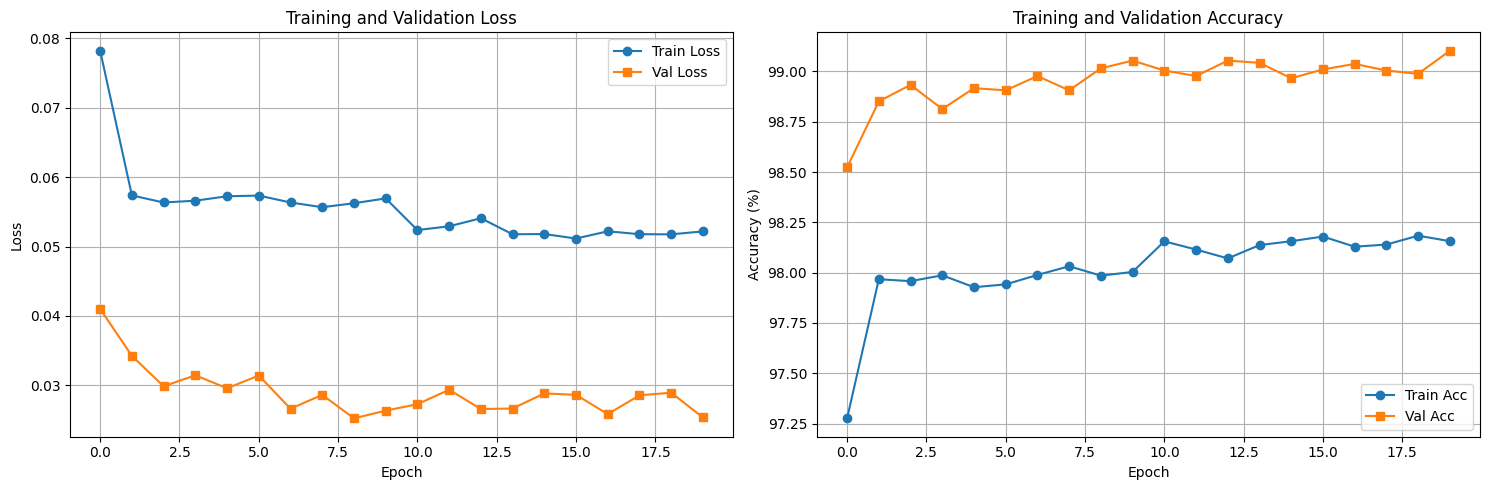

Training history plot saved to: /kaggle/working/models/GoogLeNet_TransferLearning/training_history.png
  Updated: training_history.png

LOADING BEST MODEL FOR EVALUATION
Loading checkpoint from: /kaggle/working/models/GoogLeNet_TransferLearning/GOOGLENET_best_model.pth
 Best model loaded

EVALUATING ON TEST SET

EVALUATING GoogLeNet_TransferLearning ON TEST DATASET



Testing: 100%|██████████| 715/715 [01:10<00:00, 10.12it/s]



TEST RESULTS - GoogLeNet_TransferLearning
  Test Loss:      0.0271
  Accuracy:       99.01%
  Precision:      98.79%
  Recall:         99.60%
  F1-Score:       99.19%

  Confusion Matrix:
    TN: 8684  FP: 171
    FN: 56  TP: 13938

Detailed Classification Report:
              precision    recall  f1-score   support

     No_Fire     0.9936    0.9807    0.9871      8855
        Fire     0.9879    0.9960    0.9919     13994

    accuracy                         0.9901     22849
   macro avg     0.9907    0.9883    0.9895     22849
weighted avg     0.9901    0.9901    0.9901     22849



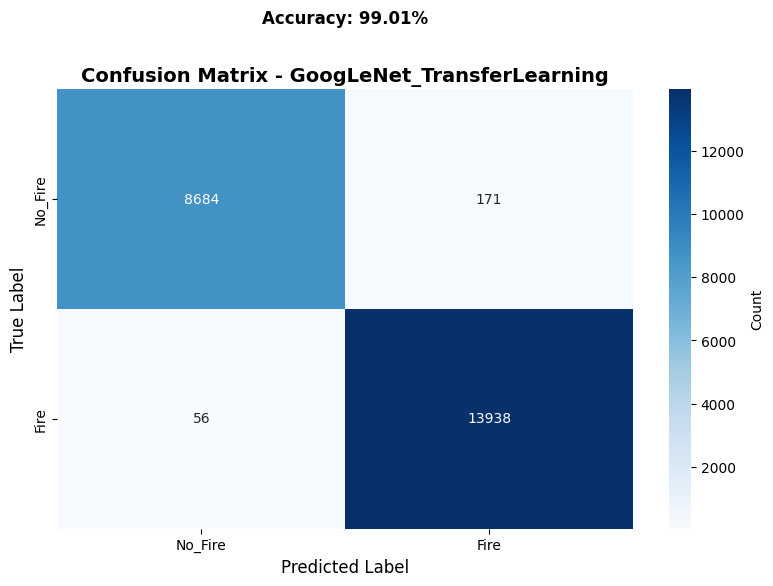

Confusion matrix plot saved to: /kaggle/working/models/GoogLeNet_TransferLearning/confusion_matrix.png


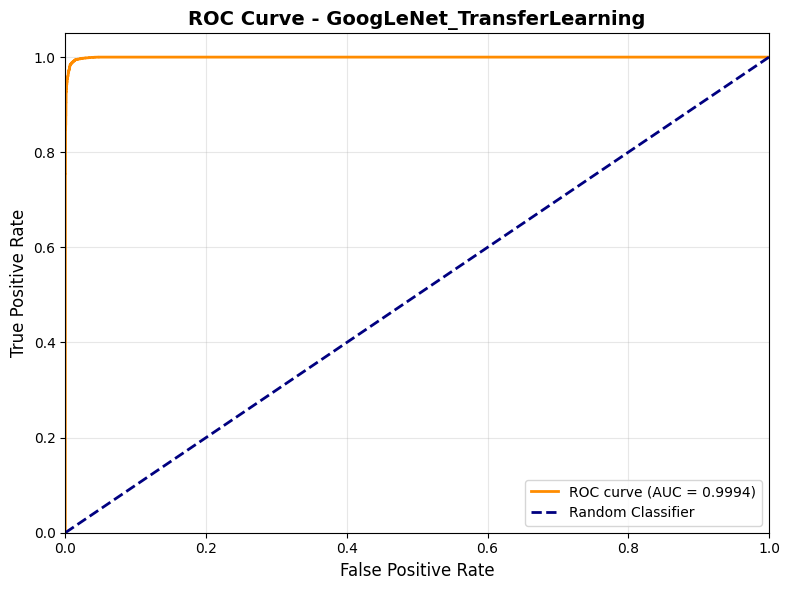

ROC curve plot saved to: /kaggle/working/models/GoogLeNet_TransferLearning/roc_curve.png
Evaluation results saved to: /kaggle/working/models/GoogLeNet_TransferLearning/evaluation_results.json

Uploading evaluation results to Google Drive...
  Updated: confusion_matrix.png
  Updated: roc_curve.png
  Updated: evaluation_results.json
  Evaluation results uploaded to Google Drive

EVALUATION COMPLETE - GoogLeNet_TransferLearning
  Files saved:
    - confusion_matrix.png
    - roc_curve.png
    - evaluation_results.json


  COMPLETED: GoogLeNet_TransferLearning
  Best Val Acc: 99.10%
  Test Acc: 99.01%



In [ ]:
# Step 1: Setup paths and device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
KAGGLE_DATA_PATH = '/kaggle/input/final-dataset/Final_Dataset'
KAGGLE_MODELS_PATH = '/kaggle/working/models'
DRIVE_BASE_FOLDER_NAME = 'Deep Learning Semester Project'

# Step 2: Mount Drive
drive_service = mount_google_drive_kaggle()

# Step 3: Create the model instance
model = GoogLeNetTransferLearning(num_classes=2)
model = model.to(device)

# Step 4: CREATE CHECKPOINT MANAGER
checkpoint_manager = CheckpointManager(
    model_name='GoogLeNet_TransferLearning',
    kaggle_dir=KAGGLE_MODELS_PATH,
    drive_service=drive_service,
    drive_base_folder_name=DRIVE_BASE_FOLDER_NAME,
    checkpoint_prefix='GOOGLENET'
)

# Step 5: Now download the checkpoint
print("Downloading checkpoint from Google Drive...")
success = download_checkpoint_from_drive(
    drive_service=drive_service,
    checkpoint_manager=checkpoint_manager,
    checkpoint_type=15  # or 'latest' or 'best'
)

if success:
    print("  Checkpoint downloaded!")
    
    # Step 6: Configure for resume
    config = {
        'data_path': KAGGLE_DATA_PATH,
        'kaggle_models_path': KAGGLE_MODELS_PATH,
        'drive_service': drive_service,
        'drive_base_folder': DRIVE_BASE_FOLDER_NAME,
        'num_classes': 2,
        'batch_size': 32,
        'num_epochs': 20,
        'learning_rate': 0.001,
        'resume_from': 15  # or 'latest' or 'best'
    }
    
    # Step 7: Resume training
    history, results, cm = train_and_evaluate_model(
        model_class=GoogLeNetTransferLearning,
        model_name='GoogLeNet_TransferLearning',
        checkpoint_prefix='GOOGLENET',
        config=config
    )
else:
    print("  Could not download checkpoint")

# **HYBRID QUANTUM CLASSICAL DEEP LEARNING APPROACHES**

## **Approach 1: Hard-Mining Hybrid VQC**

This approach positions the quantum model as a **"Logic Specialist"** designed to resolve high-uncertainty edge cases that confuse classical models.

### **Core Architecture**
1.  **The Sieve (Classical ResNet-18):** A standard ResNet-18 acts as the primary filter, handling the majority of "easy" classifications with high speed.
2.  **Hard Example Mining:** Using **Shannon Entropy** as a metric for uncertainty, the system identifies the top **20,000 most difficult images** (e.g., ambiguous smoke/cloud boundaries) from the full dataset.
3.  **Quantum Specialist (VQC):** A **4-qubit Variational Quantum Circuit** is trained exclusively on this hard subset. It uses `StronglyEntanglingLayers` to map these complex decision boundaries into a higher-dimensional Hilbert space.

### **Phased Execution Strategy**
* **Phase 1 (Classical Training):** Train ResNet-18 on the full dataset (114k images) to establish a baseline.
* **Phase 2 (Mining):** Calculate entropy for all training samples and extract the `Hard_Subset_20k`.
* **Phase 3 (Quantum Training):** Freeze the ResNet backbone and train the VQC solely on the hard subset.

**Goal:** Test the hypothesis that quantum entanglement can disentangle complex decision boundaries where classical linear separation fails.

### **Set device with Lightning GPU support**

In [ ]:
def setup_device(use_lightning=True):
    """Setup device with Lightning GPU support."""
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"Using CUDA GPU: {torch.cuda.get_device_name(0)}")
    else:
        device = torch.device('cpu')
        print("Using CPU")
    
    if use_lightning and torch.cuda.is_available():
        try:
            import pennylane_lightning
            print("Lightning GPU support enabled for quantum circuits")
            return device, 'lightning.gpu'
        except ImportError:
            print("Lightning GPU not available, using default simulator")
            return device, 'default.qubit'
    
    return device, 'default.qubit'

device, qml_device_type = setup_device(use_lightning=True)

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Using CUDA GPU: Tesla P100-PCIE-16GB
Lightning GPU support enabled for quantum circuits


### **DATASET CLASS FOR QUANTUM APPROACH 1**

In [ ]:
class FireDatasetApproach1(Dataset):
    """Standard dataset for wildfire classification."""
    
    def __init__(self, data_dir, split='train'):
        self.split = split
        self.imagenet_mean = np.array([0.485, 0.456, 0.406])
        self.imagenet_std = np.array([0.229, 0.224, 0.225])
        
        fire_dir = os.path.join(data_dir, split, 'Fire')
        nofire_dir = os.path.join(data_dir, split, 'No_Fire')
        
        self.fire_files = sorted([os.path.join(fire_dir, f) 
                                 for f in os.listdir(fire_dir) if f.endswith('.jpg')])
        self.nofire_files = sorted([os.path.join(nofire_dir, f) 
                                   for f in os.listdir(nofire_dir) if f.endswith('.jpg')])
        
        self.image_files = self.fire_files + self.nofire_files
        self.labels = [1] * len(self.fire_files) + [0] * len(self.nofire_files)
        
        print(f"  {split}: {len(self.fire_files)} Fire, {len(self.nofire_files)} No_Fire")
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.image_files[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        image = image.astype(np.float32) / 255.0
        image = (image - self.imagenet_mean) / self.imagenet_std
        
        label = self.labels[idx]
        image = torch.FloatTensor(image).permute(2, 0, 1)
        label = torch.LongTensor([label])[0]
        
        return image, label

### **PHASE 1: CLASSICAL BACKBONE MODEL**

In [ ]:
class ClassicalBackbone(nn.Module):
    """ResNet-18 for Phase 1: The Sieve"""
    
    def __init__(self, num_classes=2):
        super(ClassicalBackbone, self).__init__()
        resnet = models.resnet18(pretrained=True)
        
        # Keep all layers except final fc
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        
        # New classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
        print("  Classical Backbone (ResNet-18) initialized")
    
    def forward(self, x, return_features=False):
        features = self.features(x)  # [batch, 512, 1, 1]
        features_flat = features.view(features.size(0), -1)  # [batch, 512]
        
        if return_features:
            return features_flat
        
        logits = self.classifier(features_flat)
        return logits

### **PHASE 3: HYBRID QUANTUM MODEL**

In [ ]:
# Quantum circuit with Adjoint Differentiation
n_qubits = 4
dev_vqc = qml.device("default.qubit", wires=n_qubits)
# dev_vqc = qml.device(qml_device_type, wires=n_qubits)

@qml.qnode(dev_vqc, interface="torch", diff_method="adjoint")
def variational_quantum_classifier(inputs, weights):
    """
    VQC with StronglyEntanglingLayers (3 layers).
    Uses Adjoint differentiation for O(1) gradient scaling.
    """
    # Angle encoding
    for i in range(n_qubits):
        qml.RY(inputs[i], wires=i)
    
    # Strongly entangling layers (3 layers as per spec)
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    
    # Measurements
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]


class HybridQuantumClassifier(nn.Module):
    """
    Hybrid model: Classical backbone + Quantum VQC
    For Phase 3: Training on hard examples
    """
    
    def __init__(self, classical_backbone):
        super(HybridQuantumClassifier, self).__init__()
        
        # Use frozen classical backbone
        self.backbone = classical_backbone
        for param in self.backbone.parameters():
            param.requires_grad = False
        
        # Dimensionality reduction: 512 → 4
        self.feature_reducer = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 4),
            nn.Tanh()
        )
        
        # Quantum VQC weights: 3 layers of StronglyEntanglingLayers
        # Shape: (n_layers, n_qubits, 3) for StronglyEntanglingLayers
        n_layers = 3
        self.quantum_weights = nn.Parameter(
            torch.randn(n_layers, n_qubits, 3) * 0.1
        )
        
        # Final classifier from quantum measurements
        self.output_layer = nn.Linear(n_qubits, 2)
        
        print("  Hybrid Quantum Classifier initialized")
        print(f"  Quantum: 4 qubits, 3 StronglyEntangling layers, Adjoint diff")
    
    def forward(self, x):
        # Extract features from frozen backbone
        with torch.no_grad():
            features = self.backbone(x, return_features=True)  # [batch, 512]
        
        # Reduce to 4 dimensions
        reduced = self.feature_reducer(features)  # [batch, 4]
        
        # Process through quantum circuit
        batch_size = reduced.shape[0]
        quantum_out = torch.zeros(batch_size, n_qubits, device=x.device)
        
        for i in range(batch_size):
            q_result = variational_quantum_classifier(reduced[i], self.quantum_weights)
            quantum_out[i] = torch.stack(q_result)
        
        # Final classification
        logits = self.output_layer(quantum_out)
        return logits

### **CHECKPOINT MANAGER FOR KAGGLE**

In [ ]:
class CheckpointManager:
    """Manages checkpoints with Drive integration."""
    
    def __init__(self, model_name, kaggle_dir, drive_service, 
                 drive_base_folder_name, checkpoint_prefix):
        self.model_name = model_name
        self.checkpoint_prefix = checkpoint_prefix
        self.kaggle_dir = os.path.join(kaggle_dir, model_name)
        self.drive_service = drive_service
        self.drive_folder_id = None
        self.best_val_acc = 0.0
        
        os.makedirs(self.kaggle_dir, exist_ok=True)
        
        if drive_service:
            print(f"\nSetting up Google Drive folders...")
            try:
                from __main__ import find_or_create_folder
                base_folder_id = find_or_create_folder(drive_service, drive_base_folder_name)
                models_folder_id = find_or_create_folder(drive_service, 'models', base_folder_id)
                self.drive_folder_id = find_or_create_folder(drive_service, model_name, models_folder_id)
                print(f"  Drive: {drive_base_folder_name}/models/{model_name}/")
            except Exception as e:
                print(f"  Warning: Could not create Drive folders: {e}")
    
    def save_checkpoint(self, epoch, model, optimizer, train_loss, train_acc,
                       val_loss, val_acc, history, is_best=False, phase=''):
        """Save checkpoint locally and to Drive."""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'history': history,
            'best_val_acc': self.best_val_acc,
            'phase': phase
        }
        
        # Save latest
        latest_name = f'{self.checkpoint_prefix}_{phase}_latest.pth'
        latest_path = os.path.join(self.kaggle_dir, latest_name)
        torch.save(checkpoint, latest_path)
        print(f"  Saved: {latest_name}")
        
        # Upload to Drive
        if self.drive_service and self.drive_folder_id:
            try:
                from __main__ import upload_file_to_drive
                upload_file_to_drive(self.drive_service, latest_path, 
                                   self.drive_folder_id, latest_name)
            except Exception as e:
                print(f"  Warning: Upload failed: {e}")
        
        # Save best
        if is_best:
            best_name = f'{self.checkpoint_prefix}_{phase}_best.pth'
            best_path = os.path.join(self.kaggle_dir, best_name)
            torch.save(checkpoint, best_path)
            print(f"  NEW BEST! Val Acc: {val_acc:.2f}%")
            
            if self.drive_service and self.drive_folder_id:
                try:
                    from __main__ import upload_file_to_drive
                    upload_file_to_drive(self.drive_service, best_path,
                                       self.drive_folder_id, best_name)
                except Exception as e:
                    print(f"  Warning: Best upload failed: {e}")
    
    def load_checkpoint(self, model, optimizer, checkpoint_type='latest', phase=''):
        """Load checkpoint from Drive first, then local."""
        filename = f'{self.checkpoint_prefix}_{phase}_{checkpoint_type}.pth'
        local_path = os.path.join(self.kaggle_dir, filename)
        
        # Try downloading from Drive first
        if self.drive_service and self.drive_folder_id:
            try:
                from __main__ import download_file_from_drive
                query = f"name='{filename}' and '{self.drive_folder_id}' in parents and trashed=false"
                results = self.drive_service.files().list(q=query, fields='files(id, name)').execute()
                files = results.get('files', [])
                
                if files:
                    print(f"  Downloading from Drive: {filename}")
                    download_file_from_drive(self.drive_service, files[0]['id'], local_path)
            except Exception as e:
                print(f"  Warning: Drive download failed: {e}")
        
        # Load from local
        if os.path.exists(local_path):
            print(f"  Loading: {filename}")
            checkpoint = torch.load(local_path, map_location=device)
            model.load_state_dict(checkpoint['model_state_dict'])
            if optimizer:
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.best_val_acc = checkpoint.get('best_val_acc', 0.0)
            return checkpoint['epoch'], checkpoint.get('history', {})
        else:
            print(f"  No checkpoint found: {filename}")
            return 0, {}

### **PHASE 1: TRAIN CLASSICAL BACKBONE**

In [ ]:
def train_classical_backbone_phase1(data_path, checkpoint_manager, num_epochs=30,
                                    batch_size=32, learning_rate=0.001,
                                    resume_from=None):
    """
    Phase 1: Train ResNet-18 on full dataset (The Sieve).
    Goal: ~95% accuracy baseline classifier.
    """
    print("\n" + "="*70)
    print("PHASE 1: TRAINING CLASSICAL BACKBONE (THE SIEVE)")
    print("="*70)
    print(f"Training ResNet-18 for {num_epochs} epochs on FULL dataset")
    print("Goal: Achieve ~95% accuracy baseline\n")
    
    # Load datasets
    print("Loading datasets...")
    train_dataset = FireDatasetApproach1(data_path, split='train')
    val_dataset = FireDatasetApproach1(data_path, split='validation')
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                             shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size,
                           shuffle=False, num_workers=2, pin_memory=True)
    
    # Create model
    model = ClassicalBackbone(num_classes=2)
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    start_epoch = 0
    best_val_acc = 0.0
    
    # Resume if specified
    if resume_from:
        start_epoch, history = checkpoint_manager.load_checkpoint(
            model, optimizer, checkpoint_type=resume_from, phase='phase1'
        )
        best_val_acc = checkpoint_manager.best_val_acc
        for _ in range(start_epoch):
            scheduler.step()
    
    print("\nStarting training...\n")
    
    early_stop_counter = 0
    early_stop_patience = 5
    
    for epoch in range(start_epoch, num_epochs):
        # Train
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            pbar.set_postfix({
                'loss': f'{train_loss/len(pbar):.4f}',
                'acc': f'{100*train_correct/train_total:.2f}%'
            })
        
        train_loss /= len(train_loader)
        train_acc = 100 * train_correct / train_total
        
        # Validate
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            for images, labels in pbar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
                pbar.set_postfix({
                    'loss': f'{val_loss/len(pbar):.4f}',
                    'acc': f'{100*val_correct/val_total:.2f}%'
                })
        
        val_loss /= len(val_loader)
        val_acc = 100 * val_correct / val_total
        scheduler.step()
        
        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"\nEpoch {epoch+1}/{num_epochs}:")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        
        # Save checkpoint
        is_best = val_acc > best_val_acc
        if is_best:
            best_val_acc = val_acc
            checkpoint_manager.best_val_acc = best_val_acc
            early_stop_counter = 0
        else:
            early_stop_counter += 1
        
        checkpoint_manager.save_checkpoint(
            epoch + 1, model, optimizer, train_loss, train_acc,
            val_loss, val_acc, history, is_best=is_best, phase='phase1'
        )
        
        # Early stopping
        if early_stop_counter >= early_stop_patience:
            print(f"\nEarly stopping triggered! No improvement for {early_stop_patience} epochs.")
            break
    
    print("\n" + "="*70)
    print("PHASE 1 COMPLETE!")
    print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
    print("="*70 + "\n")
    
    return model, history

### **PHASE 2: MINE HARD EXAMPLES**

In [ ]:
def mine_hard_examples_phase2(model, data_path, checkpoint_manager, 
                              top_k=20000):
    """
    Phase 2: Identify hardest examples using entropy (The Filter).
    Selects top-K images where model is most uncertain.
    """
    print("\n" + "="*70)
    print("PHASE 2: MINING HARD EXAMPLES (THE FILTER)")
    print("="*70)
    print(f"Identifying top-{top_k} hardest images using entropy\n")
    
    # Load training dataset
    train_dataset = FireDatasetApproach1(data_path, split='train')
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=2)
    
    model.eval()
    all_entropies = []
    all_indices = []
    
    print("Computing entropy for all training images...")
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(tqdm(train_loader, desc="Computing entropy")):
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            
            # Calculate entropy: H = -sum(p * log(p))
            entropy = -(probs * torch.log(probs + 1e-10)).sum(dim=1)
            
            all_entropies.extend(entropy.cpu().numpy())
            batch_start = batch_idx * train_loader.batch_size
            all_indices.extend(range(batch_start, batch_start + len(images)))
    
    # Sort by entropy (highest = most uncertain)
    sorted_pairs = sorted(zip(all_entropies, all_indices), reverse=True)
    hard_indices = [idx for _, idx in sorted_pairs[:top_k]]
    
    print(f"\nSelected {len(hard_indices)} hard examples")
    print(f"Entropy range: {sorted_pairs[0][0]:.4f} (hardest) to {sorted_pairs[-1][0]:.4f} (easiest)")
    
    # Save hard indices
    hard_indices_path = os.path.join(checkpoint_manager.kaggle_dir, 'hard_indices.json')
    with open(hard_indices_path, 'w') as f:
        json.dump({'hard_indices': hard_indices, 'top_k': top_k}, f)
    
    # Upload to Drive
    if checkpoint_manager.drive_service and checkpoint_manager.drive_folder_id:
        try:
            from __main__ import upload_file_to_drive
            upload_file_to_drive(checkpoint_manager.drive_service, hard_indices_path,
                               checkpoint_manager.drive_folder_id, 'hard_indices.json')
        except Exception as e:
            print(f"Warning: Could not upload hard indices: {e}")
    
    print("\n" + "="*70)
    print("PHASE 2 COMPLETE!")
    print(f"Hard indices saved: {len(hard_indices)} examples")
    print("="*70 + "\n")
    
    return hard_indices

### **PHASE 3: TRAIN QUANTUM VQC ON HARD EXAMPLES**

In [ ]:
def train_quantum_vqc_phase3(classical_model, hard_indices, data_path,
                            checkpoint_manager, num_epochs=20, batch_size=32,
                            learning_rate=0.01, resume_from=None):
    """
    Phase 3: Train Quantum VQC ONLY on hard examples (The Specialist).
    Uses Adjoint differentiation for fast gradients.
    """
    print("\n" + "="*70)
    print("PHASE 3: TRAINING QUANTUM VQC (THE SPECIALIST)")
    print("="*70)
    print(f"Training on {len(hard_indices)} HARD examples only")
    print(f"Quantum: 4 qubits, 3 layers, Adjoint differentiation")
    print(f"Epochs: {num_epochs}, LR: {learning_rate}\n")
    
    # Create hard subset
    full_train_dataset = FireDatasetApproach1(data_path, split='train')
    hard_dataset = Subset(full_train_dataset, hard_indices)
    
    # Also need validation set
    val_dataset = FireDatasetApproach1(data_path, split='validation')
    
    hard_loader = DataLoader(hard_dataset, batch_size=batch_size, 
                            shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size,
                           shuffle=False, num_workers=2, pin_memory=True)
    
    print(f"Hard training subset: {len(hard_dataset)} examples")
    print(f"Validation set: {len(val_dataset)} examples\n")
    
    # Create hybrid model
    hybrid_model = HybridQuantumClassifier(classical_model)
    hybrid_model = hybrid_model.to(device)
    
    # Only train quantum part + reducer + output
    trainable_params = list(hybrid_model.feature_reducer.parameters()) + \
                      [hybrid_model.quantum_weights] + \
                      list(hybrid_model.output_layer.parameters())
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(trainable_params, lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    start_epoch = 0
    best_val_acc = 0.0
    
    # Resume if specified
    if resume_from:
        start_epoch, history = checkpoint_manager.load_checkpoint(
            hybrid_model, optimizer, checkpoint_type=resume_from, phase='phase3'
        )
        best_val_acc = checkpoint_manager.best_val_acc
        for _ in range(start_epoch):
            scheduler.step()
    
    print("Starting quantum training...\n")
    
    for epoch in range(start_epoch, num_epochs):
        # Train on hard examples
        hybrid_model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        pbar = tqdm(hard_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train Hard]')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = hybrid_model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            pbar.set_postfix({
                'loss': f'{train_loss/len(pbar):.4f}',
                'acc': f'{100*train_correct/train_total:.2f}%'
            })
        
        train_loss /= len(hard_loader)
        train_acc = 100 * train_correct / train_total
        
        # Validate on full validation set
        hybrid_model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            for images, labels in pbar:
                images, labels = images.to(device), labels.to(device)
                outputs = hybrid_model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
                pbar.set_postfix({
                    'loss': f'{val_loss/len(pbar):.4f}',
                    'acc': f'{100*val_correct/val_total:.2f}%'
                })
        
        val_loss /= len(val_loader)
        val_acc = 100 * val_correct / val_total
        scheduler.step()
        
        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"\nEpoch {epoch+1}/{num_epochs}:")
        print(f"  Train (Hard) Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        
        # Save checkpoint
        is_best = val_acc > best_val_acc
        if is_best:
            best_val_acc = val_acc
            checkpoint_manager.best_val_acc = best_val_acc
        
        checkpoint_manager.save_checkpoint(
            epoch + 1, hybrid_model, optimizer, train_loss, train_acc,
            val_loss, val_acc, history, is_best=is_best, phase='phase3'
        )
    
    print("\n" + "="*70)
    print("PHASE 3 COMPLETE!")
    print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
    print("="*70 + "\n")
    
    return hybrid_model, history

### **EVALUATION**

In [ ]:
def evaluate_model(model, data_path, model_name):
    """Evaluate model on test set."""
    print("\n" + "="*70)
    print(f"EVALUATING {model_name} ON TEST SET")
    print("="*70)
    
    test_dataset = FireDatasetApproach1(data_path, split='test')
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
    
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Testing'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    print(f"\n{'='*60}")
    print(f"TEST RESULTS - {model_name}")
    print(f"{'='*60}")
    print(f"  Accuracy:  {accuracy*100:.2f}%")
    print(f"  Precision: {precision*100:.2f}%")
    print(f"  Recall:    {recall*100:.2f}%")
    print(f"  F1-Score:  {f1*100:.2f}%")
    print(f"\n  Confusion Matrix:")
    print(f"    TN: {conf_matrix[0][0]}  FP: {conf_matrix[0][1]}")
    print(f"    FN: {conf_matrix[1][0]}  TP: {conf_matrix[1][1]}")
    print(f"{'='*60}\n")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': conf_matrix
    }

### **MAIN EXECUTION FUNCTION**

In [ ]:
def run_approach1_complete(data_path, models_path, drive_service, drive_base_folder,
                          phase1_epochs=30, phase3_epochs=20, hard_k=20000,
                          resume_phase1=None, resume_phase3=None):
    """
    Complete 3-phase execution of Hard-Mining Hybrid VQC.
    
    Args:
        data_path: Path to dataset
        models_path: Path for saving models
        drive_service: Google Drive service
        drive_base_folder: Base folder in Drive
        phase1_epochs: Epochs for classical training (default 30)
        phase3_epochs: Epochs for quantum training (default 20)
        hard_k: Number of hard examples to mine (default 20000)
        resume_phase1: Resume Phase 1 ('latest', 'best', or None)
        resume_phase3: Resume Phase 3 ('latest', 'best', or None)
    
    Returns:
        classical_model, quantum_model, results
    """
    print("\n" + "="*70)
    print("APPROACH 1: HARD-MINING HYBRID VQC - COMPLETE EXECUTION")
    print("="*70)
    print("\n3-Phase Strategy:")
    print("  Phase 1: Train classical backbone (30 epochs, full dataset)")
    print("  Phase 2: Mine hardest 20k examples using entropy")
    print("  Phase 3: Train quantum VQC (20 epochs, hard subset only)")
    print("="*70 + "\n")
    
    # Setup checkpoint manager
    model_name = 'Approach1_HardMining_VQC'
    checkpoint_manager = CheckpointManager(
        model_name=model_name,
        kaggle_dir=models_path,
        drive_service=drive_service,
        drive_base_folder_name=drive_base_folder,
        checkpoint_prefix='HARDMINING'
    )
    
    # ========== PHASE 1 ==========
    print("\n" + "="*35)
    print("PHASE 1: CLASSICAL BACKBONE TRAINING")
    print("="*35)
    
    classical_model, phase1_history = train_classical_backbone_phase1(
        data_path=data_path,
        checkpoint_manager=checkpoint_manager,
        num_epochs=phase1_epochs,
        batch_size=32,
        learning_rate=0.001,
        resume_from=resume_phase1
    )
    
    # Load best Phase 1 model for mining
    checkpoint_manager.load_checkpoint(classical_model, None, 
                                      checkpoint_type='best', phase='phase1')
    
    # ========== PHASE 2 ==========
    print("\n" + "="*35)
    print("PHASE 2: HARD EXAMPLE MINING")
    print("="*35)
    
    hard_indices = mine_hard_examples_phase2(
        model=classical_model,
        data_path=data_path,
        checkpoint_manager=checkpoint_manager,
        top_k=hard_k
    )
    
    # ========== PHASE 3 ==========
    print("\n" + "="*35)
    print("PHASE 3: QUANTUM VQC TRAINING")
    print("="*35)
    
    quantum_model, phase3_history = train_quantum_vqc_phase3(
        classical_model=classical_model,
        hard_indices=hard_indices,
        data_path=data_path,
        checkpoint_manager=checkpoint_manager,
        num_epochs=phase3_epochs,
        batch_size=32,
        learning_rate=0.01,  # Higher LR for quantum as per spec
        resume_from=resume_phase3
    )
    
    # Load best Phase 3 model for evaluation
    checkpoint_manager.load_checkpoint(quantum_model, None,
                                      checkpoint_type='best', phase='phase3')
    
    # ========== EVALUATION ==========
    print("\n" + "="*35)
    print("FINAL EVALUATION")
    print("="*35)
    
    results = evaluate_model(quantum_model, data_path, 
                            "Hard-Mining Hybrid VQC (Approach 1)")
    
    print("\n" + "="*70)
    print("APPROACH 1 COMPLETE!")
    print("="*70)
    print(f"Final Test Accuracy: {results['accuracy']*100:.2f}%")
    print(f"Final F1-Score: {results['f1_score']*100:.2f}%")
    print("\nQuantum VQC trained ONLY on hardest 20k examples!")
    print("Testing hypothesis: Can quantum solve hard decision boundaries?")
    print("="*70 + "\n")
    
    return classical_model, quantum_model, results

### **MAIN EXECUTION**

In [ ]:
# Mount Drive
drive_service = mount_google_drive_kaggle()

# Setup paths
data_path = '/kaggle/input/final-dataset/Final_Dataset'
models_path = '/kaggle/working/models'
drive_base_folder = 'Deep Learning Semester Project'

# Run complete 3-phase approach
classical_model, quantum_model, results = run_approach1_complete(
    data_path=data_path,
    models_path=models_path,
    drive_service=drive_service,
    drive_base_folder=drive_base_folder,
    phase1_epochs=30,      # Classical training
    phase3_epochs=20,      # Quantum training
    hard_k=20000,          # Number of hard examples
    resume_phase1=None,    # 'latest', 'best', or None
    resume_phase3=None     # 'latest', 'best', or None
)


MOUNTING GOOGLE DRIVE (KAGGLE):
Loading authentication token...
Testing connection...
Google Drive mounted successfully via OAuth!
Full read/write access enabled

APPROACH 1: HARD-MINING HYBRID VQC - COMPLETE EXECUTION

3-Phase Strategy:
  Phase 1: Train classical backbone (30 epochs, full dataset)
  Phase 2: Mine hardest 20k examples using entropy
  Phase 3: Train quantum VQC (20 epochs, hard subset only)


Setting up Google Drive folders...
  Found existing folder: Deep Learning Semester Project
  Found existing folder: models
  Found existing folder: Approach1_HardMining_VQC
  Drive: Deep Learning Semester Project/models/Approach1_HardMining_VQC/

PHASE 1: CLASSICAL BACKBONE TRAINING

PHASE 1: TRAINING CLASSICAL BACKBONE (THE SIEVE)
Training ResNet-18 for 30 epochs on FULL dataset
Goal: Achieve ~95% accuracy baseline

Loading datasets...
  train: 84860 Fire, 28386 No_Fire
  validation: 11183 Fire, 7096 No_Fire


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 218MB/s]


  Classical Backbone (ResNet-18) initialized

Starting training...



Epoch 1/30 [Val]: 100%|██████████| 572/572 [02:09<00:00,  4.42it/s, loss=0.0126, acc=99.56%]



Epoch 1/30:
  Train Loss: 0.0406 | Train Acc: 98.72%
  Val Loss: 0.0126 | Val Acc: 99.56%
  Saved: HARDMINING_phase1_latest.pth
  Uploaded: HARDMINING_phase1_latest.pth
  NEW BEST! Val Acc: 99.56%
  Uploaded: HARDMINING_phase1_best.pth


Epoch 2/30 [Val]: 100%|██████████| 572/572 [00:58<00:00,  9.80it/s, loss=0.0105, acc=99.64%]



Epoch 2/30:
  Train Loss: 0.0171 | Train Acc: 99.48%
  Val Loss: 0.0105 | Val Acc: 99.64%
  Saved: HARDMINING_phase1_latest.pth
  Updated: HARDMINING_phase1_latest.pth
  NEW BEST! Val Acc: 99.64%
  Updated: HARDMINING_phase1_best.pth


Epoch 3/30 [Val]: 100%|██████████| 572/572 [00:57<00:00,  9.99it/s, loss=0.0046, acc=99.89%]



Epoch 3/30:
  Train Loss: 0.0112 | Train Acc: 99.65%
  Val Loss: 0.0046 | Val Acc: 99.89%
  Saved: HARDMINING_phase1_latest.pth
  Updated: HARDMINING_phase1_latest.pth
  NEW BEST! Val Acc: 99.89%
  Updated: HARDMINING_phase1_best.pth


Epoch 4/30 [Val]: 100%|██████████| 572/572 [00:58<00:00,  9.80it/s, loss=0.0109, acc=99.69%]



Epoch 4/30:
  Train Loss: 0.0104 | Train Acc: 99.73%
  Val Loss: 0.0109 | Val Acc: 99.69%
  Saved: HARDMINING_phase1_latest.pth
  Updated: HARDMINING_phase1_latest.pth


Epoch 5/30 [Val]: 100%|██████████| 572/572 [00:59<00:00,  9.61it/s, loss=0.0030, acc=99.92%]



Epoch 5/30:
  Train Loss: 0.0060 | Train Acc: 99.82%
  Val Loss: 0.0030 | Val Acc: 99.92%
  Saved: HARDMINING_phase1_latest.pth
  Updated: HARDMINING_phase1_latest.pth
  NEW BEST! Val Acc: 99.92%
  Updated: HARDMINING_phase1_best.pth


Epoch 6/30 [Val]: 100%|██████████| 572/572 [01:04<00:00,  8.85it/s, loss=0.0027, acc=99.91%]



Epoch 6/30:
  Train Loss: 0.0055 | Train Acc: 99.81%
  Val Loss: 0.0027 | Val Acc: 99.91%
  Saved: HARDMINING_phase1_latest.pth
  Updated: HARDMINING_phase1_latest.pth


Epoch 7/30 [Val]: 100%|██████████| 572/572 [00:56<00:00, 10.08it/s, loss=0.0021, acc=99.95%]



Epoch 7/30:
  Train Loss: 0.0046 | Train Acc: 99.86%
  Val Loss: 0.0021 | Val Acc: 99.95%
  Saved: HARDMINING_phase1_latest.pth
  Updated: HARDMINING_phase1_latest.pth
  NEW BEST! Val Acc: 99.95%
  Updated: HARDMINING_phase1_best.pth


Epoch 8/30 [Val]: 100%|██████████| 572/572 [00:56<00:00, 10.19it/s, loss=0.0013, acc=99.96%]



Epoch 8/30:
  Train Loss: 0.0047 | Train Acc: 99.88%
  Val Loss: 0.0013 | Val Acc: 99.96%
  Saved: HARDMINING_phase1_latest.pth
  Updated: HARDMINING_phase1_latest.pth
  NEW BEST! Val Acc: 99.96%
  Updated: HARDMINING_phase1_best.pth


Epoch 9/30 [Val]: 100%|██████████| 572/572 [00:58<00:00,  9.83it/s, loss=0.0016, acc=99.94%] 



Epoch 9/30:
  Train Loss: 0.0036 | Train Acc: 99.91%
  Val Loss: 0.0016 | Val Acc: 99.94%
  Saved: HARDMINING_phase1_latest.pth
  Updated: HARDMINING_phase1_latest.pth


Epoch 10/30 [Val]: 100%|██████████| 572/572 [00:58<00:00,  9.78it/s, loss=0.0014, acc=99.96%]



Epoch 10/30:
  Train Loss: 0.0031 | Train Acc: 99.91%
  Val Loss: 0.0014 | Val Acc: 99.96%
  Saved: HARDMINING_phase1_latest.pth
  Updated: HARDMINING_phase1_latest.pth


Epoch 11/30 [Val]: 100%|██████████| 572/572 [00:59<00:00,  9.69it/s, loss=0.0011, acc=99.98%]



Epoch 11/30:
  Train Loss: 0.0014 | Train Acc: 99.97%
  Val Loss: 0.0011 | Val Acc: 99.98%
  Saved: HARDMINING_phase1_latest.pth
  Updated: HARDMINING_phase1_latest.pth
  NEW BEST! Val Acc: 99.98%
  Updated: HARDMINING_phase1_best.pth


Epoch 12/30 [Val]: 100%|██████████| 572/572 [00:58<00:00,  9.77it/s, loss=0.0008, acc=99.98%]



Epoch 12/30:
  Train Loss: 0.0006 | Train Acc: 99.98%
  Val Loss: 0.0008 | Val Acc: 99.98%
  Saved: HARDMINING_phase1_latest.pth
  Updated: HARDMINING_phase1_latest.pth
  NEW BEST! Val Acc: 99.98%
  Updated: HARDMINING_phase1_best.pth


Epoch 13/30 [Val]:  51%|█████     | 291/572 [00:32<00:29,  9.63it/s, loss=0.0007, acc=99.96%]

### **RESUME TRAINING**

#### **RESUME FROM PHASE 1 EPOCH 13**

In [ ]:
# Mount Drive
drive_service = mount_google_drive_kaggle()

# Setup paths
data_path = '/kaggle/input/final-dataset/Final_Dataset'
models_path = '/kaggle/working/models'
drive_base_folder = 'Deep Learning Semester Project'

# Run complete 3-phase approach
classical_model, quantum_model, results = run_approach1_complete(
    data_path=data_path,
    models_path=models_path,
    drive_service=drive_service,
    drive_base_folder=drive_base_folder,
    phase1_epochs=30,      # Classical training
    phase3_epochs=20,      # Quantum training
    hard_k=20000,          # Number of hard examples
    resume_phase1='best',    # 'latest', 'best', or None
    resume_phase3=None     # 'latest', 'best', or None
)


MOUNTING GOOGLE DRIVE (KAGGLE):
Loading authentication token...
Testing connection...
Google Drive mounted successfully via OAuth!
Full read/write access enabled

APPROACH 1: HARD-MINING HYBRID VQC - COMPLETE EXECUTION

3-Phase Strategy:
  Phase 1: Train classical backbone (30 epochs, full dataset)
  Phase 2: Mine hardest 20k examples using entropy
  Phase 3: Train quantum VQC (20 epochs, hard subset only)


Setting up Google Drive folders...
  Found existing folder: Deep Learning Semester Project
  Found existing folder: models
  Found existing folder: Approach1_HardMining_VQC
  Drive: Deep Learning Semester Project/models/Approach1_HardMining_VQC/

PHASE 1: CLASSICAL BACKBONE TRAINING

PHASE 1: TRAINING CLASSICAL BACKBONE (THE SIEVE)
Training ResNet-18 for 30 epochs on FULL dataset
Goal: Achieve ~95% accuracy baseline

Loading datasets...
  train: 84860 Fire, 28386 No_Fire
  validation: 11183 Fire, 7096 No_Fire
  Classical Backbone (ResNet-18) initialized
  Downloaded: HARDMINING_ph

Epoch 13/30 [Val]: 100%|██████████| 572/572 [01:30<00:00,  6.32it/s, loss=0.0007, acc=99.98%]



Epoch 13/30:
  Train Loss: 0.0004 | Train Acc: 99.99%
  Val Loss: 0.0007 | Val Acc: 99.98%
  Saved: HARDMINING_phase1_latest.pth
  Updated: HARDMINING_phase1_latest.pth


Epoch 14/30 [Val]: 100%|██████████| 572/572 [00:50<00:00, 11.42it/s, loss=0.0007, acc=99.98%]



Epoch 14/30:
  Train Loss: 0.0003 | Train Acc: 99.99%
  Val Loss: 0.0007 | Val Acc: 99.98%
  Saved: HARDMINING_phase1_latest.pth
  Updated: HARDMINING_phase1_latest.pth


Epoch 15/30 [Val]: 100%|██████████| 572/572 [00:46<00:00, 12.31it/s, loss=0.0008, acc=99.98%]



Epoch 15/30:
  Train Loss: 0.0002 | Train Acc: 99.99%
  Val Loss: 0.0008 | Val Acc: 99.98%
  Saved: HARDMINING_phase1_latest.pth
  Updated: HARDMINING_phase1_latest.pth


Epoch 16/30 [Val]: 100%|██████████| 572/572 [00:54<00:00, 10.45it/s, loss=0.0009, acc=99.98%]



Epoch 16/30:
  Train Loss: 0.0002 | Train Acc: 100.00%
  Val Loss: 0.0009 | Val Acc: 99.98%
  Saved: HARDMINING_phase1_latest.pth
  Updated: HARDMINING_phase1_latest.pth


Epoch 17/30 [Val]: 100%|██████████| 572/572 [00:47<00:00, 12.04it/s, loss=0.0008, acc=99.98%]



Epoch 17/30:
  Train Loss: 0.0005 | Train Acc: 99.99%
  Val Loss: 0.0008 | Val Acc: 99.98%
  Saved: HARDMINING_phase1_latest.pth
  Updated: HARDMINING_phase1_latest.pth

Early stopping triggered! No improvement for 5 epochs.

PHASE 1 COMPLETE!
Best Validation Accuracy: 99.98%

  Downloaded: HARDMINING_phase1_best.pth
  Loading: HARDMINING_phase1_best.pth

PHASE 2: HARD EXAMPLE MINING

PHASE 2: MINING HARD EXAMPLES (THE FILTER)
Identifying top-20000 hardest images using entropy

  train: 84860 Fire, 28386 No_Fire
Computing entropy for all training images...


Computing entropy: 100%|██████████| 3539/3539 [05:09<00:00, 11.45it/s]



Selected 20000 hard examples
Entropy range: 0.6931 (hardest) to -0.0000 (easiest)
  Updated: hard_indices.json

PHASE 2 COMPLETE!
Hard indices saved: 20000 examples


PHASE 3: QUANTUM VQC TRAINING

PHASE 3: TRAINING QUANTUM VQC (THE SPECIALIST)
Training on 20000 HARD examples only
Quantum: 4 qubits, 3 layers, Adjoint differentiation
Epochs: 20, LR: 0.01

  train: 84860 Fire, 28386 No_Fire
  validation: 11183 Fire, 7096 No_Fire
Hard training subset: 20000 examples
Validation set: 18279 examples

  Hybrid Quantum Classifier initialized
  Quantum: 4 qubits, 3 StronglyEntangling layers, Adjoint diff
Starting quantum training...



Epoch 1/20 [Val]: 100%|██████████| 572/572 [16:59<00:00,  1.78s/it, loss=0.0237, acc=99.78%]



Epoch 1/20:
  Train (Hard) Loss: 0.1482 | Train Acc: 93.98%
  Val Loss: 0.0237 | Val Acc: 99.78%
  Saved: HARDMINING_phase3_latest.pth
  Uploaded: HARDMINING_phase3_latest.pth
  NEW BEST! Val Acc: 99.78%
  Uploaded: HARDMINING_phase3_best.pth


Epoch 2/20 [Val]: 100%|██████████| 572/572 [16:49<00:00,  1.77s/it, loss=0.0099, acc=99.75%]



Epoch 2/20:
  Train (Hard) Loss: 0.0703 | Train Acc: 97.58%
  Val Loss: 0.0099 | Val Acc: 99.75%
  Saved: HARDMINING_phase3_latest.pth
  Updated: HARDMINING_phase3_latest.pth


Epoch 3/20 [Val]: 100%|██████████| 572/572 [16:48<00:00,  1.76s/it, loss=0.0160, acc=99.85%]



Epoch 3/20:
  Train (Hard) Loss: 0.0714 | Train Acc: 97.52%
  Val Loss: 0.0160 | Val Acc: 99.85%
  Saved: HARDMINING_phase3_latest.pth
  Updated: HARDMINING_phase3_latest.pth
  NEW BEST! Val Acc: 99.85%
  Updated: HARDMINING_phase3_best.pth


Epoch 4/20 [Val]: 100%|██████████| 572/572 [16:52<00:00,  1.77s/it, loss=0.0089, acc=99.80%] 



Epoch 4/20:
  Train (Hard) Loss: 0.0589 | Train Acc: 98.14%
  Val Loss: 0.0089 | Val Acc: 99.80%
  Saved: HARDMINING_phase3_latest.pth
  Updated: HARDMINING_phase3_latest.pth


Epoch 5/20 [Val]: 100%|██████████| 572/572 [16:47<00:00,  1.76s/it, loss=0.0120, acc=99.81%] 



Epoch 5/20:
  Train (Hard) Loss: 0.0627 | Train Acc: 97.86%
  Val Loss: 0.0120 | Val Acc: 99.81%
  Saved: HARDMINING_phase3_latest.pth
  Updated: HARDMINING_phase3_latest.pth


Epoch 6/20 [Val]: 100%|██████████| 572/572 [16:52<00:00,  1.77s/it, loss=0.0064, acc=99.92%] 



Epoch 6/20:
  Train (Hard) Loss: 0.0551 | Train Acc: 98.28%
  Val Loss: 0.0064 | Val Acc: 99.92%
  Saved: HARDMINING_phase3_latest.pth
  Updated: HARDMINING_phase3_latest.pth
  NEW BEST! Val Acc: 99.92%
  Updated: HARDMINING_phase3_best.pth


Epoch 7/20 [Val]: 100%|██████████| 572/572 [16:48<00:00,  1.76s/it, loss=0.0081, acc=99.84%] 



Epoch 7/20:
  Train (Hard) Loss: 0.0518 | Train Acc: 98.14%
  Val Loss: 0.0081 | Val Acc: 99.84%
  Saved: HARDMINING_phase3_latest.pth
  Updated: HARDMINING_phase3_latest.pth


Epoch 8/20 [Val]: 100%|██████████| 572/572 [16:52<00:00,  1.77s/it, loss=0.0058, acc=99.87%] 



Epoch 8/20:
  Train (Hard) Loss: 0.0392 | Train Acc: 98.75%
  Val Loss: 0.0058 | Val Acc: 99.87%
  Saved: HARDMINING_phase3_latest.pth
  Updated: HARDMINING_phase3_latest.pth


Epoch 9/20 [Val]: 100%|██████████| 572/572 [16:59<00:00,  1.78s/it, loss=0.0064, acc=99.85%] 



Epoch 9/20:
  Train (Hard) Loss: 0.0357 | Train Acc: 98.85%
  Val Loss: 0.0064 | Val Acc: 99.85%
  Saved: HARDMINING_phase3_latest.pth
  Updated: HARDMINING_phase3_latest.pth


Epoch 10/20 [Val]: 100%|██████████| 572/572 [17:45<00:00,  1.86s/it, loss=0.0050, acc=99.89%] 



Epoch 10/20:
  Train (Hard) Loss: 0.0293 | Train Acc: 99.06%
  Val Loss: 0.0050 | Val Acc: 99.89%
  Saved: HARDMINING_phase3_latest.pth
  Updated: HARDMINING_phase3_latest.pth


Epoch 11/20 [Val]: 100%|██████████| 572/572 [17:20<00:00,  1.82s/it, loss=0.0054, acc=99.87%] 



Epoch 11/20:
  Train (Hard) Loss: 0.0310 | Train Acc: 99.05%
  Val Loss: 0.0054 | Val Acc: 99.87%
  Saved: HARDMINING_phase3_latest.pth
  Updated: HARDMINING_phase3_latest.pth


Epoch 12/20 [Val]: 100%|██████████| 572/572 [17:29<00:00,  1.84s/it, loss=0.0040, acc=99.92%] 



Epoch 12/20:
  Train (Hard) Loss: 0.0276 | Train Acc: 99.08%
  Val Loss: 0.0040 | Val Acc: 99.92%
  Saved: HARDMINING_phase3_latest.pth
  Updated: HARDMINING_phase3_latest.pth


Epoch 13/20 [Val]: 100%|██████████| 572/572 [17:16<00:00,  1.81s/it, loss=0.0049, acc=99.90%] 



Epoch 13/20:
  Train (Hard) Loss: 0.0306 | Train Acc: 99.06%
  Val Loss: 0.0049 | Val Acc: 99.90%
  Saved: HARDMINING_phase3_latest.pth
  Updated: HARDMINING_phase3_latest.pth


Epoch 14/20 [Val]:   5%|▍         | 26/572 [00:49<17:19,  1.90s/it, loss=0.0002, acc=99.88%]

#### **RESUME FROM PHASE 1 EPOCH 18 AND PHASE 3 EPOCH 14**

In [ ]:
# Mount Drive
drive_service = mount_google_drive_kaggle()

# Setup paths
data_path = '/kaggle/input/final-dataset/Final_Dataset'
models_path = '/kaggle/working/models'
drive_base_folder = 'Deep Learning Semester Project'

# Run complete 3-phase approach
classical_model, quantum_model, results = run_approach1_complete(
    data_path=data_path,
    models_path=models_path,
    drive_service=drive_service,
    drive_base_folder=drive_base_folder,
    phase1_epochs=30,      # Classical training
    phase3_epochs=20,      # Quantum training
    hard_k=20000,          # Number of hard examples
    resume_phase1='latest',    # 'latest', 'best', or None
    resume_phase3='latest'     # 'latest', 'best', or None
)


MOUNTING GOOGLE DRIVE (KAGGLE):
Loading authentication token...
Testing connection...
Google Drive mounted successfully via OAuth!
Full read/write access enabled

APPROACH 1: HARD-MINING HYBRID VQC - COMPLETE EXECUTION

3-Phase Strategy:
  Phase 1: Train classical backbone (30 epochs, full dataset)
  Phase 2: Mine hardest 20k examples using entropy
  Phase 3: Train quantum VQC (20 epochs, hard subset only)


Setting up Google Drive folders...
  Found existing folder: Deep Learning Semester Project
  Found existing folder: models
  Found existing folder: Approach1_HardMining_VQC
  Drive: Deep Learning Semester Project/models/Approach1_HardMining_VQC/

PHASE 1: CLASSICAL BACKBONE TRAINING

PHASE 1: TRAINING CLASSICAL BACKBONE (THE SIEVE)
Training ResNet-18 for 30 epochs on FULL dataset
Goal: Achieve ~95% accuracy baseline

Loading datasets...
  train: 84860 Fire, 28386 No_Fire
  validation: 11183 Fire, 7096 No_Fire
  Classical Backbone (ResNet-18) initialized
  Downloaded: HARDMINING_ph

Epoch 18/30 [Val]: 100%|██████████| 572/572 [02:08<00:00,  4.45it/s, loss=0.0008, acc=99.98%]



Epoch 18/30:
  Train Loss: 0.0003 | Train Acc: 99.99%
  Val Loss: 0.0008 | Val Acc: 99.98%
  Saved: HARDMINING_phase1_latest.pth
  Updated: HARDMINING_phase1_latest.pth


Epoch 19/30 [Val]: 100%|██████████| 572/572 [00:49<00:00, 11.62it/s, loss=0.0009, acc=99.98%]



Epoch 19/30:
  Train Loss: 0.0002 | Train Acc: 100.00%
  Val Loss: 0.0009 | Val Acc: 99.98%
  Saved: HARDMINING_phase1_latest.pth
  Updated: HARDMINING_phase1_latest.pth


Epoch 20/30 [Val]: 100%|██████████| 572/572 [00:49<00:00, 11.45it/s, loss=0.0009, acc=99.98%]



Epoch 20/30:
  Train Loss: 0.0002 | Train Acc: 99.99%
  Val Loss: 0.0009 | Val Acc: 99.98%
  Saved: HARDMINING_phase1_latest.pth
  Updated: HARDMINING_phase1_latest.pth


Epoch 21/30 [Val]: 100%|██████████| 572/572 [00:49<00:00, 11.55it/s, loss=0.0009, acc=99.98%]



Epoch 21/30:
  Train Loss: 0.0002 | Train Acc: 99.99%
  Val Loss: 0.0009 | Val Acc: 99.98%
  Saved: HARDMINING_phase1_latest.pth
  Updated: HARDMINING_phase1_latest.pth


Epoch 22/30 [Val]: 100%|██████████| 572/572 [00:47<00:00, 12.04it/s, loss=0.0009, acc=99.98%]



Epoch 22/30:
  Train Loss: 0.0002 | Train Acc: 99.99%
  Val Loss: 0.0009 | Val Acc: 99.98%
  Saved: HARDMINING_phase1_latest.pth
  Updated: HARDMINING_phase1_latest.pth

Early stopping triggered! No improvement for 5 epochs.

PHASE 1 COMPLETE!
Best Validation Accuracy: 99.98%

  Downloaded: HARDMINING_phase1_best.pth
  Loading: HARDMINING_phase1_best.pth

PHASE 2: HARD EXAMPLE MINING

PHASE 2: MINING HARD EXAMPLES (THE FILTER)
Identifying top-20000 hardest images using entropy

  train: 84860 Fire, 28386 No_Fire
Computing entropy for all training images...


Computing entropy: 100%|██████████| 3539/3539 [05:01<00:00, 11.75it/s]



Selected 20000 hard examples
Entropy range: 0.6931 (hardest) to -0.0000 (easiest)
  Updated: hard_indices.json

PHASE 2 COMPLETE!
Hard indices saved: 20000 examples


PHASE 3: QUANTUM VQC TRAINING

PHASE 3: TRAINING QUANTUM VQC (THE SPECIALIST)
Training on 20000 HARD examples only
Quantum: 4 qubits, 3 layers, Adjoint differentiation
Epochs: 20, LR: 0.01

  train: 84860 Fire, 28386 No_Fire
  validation: 11183 Fire, 7096 No_Fire
Hard training subset: 20000 examples
Validation set: 18279 examples

  Hybrid Quantum Classifier initialized
  Quantum: 4 qubits, 3 StronglyEntangling layers, Adjoint diff
  Downloaded: HARDMINING_phase3_latest.pth
  Loading: HARDMINING_phase3_latest.pth
Starting quantum training...



Epoch 14/20 [Train Hard]:  74%|███████▍  | 465/625 [23:44<08:09,  3.06s/it, loss=0.0222, acc=99.09%]

#### **RESUME FROM PHASE 1 EPOCH 23 AND PHASE 3 EPOCH 15**

In [ ]:
# Mount Drive
drive_service = mount_google_drive_kaggle()

# Setup paths
data_path = '/kaggle/input/final-dataset/Final_Dataset'
models_path = '/kaggle/working/models'
drive_base_folder = 'Deep Learning Semester Project'

# Run complete 3-phase approach
classical_model, quantum_model, results = run_approach1_complete(
    data_path=data_path,
    models_path=models_path,
    drive_service=drive_service,
    drive_base_folder=drive_base_folder,
    phase1_epochs=30,      # Classical training
    phase3_epochs=20,      # Quantum training
    hard_k=20000,          # Number of hard examples
    resume_phase1='latest',    # 'latest', 'best', or None
    resume_phase3='latest'     # 'latest', 'best', or None
)


MOUNTING GOOGLE DRIVE (KAGGLE):
Loading authentication token...
Testing connection...
Google Drive mounted successfully via OAuth!
Full read/write access enabled

APPROACH 1: HARD-MINING HYBRID VQC - COMPLETE EXECUTION

3-Phase Strategy:
  Phase 1: Train classical backbone (30 epochs, full dataset)
  Phase 2: Mine hardest 20k examples using entropy
  Phase 3: Train quantum VQC (20 epochs, hard subset only)


Setting up Google Drive folders...
  Found existing folder: Deep Learning Semester Project
  Found existing folder: models
  Found existing folder: Approach1_HardMining_VQC
  Drive: Deep Learning Semester Project/models/Approach1_HardMining_VQC/

PHASE 1: CLASSICAL BACKBONE TRAINING

PHASE 1: TRAINING CLASSICAL BACKBONE (THE SIEVE)
Training ResNet-18 for 30 epochs on FULL dataset
Goal: Achieve ~95% accuracy baseline

Loading datasets...
  train: 84860 Fire, 28386 No_Fire
  validation: 11183 Fire, 7096 No_Fire


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 206MB/s]


  Classical Backbone (ResNet-18) initialized


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


  Downloaded: HARDMINING_phase1_latest.pth
  Loading: HARDMINING_phase1_latest.pth

Starting training...



Epoch 23/30 [Val]: 100%|██████████| 572/572 [01:53<00:00,  5.05it/s, loss=0.0009, acc=99.98%]



Epoch 23/30:
  Train Loss: 0.0002 | Train Acc: 99.99%
  Val Loss: 0.0009 | Val Acc: 99.98%
  Saved: HARDMINING_phase1_latest.pth
  Updated: HARDMINING_phase1_latest.pth


Epoch 24/30 [Val]: 100%|██████████| 572/572 [00:49<00:00, 11.65it/s, loss=0.0008, acc=99.98%]



Epoch 24/30:
  Train Loss: 0.0001 | Train Acc: 100.00%
  Val Loss: 0.0008 | Val Acc: 99.98%
  Saved: HARDMINING_phase1_latest.pth
  Updated: HARDMINING_phase1_latest.pth


Epoch 25/30 [Val]: 100%|██████████| 572/572 [00:48<00:00, 11.89it/s, loss=0.0009, acc=99.98%]



Epoch 25/30:
  Train Loss: 0.0001 | Train Acc: 99.99%
  Val Loss: 0.0009 | Val Acc: 99.98%
  Saved: HARDMINING_phase1_latest.pth
  Updated: HARDMINING_phase1_latest.pth


Epoch 26/30 [Val]: 100%|██████████| 572/572 [00:50<00:00, 11.42it/s, loss=0.0009, acc=99.98%]



Epoch 26/30:
  Train Loss: 0.0001 | Train Acc: 100.00%
  Val Loss: 0.0009 | Val Acc: 99.98%
  Saved: HARDMINING_phase1_latest.pth
  Updated: HARDMINING_phase1_latest.pth


Epoch 27/30 [Val]: 100%|██████████| 572/572 [00:51<00:00, 11.00it/s, loss=0.0009, acc=99.98%]



Epoch 27/30:
  Train Loss: 0.0001 | Train Acc: 100.00%
  Val Loss: 0.0009 | Val Acc: 99.98%
  Saved: HARDMINING_phase1_latest.pth
  Updated: HARDMINING_phase1_latest.pth

Early stopping triggered! No improvement for 5 epochs.

PHASE 1 COMPLETE!
Best Validation Accuracy: 99.98%

  Downloaded: HARDMINING_phase1_best.pth
  Loading: HARDMINING_phase1_best.pth

PHASE 2: HARD EXAMPLE MINING

PHASE 2: MINING HARD EXAMPLES (THE FILTER)
Identifying top-20000 hardest images using entropy

  train: 84860 Fire, 28386 No_Fire
Computing entropy for all training images...


Computing entropy: 100%|██████████| 3539/3539 [05:16<00:00, 11.17it/s]



Selected 20000 hard examples
Entropy range: 0.6931 (hardest) to -0.0000 (easiest)
  Updated: hard_indices.json

PHASE 2 COMPLETE!
Hard indices saved: 20000 examples


PHASE 3: QUANTUM VQC TRAINING

PHASE 3: TRAINING QUANTUM VQC (THE SPECIALIST)
Training on 20000 HARD examples only
Quantum: 4 qubits, 3 layers, Adjoint differentiation
Epochs: 20, LR: 0.01

  train: 84860 Fire, 28386 No_Fire
  validation: 11183 Fire, 7096 No_Fire
Hard training subset: 20000 examples
Validation set: 18279 examples

  Hybrid Quantum Classifier initialized
  Quantum: 4 qubits, 3 StronglyEntangling layers, Adjoint diff
  Downloaded: HARDMINING_phase3_latest.pth
  Loading: HARDMINING_phase3_latest.pth
Starting quantum training...



Epoch 15/20 [Val]: 100%|██████████| 572/572 [17:24<00:00,  1.83s/it, loss=0.0055, acc=99.88%] 



Epoch 15/20:
  Train (Hard) Loss: 0.0262 | Train Acc: 99.16%
  Val Loss: 0.0055 | Val Acc: 99.88%
  Saved: HARDMINING_phase3_latest.pth
  Updated: HARDMINING_phase3_latest.pth


Epoch 16/20 [Train Hard]:   4%|▍         | 25/625 [01:15<30:12,  3.02s/it, loss=0.0010, acc=99.25%]

#### **RESUME FROM PHASE 1 EPOCH 28 AND PHASE 3 EPOCH 17**

In [ ]:
# Mount Drive
drive_service = mount_google_drive_kaggle()

# Setup paths
data_path = '/kaggle/input/final-dataset/Final_Dataset'
models_path = '/kaggle/working/models'
drive_base_folder = 'Deep Learning Semester Project'

# Run complete 3-phase approach
classical_model, quantum_model, results = run_approach1_complete(
    data_path=data_path,
    models_path=models_path,
    drive_service=drive_service,
    drive_base_folder=drive_base_folder,
    phase1_epochs=30,      # Classical training
    phase3_epochs=20,      # Quantum training
    hard_k=20000,          # Number of hard examples
    resume_phase1='latest',    # 'latest', 'best', or None
    resume_phase3='latest'     # 'latest', 'best', or None
)


MOUNTING GOOGLE DRIVE (KAGGLE):
Loading authentication token...
Testing connection...
Google Drive mounted successfully via OAuth!
Full read/write access enabled

APPROACH 1: HARD-MINING HYBRID VQC - COMPLETE EXECUTION

3-Phase Strategy:
  Phase 1: Train classical backbone (30 epochs, full dataset)
  Phase 2: Mine hardest 20k examples using entropy
  Phase 3: Train quantum VQC (20 epochs, hard subset only)


Setting up Google Drive folders...
  Found existing folder: Deep Learning Semester Project
  Found existing folder: models
  Found existing folder: Approach1_HardMining_VQC
  Drive: Deep Learning Semester Project/models/Approach1_HardMining_VQC/

PHASE 1: CLASSICAL BACKBONE TRAINING

PHASE 1: TRAINING CLASSICAL BACKBONE (THE SIEVE)
Training ResNet-18 for 30 epochs on FULL dataset
Goal: Achieve ~95% accuracy baseline

Loading datasets...
  train: 84860 Fire, 28386 No_Fire
  validation: 11183 Fire, 7096 No_Fire


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 217MB/s]


  Classical Backbone (ResNet-18) initialized


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


  Downloaded: HARDMINING_phase1_latest.pth
  Loading: HARDMINING_phase1_latest.pth

Starting training...



Epoch 28/30 [Val]: 100%|██████████| 572/572 [03:33<00:00,  2.68it/s, loss=0.0009, acc=99.98%]



Epoch 28/30:
  Train Loss: 0.0002 | Train Acc: 99.99%
  Val Loss: 0.0009 | Val Acc: 99.98%
  Saved: HARDMINING_phase1_latest.pth
  Updated: HARDMINING_phase1_latest.pth


Epoch 29/30 [Val]: 100%|██████████| 572/572 [00:54<00:00, 10.49it/s, loss=0.0008, acc=99.98%]



Epoch 29/30:
  Train Loss: 0.0001 | Train Acc: 100.00%
  Val Loss: 0.0008 | Val Acc: 99.98%
  Saved: HARDMINING_phase1_latest.pth
  Updated: HARDMINING_phase1_latest.pth


Epoch 30/30 [Val]: 100%|██████████| 572/572 [00:51<00:00, 11.12it/s, loss=0.0009, acc=99.98%]



Epoch 30/30:
  Train Loss: 0.0001 | Train Acc: 99.99%
  Val Loss: 0.0009 | Val Acc: 99.98%
  Saved: HARDMINING_phase1_latest.pth
  Updated: HARDMINING_phase1_latest.pth

PHASE 1 COMPLETE!
Best Validation Accuracy: 99.98%

  Downloaded: HARDMINING_phase1_best.pth
  Loading: HARDMINING_phase1_best.pth

PHASE 2: HARD EXAMPLE MINING

PHASE 2: MINING HARD EXAMPLES (THE FILTER)
Identifying top-20000 hardest images using entropy

  train: 84860 Fire, 28386 No_Fire
Computing entropy for all training images...


Computing entropy: 100%|██████████| 3539/3539 [05:10<00:00, 11.41it/s]



Selected 20000 hard examples
Entropy range: 0.6931 (hardest) to -0.0000 (easiest)
  Updated: hard_indices.json

PHASE 2 COMPLETE!
Hard indices saved: 20000 examples


PHASE 3: QUANTUM VQC TRAINING

PHASE 3: TRAINING QUANTUM VQC (THE SPECIALIST)
Training on 20000 HARD examples only
Quantum: 4 qubits, 3 layers, Adjoint differentiation
Epochs: 20, LR: 0.01

  train: 84860 Fire, 28386 No_Fire
  validation: 11183 Fire, 7096 No_Fire
Hard training subset: 20000 examples
Validation set: 18279 examples

  Hybrid Quantum Classifier initialized
  Quantum: 4 qubits, 3 StronglyEntangling layers, Adjoint diff
  Downloaded: HARDMINING_phase3_latest.pth
  Loading: HARDMINING_phase3_latest.pth
Starting quantum training...



Epoch 17/20 [Val]: 100%|██████████| 572/572 [17:53<00:00,  1.88s/it, loss=0.0046, acc=99.91%] 



Epoch 17/20:
  Train (Hard) Loss: 0.0288 | Train Acc: 99.11%
  Val Loss: 0.0046 | Val Acc: 99.91%
  Saved: HARDMINING_phase3_latest.pth
  Updated: HARDMINING_phase3_latest.pth


Epoch 18/20 [Val]: 100%|██████████| 572/572 [17:51<00:00,  1.87s/it, loss=0.0046, acc=99.91%] 



Epoch 18/20:
  Train (Hard) Loss: 0.0272 | Train Acc: 99.09%
  Val Loss: 0.0046 | Val Acc: 99.91%
  Saved: HARDMINING_phase3_latest.pth
  Updated: HARDMINING_phase3_latest.pth


Epoch 19/20 [Val]: 100%|██████████| 572/572 [18:18<00:00,  1.92s/it, loss=0.0055, acc=99.88%] 



Epoch 19/20:
  Train (Hard) Loss: 0.0242 | Train Acc: 99.22%
  Val Loss: 0.0055 | Val Acc: 99.88%
  Saved: HARDMINING_phase3_latest.pth
  Updated: HARDMINING_phase3_latest.pth


Epoch 20/20 [Val]: 100%|██████████| 572/572 [17:44<00:00,  1.86s/it, loss=0.0049, acc=99.90%] 



Epoch 20/20:
  Train (Hard) Loss: 0.0280 | Train Acc: 99.19%
  Val Loss: 0.0049 | Val Acc: 99.90%
  Saved: HARDMINING_phase3_latest.pth
  Updated: HARDMINING_phase3_latest.pth

PHASE 3 COMPLETE!
Best Validation Accuracy: 99.92%

  Downloaded: HARDMINING_phase3_best.pth
  Loading: HARDMINING_phase3_best.pth

FINAL EVALUATION

EVALUATING Hard-Mining Hybrid VQC (Approach 1) ON TEST SET
  test: 13994 Fire, 8855 No_Fire


Testing: 100%|██████████| 715/715 [22:31<00:00,  1.89s/it]



TEST RESULTS - Hard-Mining Hybrid VQC (Approach 1)
  Accuracy:  99.88%
  Precision: 99.84%
  Recall:    99.97%
  F1-Score:  99.90%

  Confusion Matrix:
    TN: 8832  FP: 23
    FN: 4  TP: 13990


APPROACH 1 COMPLETE!
Final Test Accuracy: 99.88%
Final F1-Score: 99.90%

Quantum VQC trained ONLY on hardest 20k examples!
Testing hypothesis: Can quantum solve hard decision boundaries?



### **VISUALIZATIONS**

#### **VISUALIZATION FUNCTIONS**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import numpy as np
import json
import os
from datetime import datetime

# Training History Plot
def plot_training_history(history, save_path):
    """Plot training history (Loss & Accuracy)."""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    if len(history['train_loss']) > 0 and isinstance(history['train_loss'][0], torch.Tensor):
        t_loss = [x.item() for x in history['train_loss']]
        v_loss = [x.item() for x in history['val_loss']]
    else:
        t_loss, v_loss = history['train_loss'], history['val_loss']

    epochs = range(1, len(t_loss) + 1)

    axes[0].plot(epochs, t_loss, 'b-o', label='Train Loss')
    axes[0].plot(epochs, v_loss, 'r-s', label='Val Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(epochs, history['train_acc'], 'b-o', label='Train Acc')
    axes[1].plot(epochs, history['val_acc'], 'r-s', label='Val Acc')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.show()
    print(f"Training history plot saved to: {save_path}")

# Confusion Matrix Plot
def plot_confusion_matrix_heatmap(conf_matrix, save_path, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No_Fire', 'Fire'], yticklabels=['No_Fire', 'Fire'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.show()
    print(f"Confusion matrix saved to: {save_path}")

# ROC Curve Plot
def plot_roc_curve_viz(labels, probs, save_path, model_name):
    fpr, tpr, _ = roc_curve(labels, probs)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.savefig(save_path, dpi=150)
    plt.show()
    print(f"ROC curve saved to: {save_path}")
    return roc_auc

#### **EVALUATION FUNCTION FOR VISUALIZATIONS**

In [ ]:
def evaluate_model_approach1_comprehensive(model, data_path, model_name):
    """
    Evaluates Approach 1 model and returns FULL metrics including probabilities for ROC.
    """
    print(f"\n{'='*60}")
    print(f"EVALUATING {model_name} ON TEST SET")
    print(f"{'='*60}\n")
    
    test_dataset = FireDatasetApproach1(data_path, split='test')
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
    
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    criterion = nn.CrossEntropyLoss()
    test_loss = 0.0
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Testing'):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy()[:, 1])

    test_loss /= len(test_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    print(f"\nResults for {model_name}:")
    print(f"  Accuracy:  {accuracy*100:.2f}%")
    print(f"  F1-Score:  {f1*100:.2f}%")
    
    return {
        'test_loss': test_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': conf_matrix,
        'labels': all_labels,
        'probabilities': all_probs
    }

In [ ]:
def save_approach1_results_pipeline(model, data_path, checkpoint_manager, 
                                  model_name, drive_service=None):
    """
    Runs evaluation, generates all plots, saves JSON, and uploads to Drive.
    """
    results = evaluate_model_approach1_comprehensive(model, data_path, model_name)
    
    save_dir = checkpoint_manager.kaggle_dir
    cm_path = os.path.join(save_dir, 'confusion_matrix.png')
    roc_path = os.path.join(save_dir, 'roc_curve.png')
    json_path = os.path.join(save_dir, 'evaluation_results.json')
    
    plot_confusion_matrix_heatmap(results['confusion_matrix'], cm_path, model_name)
    roc_auc = plot_roc_curve_viz(results['labels'], results['probabilities'], roc_path, model_name)
    results['roc_auc'] = roc_auc
    
    serializable_results = {k: v.tolist() if isinstance(v, np.ndarray) else v 
                          for k, v in results.items() if k not in ['labels', 'probabilities']}
    with open(json_path, 'w') as f:
        json.dump(serializable_results, f, indent=2)
        
    if drive_service and checkpoint_manager.drive_folder_id:
        print("\nUploading artifacts to Drive...")
        try:
            upload_file_to_drive(drive_service, cm_path, checkpoint_manager.drive_folder_id, 'confusion_matrix.png')
            upload_file_to_drive(drive_service, roc_path, checkpoint_manager.drive_folder_id, 'roc_curve.png')
            upload_file_to_drive(drive_service, json_path, checkpoint_manager.drive_folder_id, 'evaluation_results.json')
            print("  Upload Complete!")
        except Exception as e:
            print(f"  Upload failed: {e}")
            
    return results

In [ ]:
def run_approach1_complete(data_path, models_path, drive_service, drive_base_folder,
                          phase1_epochs=30, phase3_epochs=20, hard_k=20000,
                          resume_phase1=None, resume_phase3=None):

    print("\n" + "="*70)
    print("APPROACH 1: HARD-MINING HYBRID VQC - COMPLETE EXECUTION")
    print("="*70)
    print("\n3-Phase Strategy:")
    print("  Phase 1: Train classical backbone (30 epochs, full dataset)")
    print("  Phase 2: Mine hardest 20k examples using entropy")
    print("  Phase 3: Train quantum VQC (20 epochs, hard subset only)")
    print("="*70 + "\n")
    
    # Setting-up checkpoint manager
    model_name = 'Approach1_HardMining_VQC'
    checkpoint_manager = CheckpointManager(
        model_name=model_name,
        kaggle_dir=models_path,
        drive_service=drive_service,
        drive_base_folder_name=drive_base_folder,
        checkpoint_prefix='HARDMINING'
    )
    
    # PHASE 1
    print("\n" + "="*35)
    print("PHASE 1: CLASSICAL BACKBONE TRAINING")
    print("="*35)
    
    classical_model, phase1_history = train_classical_backbone_phase1(
        data_path=data_path,
        checkpoint_manager=checkpoint_manager,
        num_epochs=phase1_epochs,
        batch_size=32,
        learning_rate=0.001,
        resume_from=resume_phase1
    )
    
    # Loading the best Phase 1 model for mining hard examples
    checkpoint_manager.load_checkpoint(classical_model, None, 
                                      checkpoint_type='best', phase='phase1')
    
    # PHASE 2
    print("\n" + "="*35)
    print("PHASE 2: HARD EXAMPLE MINING")
    print("="*35)
    
    hard_indices = mine_hard_examples_phase2(
        model=classical_model,
        data_path=data_path,
        checkpoint_manager=checkpoint_manager,
        top_k=hard_k
    )
    
    # PHASE 3
    print("\n" + "="*35)
    print("PHASE 3: QUANTUM VQC TRAINING")
    print("="*35)
    
    quantum_model, phase3_history = train_quantum_vqc_phase3(
        classical_model=classical_model,
        hard_indices=hard_indices,
        data_path=data_path,
        checkpoint_manager=checkpoint_manager,
        num_epochs=phase3_epochs,
        batch_size=32,
        learning_rate=0.01,  # Higher LR for quantum
        resume_from=resume_phase3
    )
    
    # Load best Phase 3 model for evaluation
    checkpoint_manager.load_checkpoint(quantum_model, None,
                                      checkpoint_type='best', phase='phase3')
    
    # EVALUATION & VISUALIZATION
    print("\n" + "="*35)
    print("FINAL EVALUATION WITH VISUALIZATIONS")
    print("="*35)
    
    # Plot Training History (Using 'phase3_history' for the quantum part)
    history_plot_path = os.path.join(checkpoint_manager.kaggle_dir, 'phase3_training_history.png')
    plot_training_history(phase3_history, history_plot_path)
    
    if drive_service:
        try:
            upload_file_to_drive(drive_service, history_plot_path, 
                               checkpoint_manager.drive_folder_id, 'phase3_training_history.png')
        except: pass

    # Run Comprehensive Evaluation (CM, ROC, JSON)
    results = save_approach1_results_pipeline(
        model=quantum_model,
        data_path=data_path,
        checkpoint_manager=checkpoint_manager,
        model_name="Hard-Mining Hybrid VQC (Approach 1)",
        drive_service=drive_service
    )

    print("\n" + "="*70)
    print("APPROACH 1 COMPLETE!")
    print("="*70)
    print(f"Final Test Accuracy: {results['accuracy']*100:.2f}%")
    print(f"Final F1-Score: {results['f1_score']*100:.2f}%")
    print("\nQuantum VQC trained ONLY on hardest 20k examples!")
    print("Testing hypothesis: Can quantum solve hard decision boundaries?")
    print("="*70 + "\n")
    
    return classical_model, quantum_model, results

#### **MAIN EXECUTION FOR VISUALIZATIONS**


MOUNTING GOOGLE DRIVE (KAGGLE):
Loading authentication token...
Testing connection...
Google Drive mounted successfully via OAuth!
Full read/write access enabled

APPROACH 1: HARD-MINING HYBRID VQC - COMPLETE EXECUTION

3-Phase Strategy:
  Phase 1: Train classical backbone (30 epochs, full dataset)
  Phase 2: Mine hardest 20k examples using entropy
  Phase 3: Train quantum VQC (20 epochs, hard subset only)


Setting up Google Drive folders...
  Found existing folder: Deep Learning Semester Project
  Found existing folder: models
  Found existing folder: Approach1_HardMining_VQC
  Drive: Deep Learning Semester Project/models/Approach1_HardMining_VQC/

PHASE 1: CLASSICAL BACKBONE TRAINING

PHASE 1: TRAINING CLASSICAL BACKBONE (THE SIEVE)
Training ResNet-18 for 30 epochs on FULL dataset
Goal: Achieve ~95% accuracy baseline

Loading datasets...
  train: 84860 Fire, 28386 No_Fire
  validation: 11183 Fire, 7096 No_Fire


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 80.8MB/s]


  Classical Backbone (ResNet-18) initialized
  Downloaded: HARDMINING_phase1_latest.pth
  Loading: HARDMINING_phase1_latest.pth

Starting training...


PHASE 1 COMPLETE!
Best Validation Accuracy: 99.98%



/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


  Downloaded: HARDMINING_phase1_best.pth
  Loading: HARDMINING_phase1_best.pth

PHASE 2: HARD EXAMPLE MINING

PHASE 2: MINING HARD EXAMPLES (THE FILTER)
Identifying top-20000 hardest images using entropy

  train: 84860 Fire, 28386 No_Fire
Computing entropy for all training images...


Computing entropy: 100%|██████████| 3539/3539 [13:22<00:00,  4.41it/s]



Selected 20000 hard examples
Entropy range: 0.6931 (hardest) to -0.0000 (easiest)
  Updated: hard_indices.json

PHASE 2 COMPLETE!
Hard indices saved: 20000 examples


PHASE 3: QUANTUM VQC TRAINING

PHASE 3: TRAINING QUANTUM VQC (THE SPECIALIST)
Training on 20000 HARD examples only
Quantum: 4 qubits, 3 layers, Adjoint differentiation
Epochs: 20, LR: 0.01

  train: 84860 Fire, 28386 No_Fire
  validation: 11183 Fire, 7096 No_Fire
Hard training subset: 20000 examples
Validation set: 18279 examples

  Hybrid Quantum Classifier initialized
  Quantum: 4 qubits, 3 StronglyEntangling layers, Adjoint diff
  Downloaded: HARDMINING_phase3_latest.pth
  Loading: HARDMINING_phase3_latest.pth
Starting quantum training...


PHASE 3 COMPLETE!
Best Validation Accuracy: 99.92%

  Downloaded: HARDMINING_phase3_best.pth
  Loading: HARDMINING_phase3_best.pth

FINAL EVALUATION WITH VISUALIZATIONS


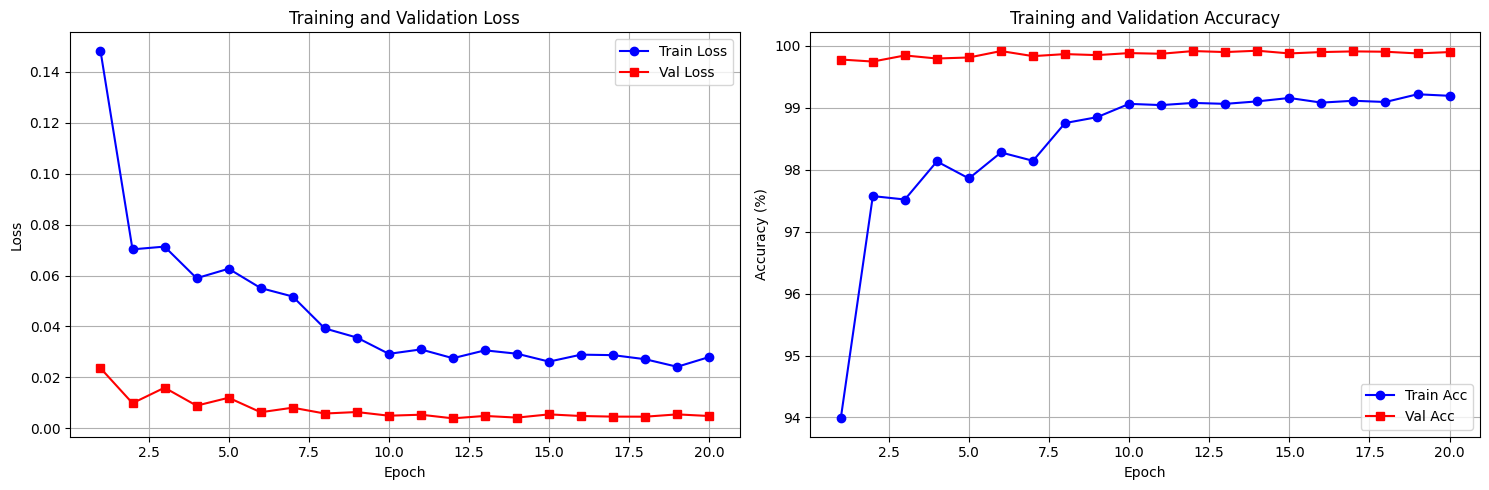

Training history plot saved to: /kaggle/working/models/Approach1_HardMining_VQC/phase3_training_history.png

EVALUATING Hard-Mining Hybrid VQC (Approach 1) ON TEST SET

  test: 13994 Fire, 8855 No_Fire


Testing: 100%|██████████| 715/715 [21:53<00:00,  1.84s/it]



Results for Hard-Mining Hybrid VQC (Approach 1):
  Accuracy:  99.88%
  F1-Score:  99.90%


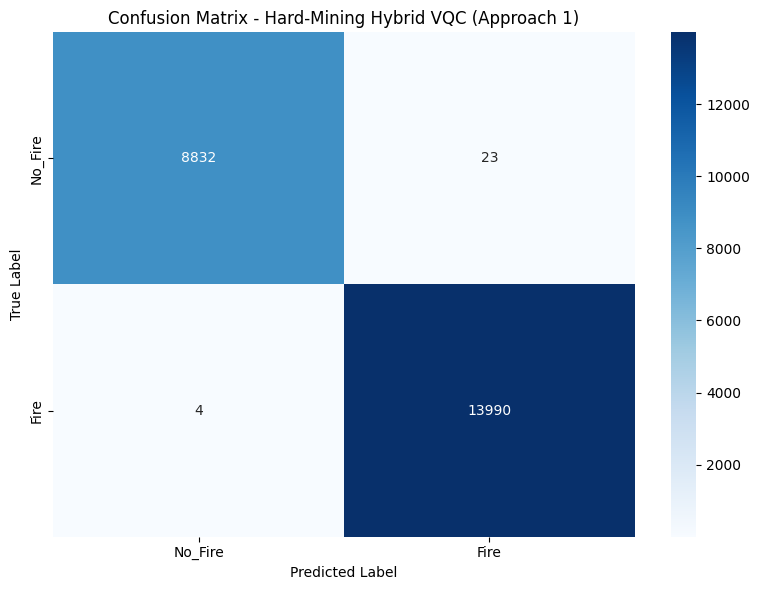

Confusion matrix saved to: /kaggle/working/models/Approach1_HardMining_VQC/confusion_matrix.png


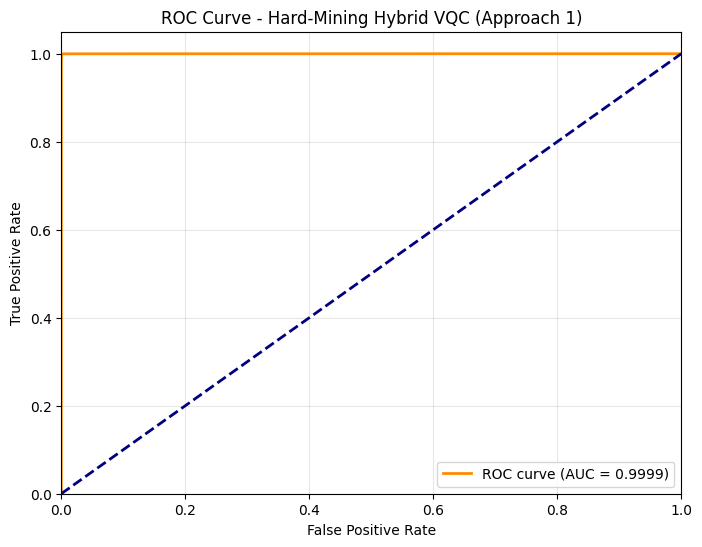

ROC curve saved to: /kaggle/working/models/Approach1_HardMining_VQC/roc_curve.png

Uploading artifacts to Drive...
  Upload failed: No module named '_main_'

APPROACH 1 COMPLETE!
Final Test Accuracy: 99.88%
Final F1-Score: 99.90%

Quantum VQC trained ONLY on hardest 20k examples!
Testing hypothesis: Can quantum solve hard decision boundaries?



In [ ]:
# Mount Drive
drive_service = mount_google_drive_kaggle()

# Setup paths
data_path = '/kaggle/input/final-dataset/Final_Dataset'
models_path = '/kaggle/working/models'
drive_base_folder = 'Deep Learning Semester Project'

# Run complete 3-phase approach
classical_model, quantum_model, results = run_approach1_complete(
    data_path=data_path,
    models_path=models_path,
    drive_service=drive_service,
    drive_base_folder=drive_base_folder,
    phase1_epochs=30,      # Classical training
    phase3_epochs=20,      # Quantum training
    hard_k=20000,          # Number of hard examples
    resume_phase1='latest',    # 'latest', 'best', or None
    resume_phase3='latest'     # 'latest', 'best', or None
)

## **Approach 2: Fine-Tuned Spatially-Gated QuFeX Network (The "Vision Specialist")**

This approach introduces an **Attention-Driven Quantum Feature Extractor (QuFeX)** designed to process only the most relevant image regions, significantly improving computational efficiency and focus.

### **Core Architecture**
1.  **The Gatekeeper (ResNet-18 + Grad-CAM):** A pre-trained ResNet-18 generates a saliency heatmap to identify "Regions of Interest" (e.g., smoke or fire fronts).
2.  **Patch Selection:** The system extracts the **Top-3 highest-activation patches** ($16 \times 16$ pixels) from the heatmap.
3.  **QuFeX Module:** These patches are processed by a **4-qubit Quantum Circuit** using `StronglyEntanglingLayers` to extract 12 distinct textural features.
4.  **Fusion Classifier:** Quantum features are concatenated with global classical features (512 dimensions) for final classification.

### **Warm-Start Training Strategy**
To ensure stability and convergence, training is divided into two phases:
* **Phase A (Warm-Up, Epochs 1-5):** The Quantum Circuit is **FROZEN**, acting as a fixed random kernel to stabilize the classical classifier (Full Dataset).
* **Phase B (Fine-Tuning, Epochs 6-10):** The Quantum Circuit is **UNFROZEN** and trained via Adjoint Differentiation, allowing it to learn specialized fire textures specifically on Hard Mined Samples from Approach 1.

**Goal:** Leverage quantum entanglement to capture subtle textural patterns in "hard" edge cases while using classical attention to ignore irrelevant background noise.

### **DEVICE SETUP**

In [ ]:
def setup_device(use_lightning=True):
    """Setup device with Lightning GPU support."""
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"Using CUDA GPU: {torch.cuda.get_device_name(0)}")
    else:
        device = torch.device('cpu')
        print("Using CPU")
    
    if use_lightning and torch.cuda.is_available():
        try:
            import pennylane_lightning
            print("Lightning GPU support enabled for quantum circuits")
            return device, 'lightning.gpu'
        except ImportError:
            print("Lightning GPU not available, using default simulator")
            return device, 'default.qubit'
    
    return device, 'default.qubit'

device, qml_device_type = setup_device(use_lightning=True)

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Using CUDA GPU: Tesla T4
Lightning GPU support enabled for quantum circuits


### **PHASE 0 AND PHASE A**

#### **Phase 0: Pre-compute Attention Maps**

In [ ]:
def precompute_gradcam_patches_phase0(data_path, checkpoint_manager, batch_size=32):
    """
    Phase 0: Pre-compute Grad-CAM attention and Top-3 patch indices.
    This runs ONCE and saves results.
    
    Saves: Patch coordinates for each image
    """
    print("\n" + "="*70)
    print("PHASE 0: PRE-COMPUTING GRAD-CAM ATTENTION MAPS")
    print("="*70)
    print("This phase runs ONCE and saves Top-3 patch indices per image")
    print("Quantum circuit will be trainable in main training!\n")
    
    features_dir = checkpoint_manager.kaggle_dir
    
    # Check if already done
    if os.path.exists(os.path.join(features_dir, 'train_patch_indices.pt')):
        print("Attention maps already pre-computed! Skipping Phase 0.\n")
        return features_dir
    
    # Load datasets
    print("Loading datasets...")
    train_dataset = FireDatasetApproach2(data_path, split='train')
    val_dataset = FireDatasetApproach2(data_path, split='validation')
    test_dataset = FireDatasetApproach2(data_path, split='test')
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                             shuffle=False, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size,
                           shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                            shuffle=False, num_workers=2)
    
    # Create lightweight gatekeeper (just for Grad-CAM)
    print("\nInitializing Grad-CAM gatekeeper...")
    gatekeeper = GradCAMGatekeeper()
    gatekeeper = gatekeeper.to(device)
    gatekeeper.eval()
    
    splits = [('train', train_loader), ('validation', val_loader), ('test', test_loader)]
    
    for split_name, loader in splits:
        print(f"\n{'='*70}")
        print(f"Processing {split_name} set...")
        print(f"{'='*70}")
        
        all_patch_indices = []  # Store [image_idx, top3_patch_indices]
        all_labels = []
        
        with torch.no_grad():
            for images, labels in tqdm(loader, desc=f"Computing attention for {split_name}"):
                images = images.to(device)
                
                # Generate Grad-CAM (one-time computation)
                with torch.set_grad_enabled(True):
                    logits, _ = gatekeeper(images, return_cam=True)
                    fire_scores = logits[:, 1].sum()
                    fire_scores.backward()
                
                cam = gatekeeper.generate_cam()  # [batch, 7, 7]
                
                # Get Top-3 patch indices for each image
                cam_flat = cam.view(cam.shape[0], -1)  # [batch, 49]
                top3_indices = torch.topk(cam_flat, k=3).indices  # [batch, 3]
                
                all_patch_indices.append(top3_indices.cpu())
                all_labels.append(labels)
                
                # Clear Grad-CAM gradients
                gatekeeper.zero_grad()
        
        # Concatenate all batches
        all_patch_indices = torch.cat(all_patch_indices, dim=0)  # [N, 3]
        all_labels = torch.cat(all_labels, dim=0)  # [N]
        
        print(f"\nPre-computed patch indices: {all_patch_indices.shape}")
        
        # Save to disk
        indices_path = os.path.join(features_dir, f'{split_name}_patch_indices.pt')
        labels_path = os.path.join(features_dir, f'{split_name}_labels.pt')
        
        torch.save(all_patch_indices, indices_path)
        torch.save(all_labels, labels_path)
        
        print(f"Saved to: {indices_path}")
        
        # Upload to Drive
        if checkpoint_manager.drive_service and checkpoint_manager.drive_folder_id:
            try:
                from __main__ import upload_file_to_drive
                upload_file_to_drive(checkpoint_manager.drive_service, indices_path,
                                   checkpoint_manager.drive_folder_id,
                                   f'{split_name}_patch_indices.pt')
                upload_file_to_drive(checkpoint_manager.drive_service, labels_path,
                                   checkpoint_manager.drive_folder_id,
                                   f'{split_name}_labels.pt')
            except Exception as e:
                print(f"Warning: Upload failed: {e}")
    
    print("\n" + "="*70)
    print("PHASE 0 COMPLETE!")
    print("Grad-CAM attention pre-computed!")
    print("="*70 + "\n")
    
    return features_dir

#### **DATASET CLASS: Uses Pre-computed Patch Indices**

In [ ]:
class FireDatasetWithPatchIndices(Dataset):
    """
    Dataset that loads images AND pre-computed patch indices.
    No Grad-CAM computation during training!
    """
    
    def __init__(self, data_dir, indices_dir, split='train'):
        self.split = split
        self.imagenet_mean = np.array([0.485, 0.456, 0.406])
        self.imagenet_std = np.array([0.229, 0.224, 0.225])
        
        # Load image paths
        fire_dir = os.path.join(data_dir, split, 'Fire')
        nofire_dir = os.path.join(data_dir, split, 'No_Fire')
        
        self.fire_files = sorted([os.path.join(fire_dir, f) 
                                 for f in os.listdir(fire_dir) if f.endswith('.jpg')])
        self.nofire_files = sorted([os.path.join(nofire_dir, f) 
                                   for f in os.listdir(nofire_dir) if f.endswith('.jpg')])
        
        self.image_files = self.fire_files + self.nofire_files
        self.labels = [1] * len(self.fire_files) + [0] * len(self.nofire_files)
        
        # Load pre-computed patch indices
        indices_path = os.path.join(indices_dir, f'{split}_patch_indices.pt')
        self.patch_indices = torch.load(indices_path)  # [N, 3]
        
        print(f"  {split}: {len(self.fire_files)} Fire, {len(self.nofire_files)} No_Fire")
        print(f"  Loaded pre-computed patch indices: {self.patch_indices.shape}")
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load image
        image = cv2.imread(self.image_files[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        image = image.astype(np.float32) / 255.0
        image = (image - self.imagenet_mean) / self.imagenet_std
        
        label = self.labels[idx]
        image = torch.FloatTensor(image).permute(2, 0, 1)
        label = torch.LongTensor([label])[0]
        
        # Get pre-computed patch indices for this image
        patch_idx = self.patch_indices[idx]  # [3]
        
        return image, label, patch_idx

#### **TRAINABLE QUFEX MODULE (QUANTUM FEATURE EXTRACTOR)**

In [ ]:
n_qubits_qufex = 4
dev_qufex = qml.device(qml_device_type, wires=n_qubits_qufex)

@qml.qnode(dev_qufex, interface="torch", diff_method="adjoint")
def trainable_qufex_circuit(inputs, weights):
    """
    Trainable QuFeX circuit with Adjoint Differentiation.
    Uses StronglyEntanglingLayers for maximum expressiveness.
    
    Args:
        inputs: [16] patch features
        weights: Trainable quantum parameters
    Returns:
        [4] quantum measurements
    """
    if len(inputs) != 16:
        raise ValueError(f"Expected 16 features, got {len(inputs)}")
    
    # Angle encoding - load classical data
    for i in range(n_qubits_qufex):
        qml.RY(inputs[i], wires=i)
    
    for i in range(n_qubits_qufex):
        qml.RX(inputs[i + 4], wires=i)
    
    for i in range(n_qubits_qufex):
        qml.RY(inputs[i + 8], wires=i)
    
    for i in range(n_qubits_qufex):
        qml.RX(inputs[i + 12], wires=i)
    
    # Trainable StronglyEntanglingLayers (3 layers as per spec)
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits_qufex))
    
    # Measurements
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits_qufex)]


class TrainableQuFeXModule(nn.Module):
    """
    Trainable Quantum Feature Extraction Module.
    Can be frozen (Phase A) or trainable (Phase B).
    """
    
    def __init__(self):
        super(TrainableQuFeXModule, self).__init__()
        
        # Patch compressor: 256 (16x16 flattened) -> 16
        self.patch_compressor = nn.Sequential(
            nn.Linear(256, 64),
            nn.Tanh(),
            nn.Linear(64, 16),
            nn.Tanh()
        )
        
        # Trainable quantum weights for StronglyEntanglingLayers
        # Shape: (n_layers, n_qubits, 3) for StronglyEntanglingLayers
        n_layers = 3
        self.quantum_weights = nn.Parameter(
            torch.randn(n_layers, n_qubits_qufex, 3) * 0.1
        )
        
        print("  Trainable QuFeX initialized")
        print("  Circuit: 4 qubits, 3 StronglyEntangling layers, Adjoint diff")
    
    def forward(self, patch):
        """
        Extract quantum features from patch.
        
        Args:
            patch: [batch, 256] flattened 16x16 patch
        Returns:
            quantum_features: [batch, 4]
        """
        # Compress to 16 dimensions
        compressed = self.patch_compressor(patch)
        
        # Process through quantum circuit
        batch_size = compressed.shape[0]
        quantum_features = torch.zeros(batch_size, n_qubits_qufex, device=patch.device)
        
        for i in range(batch_size):
            q_out = trainable_qufex_circuit(compressed[i], self.quantum_weights)
            quantum_features[i] = torch.stack(q_out)
        
        return quantum_features


#### **GRAD-CAM GATEKEEPER**

In [ ]:
class GradCAMGatekeeper(nn.Module):
    """
    ResNet-18 with Grad-CAM to identify Top-3 important patches.
    Generates 7x7 heatmap for patch selection.
    """
    
    def __init__(self):
        super(GradCAMGatekeeper, self).__init__()
        resnet = models.resnet18(pretrained=True)
        
        # Extract layers up to final conv block
        self.features = nn.Sequential(*list(resnet.children())[:-2])
        
        # Keep backbone trainable for Grad-CAM
        
        # Classifier head
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, 2)
        
        # Grad-CAM hooks
        self.gradients = None
        self.activations = None
        
        print("  Grad-CAM Gatekeeper initialized (ResNet-18)")
    
    def save_gradient(self, grad):
        self.gradients = grad
    
    def forward(self, x, return_cam=False):
        """
        Forward pass with optional CAM generation.
        
        Args:
            x: [batch, 3, 224, 224]
            return_cam: If True, enable Grad-CAM hooks
        Returns:
            logits: [batch, 2]
            features: [batch, 512, 7, 7]
        """
        # Enable gradients for Grad-CAM computation
        if return_cam:
            x = x.requires_grad_(True)
        
        features = self.features(x)
        
        if return_cam:
            features.register_hook(self.save_gradient)
            self.activations = features
        
        pooled = self.gap(features)
        pooled = pooled.view(pooled.size(0), -1)
        logits = self.fc(pooled)
        
        return logits, features
    
    def generate_cam(self):
        """
        Generate Grad-CAM heatmap.
        Returns [batch, 7, 7] heatmap.
        """
        gradients = self.gradients.detach()
        activations = self.activations.detach()
        
        # Global average pooling of gradients
        weights = torch.mean(gradients, dim=(2, 3), keepdim=True)
        
        # Weighted combination
        cam = torch.sum(weights * activations, dim=1, keepdim=True)
        cam = torch.relu(cam)
        cam = cam.squeeze(1)
        
        # Normalize
        batch_size = cam.shape[0]
        for i in range(batch_size):
            cam_min = cam[i].min()
            cam_max = cam[i].max()
            if cam_max > cam_min:
                cam[i] = (cam[i] - cam_min) / (cam_max - cam_min)
        
        return cam


#### **COMPLETE HYBRID MODEL**

In [ ]:
class FastFineTunedQuFeXNetwork(nn.Module):
    """
    FAST version: Uses pre-computed patch indices.
    """
    
    def __init__(self):
        super(FastFineTunedQuFeXNetwork, self).__init__()
        
        # Component 1: Global feature extractor
        resnet = models.resnet18(pretrained=True)
        self.global_features = nn.Sequential(*list(resnet.children())[:-1])
        for param in self.global_features.parameters():
            param.requires_grad = False
        
        # Component 2: Trainable QuFeX (SAME AS BEFORE)
        self.qufex = TrainableQuFeXModule()
        
        # Component 3: Fusion classifier
        self.fusion_classifier = nn.Sequential(
            nn.Linear(524, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.Linear(128, 2)
        )
        
        print("  Fast Hybrid Network assembled")
    
    def extract_patch(self, image, row, col, patch_size=16):
        """Extract patch from image."""
        cell_size = 224 // 7
        center_y = row * cell_size + cell_size // 2
        center_x = col * cell_size + cell_size // 2
        
        y_start = max(0, center_y - patch_size // 2)
        y_end = min(224, y_start + patch_size)
        x_start = max(0, center_x - patch_size // 2)
        x_end = min(224, x_start + patch_size)
        
        patch = image[:, :, y_start:y_end, x_start:x_end]
        
        if patch.shape[2] != patch_size or patch.shape[3] != patch_size:
            patch = nn.functional.interpolate(patch, size=(patch_size, patch_size),
                                            mode='bilinear', align_corners=False)
        
        return patch.contiguous()
    
    def forward(self, x, patch_indices):
        """
        FAST forward pass using pre-computed patch indices.
        
        Args:
            x: [batch, 3, 224, 224]
            patch_indices: [batch, 3] pre-computed Top-3 patch indices
        Returns:
            logits: [batch, 2]
        """
        batch_size = x.shape[0]
        
        # Step 1: Extract global features
        global_feat = self.global_features(x)
        global_feat = global_feat.view(batch_size, -1)
        
        # Step 2: Extract patches using pre-computed indices (NO GRAD-CAM!)
        all_batch_patches = []
        
        for i in range(batch_size):
            for idx in patch_indices[i]:
                row = idx // 7
                col = idx % 7
                patch = self.extract_patch(x[i:i+1], row, col, patch_size=16)
                
                # Flatten
                patch_flat = patch.reshape(1, -1)
                
                if patch_flat.shape[1] > 256:
                    patch_flat = patch_flat[:, :256]
                elif patch_flat.shape[1] < 256:
                    padding = torch.zeros(1, 256 - patch_flat.shape[1], device=x.device)
                    patch_flat = torch.cat([patch_flat, padding], dim=1)
                
                all_batch_patches.append(patch_flat)
        
        # Step 3: Batch process through quantum (TRAINABLE!)
        big_patch_batch = torch.cat(all_batch_patches, dim=0)  # [batch*3, 256]
        all_quantum_results = self.qufex(big_patch_batch)  # [batch*3, 4]
        quantum_features_final = all_quantum_results.view(batch_size, -1)  # [batch, 12]
        
        # Step 4: Fuse and classify
        fused = torch.cat([global_feat, quantum_features_final], dim=1)
        output = self.fusion_classifier(fused)
        
        return output

#### **CHECKPOINT MANAGER**

In [ ]:
class CheckpointManager:
    """Manages checkpoints with Drive integration."""
    
    def __init__(self, model_name, kaggle_dir, drive_service, 
                 drive_base_folder_name, checkpoint_prefix):
        self.model_name = model_name
        self.checkpoint_prefix = checkpoint_prefix
        self.kaggle_dir = os.path.join(kaggle_dir, model_name)
        self.drive_service = drive_service
        self.drive_folder_id = None
        self.best_val_acc = 0.0
        
        os.makedirs(self.kaggle_dir, exist_ok=True)
        
        if drive_service:
            print(f"\nSetting up Google Drive folders...")
            try:
                from __main__ import find_or_create_folder
                base_folder_id = find_or_create_folder(drive_service, drive_base_folder_name)
                models_folder_id = find_or_create_folder(drive_service, 'models', base_folder_id)
                self.drive_folder_id = find_or_create_folder(drive_service, model_name, models_folder_id)
                print(f"  Drive: {drive_base_folder_name}/models/{model_name}/")
            except Exception as e:
                print(f"  Warning: Could not create Drive folders: {e}")
    
    def save_checkpoint(self, epoch, model, optimizer, train_loss, train_acc,
                       val_loss, val_acc, history, is_best=False, phase=''):
        """Save checkpoint locally and to Drive."""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'history': history,
            'best_val_acc': self.best_val_acc,
            'phase': phase
        }
        
        # Save latest
        latest_name = f'{self.checkpoint_prefix}_latest.pth'
        latest_path = os.path.join(self.kaggle_dir, latest_name)
        torch.save(checkpoint, latest_path)
        print(f"  Saved: {latest_name}")
        
        # Upload to Drive
        if self.drive_service and self.drive_folder_id:
            try:
                from __main__ import upload_file_to_drive
                upload_file_to_drive(self.drive_service, latest_path, 
                                   self.drive_folder_id, latest_name)
            except Exception as e:
                print(f"  Warning: Upload failed: {e}")
        
        # Save best
        if is_best:
            best_name = f'{self.checkpoint_prefix}_best.pth'
            best_path = os.path.join(self.kaggle_dir, best_name)
            torch.save(checkpoint, best_path)
            print(f"  NEW BEST! Val Acc: {val_acc:.2f}%")
            
            if self.drive_service and self.drive_folder_id:
                try:
                    from __main__ import upload_file_to_drive
                    upload_file_to_drive(self.drive_service, best_path,
                                       self.drive_folder_id, best_name)
                except Exception as e:
                    print(f"  Warning: Best upload failed: {e}")
    
    def load_checkpoint(self, model, optimizer, checkpoint_type='latest'):
        """Load checkpoint from Drive first, then local."""
        filename = f'{self.checkpoint_prefix}_{checkpoint_type}.pth'
        local_path = os.path.join(self.kaggle_dir, filename)
        
        # Try downloading from Drive first
        if self.drive_service and self.drive_folder_id:
            try:
                from __main__ import download_file_from_drive
                query = f"name='{filename}' and '{self.drive_folder_id}' in parents and trashed=false"
                results = self.drive_service.files().list(q=query, fields='files(id, name)').execute()
                files = results.get('files', [])
                
                if files:
                    print(f"  Downloading from Drive: {filename}")
                    download_file_from_drive(self.drive_service, files[0]['id'], local_path)
            except Exception as e:
                print(f"  Warning: Drive download failed: {e}")
        
        # Load from local
        if os.path.exists(local_path):
            print(f"  Loading: {filename}")
            checkpoint = torch.load(local_path, map_location=device)
            model.load_state_dict(checkpoint['model_state_dict'])
            if optimizer:
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.best_val_acc = checkpoint.get('best_val_acc', 0.0)
            return checkpoint['epoch'], checkpoint.get('history', {}), checkpoint.get('phase', '')
        else:
            print(f"  No checkpoint found: {filename}")
            return 0, {}, ''


#### **WARM-START TRAINING FUNCTION**

In [ ]:
def train_fast_warmstart_qufex(data_path, indices_dir, checkpoint_manager,
                               num_epochs=8, batch_size=32, learning_rate=0.001,
                               resume_from=None, grad_accumulation_steps=4):
    """
    OPTIMIZED Warm-Start training with gradient accumulation for Phase B.
    
    Args:
        data_path: Path to dataset
        indices_dir: Directory with pre-computed patch indices
        checkpoint_manager: CheckpointManager instance
        num_epochs: Total epochs (5 warmup + 3 finetune = 8)
        batch_size: Batch size
        learning_rate: Learning rate
        resume_from: 'latest', 'best', or None
        grad_accumulation_steps: Gradient accumulation steps for Phase B (default: 4)
    
    Strategy:
        - Phase A (Epochs 0-4): Quantum FROZEN, no accumulation
        - Phase B (Epochs 5-7): Quantum TRAINABLE, 4x gradient accumulation
    """
    print("\n" + "="*70)
    print("OPTIMIZED WARM-START TRAINING: FINE-TUNED QUFEX NETWORK")
    print("="*70)
    print("Using pre-computed Grad-CAM attention (Phase 0)")
    print(f"Total epochs: {num_epochs} (5 warmup + {num_epochs-5} finetune)")
    print(f"Phase B optimization: Gradient accumulation ({grad_accumulation_steps}x)")
    print("="*70 + "\n")
    
    # Load datasets with pre-computed indices
    print("Loading datasets with pre-computed patches...")
    train_dataset = FireDatasetWithPatchIndices(data_path, indices_dir, split='train')
    val_dataset = FireDatasetWithPatchIndices(data_path, indices_dir, split='validation')
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                             shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size,
                           shuffle=False, num_workers=2, pin_memory=True)
    
    # Create FAST model
    print("\nCreating fast hybrid model...")
    model = FastFineTunedQuFeXNetwork()
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    start_epoch = 0
    best_val_acc = 0.0
    
    # Resume if specified
    if resume_from:
        start_epoch, history, _ = checkpoint_manager.load_checkpoint(
            model, optimizer, checkpoint_type=resume_from
        )
        best_val_acc = checkpoint_manager.best_val_acc
        for _ in range(start_epoch):
            scheduler.step()
        print(f"\nResumed from epoch {start_epoch}")
        print(f"Best validation accuracy so far: {best_val_acc:.2f}%\n")
    
    print("\nStarting optimized training...\n")
    
    for epoch in range(start_epoch, num_epochs):
        # Determine phase and accumulation strategy
        if epoch < 5:
            phase = 'warmup'
            accumulation_steps = 1  # No accumulation in Phase A
            
            # Freeze quantum
            for param in model.qufex.parameters():
                param.requires_grad = False
            
            print(f"\nEpoch {epoch+1}/{num_epochs} - PHASE A: WARM-UP")
            print("  Quantum Circuit: FROZEN (Random Kernel)")
            print("  Classifier: TRAINABLE")
            print("  Gradient Accumulation: Disabled (Phase A is already fast)")
        else:
            phase = 'finetune'
            accumulation_steps = grad_accumulation_steps  # Use accumulation in Phase B
            
            # Unfreeze quantum
            for param in model.qufex.parameters():
                param.requires_grad = True
            
            print(f"\nEpoch {epoch+1}/{num_epochs} - PHASE B: FINE-TUNING (OPTIMIZED)")
            print("  Quantum Circuit: TRAINABLE (Learning Fire Textures)")
            print("  Classifier: TRAINABLE")
            print(f"  Gradient Accumulation: {accumulation_steps}x")
        
        # Train
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        # Initialize gradient accumulation
        optimizer.zero_grad()
        accumulated_loss = 0.0
        
        pbar = tqdm(train_loader, desc=f'Training')
        for batch_idx, (images, labels, patch_indices) in enumerate(pbar):
            images = images.to(device)
            labels = labels.to(device)
            patch_indices = patch_indices.to(device)
            
            # Forward pass
            outputs = model(images, patch_indices)
            loss = criterion(outputs, labels)
            
            # Scale loss by accumulation steps
            scaled_loss = loss / accumulation_steps
            scaled_loss.backward()
            
            # Update weights every N batches (or at end of epoch)
            if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader):
                optimizer.step()
                optimizer.zero_grad()
            
            # Statistics (use original unscaled loss for display)
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            # Update progress bar
            current_avg_loss = train_loss / (batch_idx + 1)
            current_acc = 100 * train_correct / train_total
            
            pbar.set_postfix({
                'loss': f'{current_avg_loss:.4f}',
                'acc': f'{current_acc:.2f}%'
            })
        
        # Clear any remaining gradients
        optimizer.zero_grad()
        
        train_loss /= len(train_loader)
        train_acc = 100 * train_correct / train_total
        
        # Validate
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            pbar = tqdm(val_loader, desc=f'Validation')
            for images, labels, patch_indices in pbar:
                images = images.to(device)
                labels = labels.to(device)
                patch_indices = patch_indices.to(device)
                
                outputs = model(images, patch_indices)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
                pbar.set_postfix({
                    'loss': f'{val_loss/len(pbar):.4f}',
                    'acc': f'{100*val_correct/val_total:.2f}%'
                })
        
        val_loss /= len(val_loader)
        val_acc = 100 * val_correct / val_total
        scheduler.step()
        
        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Print epoch summary
        print(f"\n  Epoch {epoch+1} Summary:")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        print(f"  Learning Rate: {scheduler.get_last_lr()[0]:.6f}")
        
        # Save checkpoint
        is_best = val_acc > best_val_acc
        if is_best:
            best_val_acc = val_acc
            checkpoint_manager.best_val_acc = best_val_acc
            print(f"  NEW BEST MODEL! Validation Accuracy: {val_acc:.2f}%")
        
        checkpoint_manager.save_checkpoint(
            epoch + 1, model, optimizer, train_loss, train_acc,
            val_loss, val_acc, history, is_best=is_best, phase=phase
        )
        
        # Print phase completion message
        if epoch == 4:
            print("\n" + "="*70)
            print("PHASE A COMPLETE!")
            print(f"Classifier stabilized with random quantum features")
            print(f"Best validation accuracy: {best_val_acc:.2f}%")
            print("="*70)
        elif epoch == num_epochs - 1:
            print("\n" + "="*70)
            print("PHASE B COMPLETE!")
            print(f"Quantum circuit fine-tuned for {num_epochs - 5} epochs")
            print(f"Final validation accuracy: {val_acc:.2f}%")
            print("="*70)
    
    print("\n" + "="*70)
    print("OPTIMIZED TRAINING COMPLETE!")
    print("="*70)
    print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
    print(f"Total Epochs: {num_epochs} (5 warmup + {num_epochs-5} finetune)")
    print(f"Phase B Optimization: {grad_accumulation_steps}x gradient accumulation")
    print("="*70 + "\n")
    
    return model, history

#### **EVALUATION**

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

def evaluate_model_with_indices(model, test_loader, model_name):
    """
    Evaluate model on test set.
    """
    print("\n" + "="*70)
    print(f"EVALUATING {model_name} ON TEST SET")
    print("="*70)
    
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch_data in tqdm(test_loader, desc='Testing'):
            # Handle both 2-tuple and 3-tuple returns
            if len(batch_data) == 3:
                images, labels, patch_indices = batch_data
                images = images.to(device)
                labels = labels.to(device)
                patch_indices = patch_indices.to(device)
                
                # Forward pass with patch indices
                outputs = model(images, patch_indices)
            else:
                images, labels = batch_data
                images = images.to(device)
                labels = labels.to(device)
                
                # Forward pass without patch indices
                outputs = model(images)
            
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    print(f"\n{'='*60}")
    print(f"TEST RESULTS - {model_name}")
    print(f"{'='*60}")
    print(f"  Accuracy:  {accuracy*100:.2f}%")
    print(f"  Precision: {precision*100:.2f}%")
    print(f"  Recall:    {recall*100:.2f}%")
    print(f"  F1-Score:  {f1*100:.2f}%")
    print(f"\n  Confusion Matrix:")
    print(f"    TN: {conf_matrix[0][0]:,}  FP: {conf_matrix[0][1]:,}")
    print(f"    FN: {conf_matrix[1][0]:,}  TP: {conf_matrix[1][1]:,}")
    print(f"{'='*60}\n")
    
    # Detailed classification report
    print("Detailed Classification Report:")
    print(classification_report(all_labels, all_preds,
                                target_names=['No_Fire', 'Fire'], digits=4))
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': conf_matrix,
        'predictions': all_preds,
        'labels': all_labels
    }


#### **MAIN EXECUTION FUNCTION**

In [ ]:
def run_approach2_fast_complete(data_path, models_path, drive_service, drive_base_folder,
                               num_epochs=8, batch_size=32, learning_rate=0.001,
                               grad_accumulation_steps=4, resume_from=None):  
    """
    Complete FAST execution with pre-computation and gradient accumulation.
    
    Time breakdown:
    - Phase 0 (pre-compute): ~30 min (ONE TIME)
    - Phase A (5 epochs): ~1 hour
    - Phase B (3 epochs with 4x accumulation): ~6-7 hours
    - Total: ~8 hours (vs 40+ hours without optimization!)
    """
    print("\n" + "="*70)
    print("APPROACH 2: FINE-TUNED SPATIALLY-GATED QUFEX NETWORK")
    print("="*70)
    
    # Setup checkpoint manager
    model_name = 'Approach2_FineTuned_QuFeX_Fast'
    checkpoint_manager = CheckpointManager(
        model_name=model_name,
        kaggle_dir=models_path,
        drive_service=drive_service,
        drive_base_folder_name=drive_base_folder,
        checkpoint_prefix='QUFEX_FAST'
    )
    
    # Phase 0: Pre-compute Grad-CAM patch indices
    indices_dir = precompute_gradcam_patches_phase0(
        data_path=data_path,
        checkpoint_manager=checkpoint_manager,
        batch_size=32
    )
    
    # Train with optimizations
    model, history = train_fast_warmstart_qufex(
        data_path=data_path,
        indices_dir=indices_dir,
        checkpoint_manager=checkpoint_manager,
        num_epochs=num_epochs,
        batch_size=batch_size,
        learning_rate=learning_rate,
        grad_accumulation_steps=grad_accumulation_steps,  # Pass through
        resume_from=resume_from
    )
    
    # Load best model and evaluate
    checkpoint_manager.load_checkpoint(model, None, checkpoint_type='best')
    
    test_dataset = FireDatasetWithPatchIndices(data_path, indices_dir, split='test')
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
    
    results = evaluate_model_with_indices(model, test_loader,
                                         "Optimized Fine-Tuned QuFeX (Approach 2)")
    
    print("\n" + "="*70)
    print("APPROACH 2 COMPLETE!")
    print("="*70)
    print(f"Final Test Accuracy: {results['accuracy']*100:.2f}%")
    print(f"Optimizations: Gradient accumulation")
    print("="*70 + "\n")
    
    return model, results

#### **MAIN EXECUTION**

In [ ]:
"""
Complete execution pipeline for Approach 2: Fine-Tuned Spatially-Gated QuFeX Network
Optimized version with pre-computed Grad-CAM attention maps
"""

# Mount Google Drive
print("="*70)
print("STEP 1: MOUNTING GOOGLE DRIVE")
print("="*70)

drive_service = mount_google_drive_kaggle()

if drive_service is None:
    print("\nWARNING: Google Drive not mounted!")
    print("Models will only be saved locally to Kaggle")
else:
    print("\nGoogle Drive mounted successfully!")

# Define paths
print("\n" + "="*70)
print("STEP 2: SETTING UP PATHS")
print("="*70)

data_path = '/kaggle/input/final-dataset/Final_Dataset'
models_path = '/kaggle/working/models'
drive_base_folder = 'Deep Learning Semester Project'

print(f"Data path: {data_path}")
print(f"Models path: {models_path}")
print(f"Drive folder: {drive_base_folder}")

# Run Approach 2
print("\n" + "="*70)
print("STEP 3: RUNNING APPROACH 2 - FAST VERSION")
print("="*70)
print("  1. Phase 0: Pre-compute Grad-CAM attention")
print("  2. Phase A: Warm-up training (Epochs 1-5, Quantum FROZEN)")
print("  3. Phase B: Fine-tuning (Epochs 6-10, Quantum TRAINABLE)")
print("  4. Evaluation on test set")

# Run the complete pipeline
model, results = run_approach2_fast_complete(
    data_path=data_path,
    models_path=models_path,
    drive_service=drive_service,
    drive_base_folder=drive_base_folder,
    num_epochs=10,          # 5 warmup + 5 finetune
    batch_size=32,          # As per specifications
    learning_rate=0.001,    # Standard learning rate
    resume_from=None        # Set to 'latest' or 'best' to resume
)

# Step 4: Display final results
print("\n" + "="*70)
print("STEP 4: FINAL RESULTS SUMMARY")
print("="*70)
print(f"\nTest Accuracy:  {results['accuracy']*100:.2f}%")
print(f"Test Precision: {results['precision']*100:.2f}%")
print(f"Test Recall:    {results['recall']*100:.2f}%")
print(f"Test F1-Score:  {results['f1_score']*100:.2f}%")

print("\nConfusion Matrix:")
print(f"  True Negatives:  {results['confusion_matrix'][0][0]}")
print(f"  False Positives: {results['confusion_matrix'][0][1]}")
print(f"  False Negatives: {results['confusion_matrix'][1][0]}")
print(f"  True Positives:  {results['confusion_matrix'][1][1]}")

print("\nFiles saved to:")
print(f"  Local: /kaggle/working/models/Approach2_FineTuned_QuFeX_Fast/")
print(f"  Drive: {drive_base_folder}/models/Approach2_FineTuned_QuFeX_Fast/")

print("\n" + "="*70)
print("APPROACH 2 EXECUTION COMPLETE!")
print("="*70)

STEP 1: MOUNTING GOOGLE DRIVE

MOUNTING GOOGLE DRIVE (KAGGLE):
Loading authentication token...
Testing connection...
Google Drive mounted successfully via OAuth!
Full read/write access enabled

Google Drive mounted successfully!

STEP 2: SETTING UP PATHS
Data path: /kaggle/input/final-dataset/Final_Dataset
Models path: /kaggle/working/models
Drive folder: Deep Learning Semester Project

STEP 3: RUNNING APPROACH 2 - FAST VERSION

This will execute:
  1. Phase 0: Pre-compute Grad-CAM attention (if not already done)
  2. Phase A: Warm-up training (Epochs 0-5, Quantum FROZEN)
  3. Phase B: Fine-tuning (Epochs 6-10, Quantum TRAINABLE)
  4. Evaluation on test set

Estimated time:
  - Phase 0: ~30 minutes (ONE TIME, skipped if already done)
  - Training: ~1.5-2 hours (10 epochs)
  - Total: ~2 hours


APPROACH 2 (FAST): FINE-TUNED SPATIALLY-GATED QUFEX NETWORK

Optimized Strategy:
  Phase 0: Pre-compute Grad-CAM attention (30 min, ONE TIME)
  Phase A: Warm-up with frozen quantum (fast!)
  Phas

Computing attention for train: 100%|██████████| 3539/3539 [12:40<00:00,  4.66it/s]



Pre-computed patch indices: torch.Size([113246, 3])
Saved to: /kaggle/working/models/Approach2_FineTuned_QuFeX_Fast/train_patch_indices.pt
  Uploaded: train_patch_indices.pt
  Uploaded: train_labels.pt

Processing validation set...


Computing attention for validation: 100%|██████████| 572/572 [02:16<00:00,  4.18it/s]



Pre-computed patch indices: torch.Size([18279, 3])
Saved to: /kaggle/working/models/Approach2_FineTuned_QuFeX_Fast/validation_patch_indices.pt
  Uploaded: validation_patch_indices.pt
  Uploaded: validation_labels.pt

Processing test set...


Computing attention for test: 100%|██████████| 715/715 [02:22<00:00,  5.02it/s]



Pre-computed patch indices: torch.Size([22849, 3])
Saved to: /kaggle/working/models/Approach2_FineTuned_QuFeX_Fast/test_patch_indices.pt
  Uploaded: test_patch_indices.pt
  Uploaded: test_labels.pt

PHASE 0 COMPLETE!
Grad-CAM attention pre-computed - training will be MUCH faster!


FAST WARM-START TRAINING: FINE-TUNED QUFEX NETWORK
Using pre-computed Grad-CAM attention (Phase 0)
Quantum circuit is STILL TRAINABLE - novelty maintained!

Loading datasets with pre-computed patches...
  train: 84860 Fire, 28386 No_Fire
  Loaded pre-computed patch indices: torch.Size([113246, 3])
  validation: 11183 Fire, 7096 No_Fire
  Loaded pre-computed patch indices: torch.Size([18279, 3])

Creating fast hybrid model...
  Trainable QuFeX initialized
  Circuit: 4 qubits, 3 StronglyEntangling layers, Adjoint diff
  Fast Hybrid Network assembled (No Grad-CAM overhead)

Starting FAST training...


Epoch 1/10 - PHASE A: WARM-UP
  Quantum: FROZEN, Classifier: TRAINABLE


Validation: 100%|██████████| 572/572 [07:10<00:00,  1.33it/s, loss=0.0178, acc=99.41%]



  Train Loss: 0.0459 | Train Acc: 98.36%
  Val Loss: 0.0178 | Val Acc: 99.41%
  Saved: QUFEX_FAST_latest.pth
  Uploaded: QUFEX_FAST_latest.pth
  NEW BEST! Val Acc: 99.41%
  Uploaded: QUFEX_FAST_best.pth

Epoch 2/10 - PHASE A: WARM-UP
  Quantum: FROZEN, Classifier: TRAINABLE


Validation: 100%|██████████| 572/572 [07:09<00:00,  1.33it/s, loss=0.0129, acc=99.61%]



  Train Loss: 0.0223 | Train Acc: 99.21%
  Val Loss: 0.0129 | Val Acc: 99.61%
  Saved: QUFEX_FAST_latest.pth
  Updated: QUFEX_FAST_latest.pth
  NEW BEST! Val Acc: 99.61%
  Updated: QUFEX_FAST_best.pth

Epoch 3/10 - PHASE A: WARM-UP
  Quantum: FROZEN, Classifier: TRAINABLE


Validation: 100%|██████████| 572/572 [07:07<00:00,  1.34it/s, loss=0.0167, acc=99.64%]



  Train Loss: 0.0179 | Train Acc: 99.38%
  Val Loss: 0.0167 | Val Acc: 99.64%
  Saved: QUFEX_FAST_latest.pth
  Updated: QUFEX_FAST_latest.pth
  NEW BEST! Val Acc: 99.64%
  Updated: QUFEX_FAST_best.pth

Epoch 4/10 - PHASE A: WARM-UP
  Quantum: FROZEN, Classifier: TRAINABLE


Validation: 100%|██████████| 572/572 [07:15<00:00,  1.31it/s, loss=0.0085, acc=99.70%]



  Train Loss: 0.0121 | Train Acc: 99.58%
  Val Loss: 0.0085 | Val Acc: 99.70%
  Saved: QUFEX_FAST_latest.pth
  Updated: QUFEX_FAST_latest.pth
  NEW BEST! Val Acc: 99.70%
  Updated: QUFEX_FAST_best.pth

Epoch 5/10 - PHASE A: WARM-UP
  Quantum: FROZEN, Classifier: TRAINABLE


Validation: 100%|██████████| 572/572 [07:08<00:00,  1.34it/s, loss=0.0078, acc=99.78%]



  Train Loss: 0.0107 | Train Acc: 99.63%
  Val Loss: 0.0078 | Val Acc: 99.78%
  Saved: QUFEX_FAST_latest.pth
  Updated: QUFEX_FAST_latest.pth
  NEW BEST! Val Acc: 99.78%
  Updated: QUFEX_FAST_best.pth

Epoch 6/10 - PHASE B: FINE-TUNING
  Quantum: TRAINABLE, Classifier: TRAINABLE


Training:   7%|▋         | 244/3539 [28:29<6:21:48,  6.95s/it, loss=0.0008, acc=99.62%]Exception ignored in: <function _xla_gc_callback at 0x7983c3584d60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 
Training:   7%|▋         | 245/3539 [28:43<6:26:18,  7.04s/it, loss=0.0008, acc=99.62%]


KeyboardInterrupt: 

### **PHASE B & EVALUATION**

#### **CHECK HARD INDICES AVAILABILITY**

In [ ]:
def check_hard_indices_availability(drive_service, drive_base_folder):
    """Check if hard indices from Approach 1 are available."""
    print("\n" + "="*70)
    print("CHECKING HARD INDICES AVAILABILITY")
    print("="*70)
    
    try:
        from __main__ import find_or_create_folder
        
        base_folder_id = find_or_create_folder(drive_service, drive_base_folder)
        models_folder_id = find_or_create_folder(drive_service, 'models', base_folder_id)
        approach1_folder_id = find_or_create_folder(drive_service, 
                                                    'Approach1_HardMining_VQC',
                                                    models_folder_id)
        
        # Search for hard_indices.json
        query = f"name='hard_indices.json' and '{approach1_folder_id}' in parents and trashed=false"
        results = drive_service.files().list(q=query, fields='files(id, name)').execute()
        files = results.get('files', [])
        
        if files:
            print(" hard_indices.json FOUND in Drive")
            print(f"  File ID: {files[0]['id']}")
            print("  Ready to use for hybrid training!")
            return True
        else:
            print(" hard_indices.json NOT FOUND")
            print("\nTo generate hard indices:")
            print("  1. Run Approach 1 Phase 1 (train classical model)")
            print("  2. Run Approach 1 Phase 2 (mine hard examples)")
            print("  3. This creates hard_indices.json in Drive")
            return False
            
    except Exception as e:
        print(f"Error checking hard indices: {e}")
        return False

#### **LOAD HARD INDICES FROM APPROACH 1**

In [ ]:
def load_hard_indices_from_approach1(drive_service, drive_folder_id, local_path):
    """
    Load hard-mined indices from Approach 1.
    
    Args:
        drive_service: Google Drive service
        drive_folder_id: Folder ID where hard_indices.json is stored
        local_path: Local path to save the file
    
    Returns:
        hard_indices: List of hard example indices
    """
    print("\n" + "="*70)
    print("LOADING HARD-MINED INDICES FROM APPROACH 1")
    print("="*70)
    
    # Download from Drive
    if drive_service and drive_folder_id:
        try:
            from __main__ import download_file_from_drive
            
            # Search for hard_indices.json
            query = f"name='hard_indices.json' and '{drive_folder_id}' in parents and trashed=false"
            results = drive_service.files().list(q=query, fields='files(id, name)').execute()
            files = results.get('files', [])
            
            if files:
                print(f"  Found hard_indices.json in Drive")
                download_file_from_drive(drive_service, files[0]['id'], local_path)
                print(f"  Downloaded to: {local_path}")
            else:
                print(f"  WARNING: hard_indices.json not found in Drive!")
                print(f"  You need to run Approach 1 Phase 2 first to generate hard indices.")
                return None
        except Exception as e:
            print(f"  Error downloading: {e}")
            return None
    
    # Load indices
    if os.path.exists(local_path):
        with open(local_path, 'r') as f:
            data = json.load(f)
            hard_indices = data['hard_indices']
        
        print(f"  Loaded {len(hard_indices)} hard-mined indices")
        print(f"  These are the hardest examples identified by entropy")
        return hard_indices
    else:
        print(f"  File not found: {local_path}")
        return None

#### **DATASET CLASS FOR PHASE B WITH HARD MINING TECHNIQUE**

In [ ]:
class HybridHardMiningDataset(Dataset):
    """
    Hybrid dataset that switches between full and hard subset.
    - Phase A: Uses ALL images
    - Phase B: Uses ONLY hard-mined images
    """
    
    def __init__(self, data_dir, indices_dir, split='train', hard_indices=None):
        """
        Args:
            data_dir: Path to dataset
            indices_dir: Directory with pre-computed patch indices
            split: 'train', 'validation', or 'test'
            hard_indices: List of hard example indices (for Phase B)
        """
        self.split = split
        self.imagenet_mean = np.array([0.485, 0.456, 0.406])
        self.imagenet_std = np.array([0.229, 0.224, 0.225])
        self.hard_indices = hard_indices
        self.use_hard_subset = False  # Start with full dataset
        
        # Load image paths
        fire_dir = os.path.join(data_dir, split, 'Fire')
        nofire_dir = os.path.join(data_dir, split, 'No_Fire')
        
        self.fire_files = sorted([os.path.join(fire_dir, f) 
                                 for f in os.listdir(fire_dir) if f.endswith('.jpg')])
        self.nofire_files = sorted([os.path.join(nofire_dir, f) 
                                   for f in os.listdir(nofire_dir) if f.endswith('.jpg')])
        
        self.all_image_files = self.fire_files + self.nofire_files
        self.all_labels = [1] * len(self.fire_files) + [0] * len(self.nofire_files)
        
        # Load pre-computed patch indices
        indices_path = os.path.join(indices_dir, f'{split}_patch_indices.pt')
        self.all_patch_indices = torch.load(indices_path)
        
        # Set initial dataset (full)
        self.image_files = self.all_image_files
        self.labels = self.all_labels
        self.patch_indices = self.all_patch_indices
        
        print(f"  {split}: {len(self.fire_files)} Fire, {len(self.nofire_files)} No_Fire")
        print(f"  Total: {len(self.all_image_files)} images")
        if hard_indices:
            print(f"  Hard subset available: {len(hard_indices)} images")
    
    def switch_to_hard_subset(self):
        """Switch to using only hard-mined examples (for Phase B)."""
        if self.hard_indices is None:
            print("  WARNING: No hard indices provided, staying with full dataset")
            return
        
        self.use_hard_subset = True
        
        # Filter to hard examples only
        self.image_files = [self.all_image_files[i] for i in self.hard_indices]
        self.labels = [self.all_labels[i] for i in self.hard_indices]
        self.patch_indices = self.all_patch_indices[self.hard_indices]
        
        print(f"\n  SWITCHED TO HARD SUBSET:")
        print(f"  Using {len(self.image_files)} hard-mined images (from {len(self.all_image_files)} total)")
    
    def switch_to_full_dataset(self):
        """Switch back to full dataset (for Phase A)."""
        self.use_hard_subset = False
        self.image_files = self.all_image_files
        self.labels = self.all_labels
        self.patch_indices = self.all_patch_indices
        print(f"\n  Using FULL dataset: {len(self.image_files)} images")
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load image
        image = cv2.imread(self.image_files[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        image = image.astype(np.float32) / 255.0
        image = (image - self.imagenet_mean) / self.imagenet_std
        
        label = self.labels[idx]
        image = torch.FloatTensor(image).permute(2, 0, 1)
        label = torch.LongTensor([label])[0]
        
        # Get pre-computed patch indices
        patch_idx = self.patch_indices[idx]
        
        return image, label, patch_idx

#### **TRAINING FUNCTION WITH HARD MINING FOR PHASE B**

In [ ]:
def train_hybrid_hardmining_qufex(data_path, indices_dir, checkpoint_manager,
                                  hard_indices, num_epochs=8, batch_size=32, 
                                  learning_rate=0.001, resume_from=None,
                                  grad_accumulation_steps=4):
    """
    HYBRID STRATEGY: Full dataset in Phase A, Hard subset in Phase B.
    
    This combines the best of both approaches:
    - Phase A (0-4): Train on ALL 73k images, quantum FROZEN
    - Phase B (5-7): Train on HARD 20k images, quantum TRAINABLE
    
    Benefits:
    - Classifier sees all data (robust)
    - Quantum focuses on hard cases (efficient)
    - 3x faster Phase B
    - Better accuracy (quantum specializes)
    """
    print("\n" + "="*70)
    print("HYBRID HARD-MINING STRATEGY")
    print("="*70)
    print("Phase A: Train on FULL dataset with frozen quantum")
    print("Phase B: Train on HARD subset (20k) with trainable quantum")
    print("="*70 + "\n")
    
    # Create hybrid datasets
    print("Loading datasets...")
    train_dataset = HybridHardMiningDataset(
        data_path, indices_dir, split='train', hard_indices=hard_indices
    )
    val_dataset = FireDatasetWithPatchIndices(data_path, indices_dir, split='validation')
    
    # Start with full dataset for Phase A
    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                             shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size,
                           shuffle=False, num_workers=2, pin_memory=True)
    
    # Create model
    print("\nCreating hybrid model...")
    model = FastFineTunedQuFeXNetwork()
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    start_epoch = 0
    best_val_acc = 0.0
    
    # Resume if specified
    if resume_from:
        start_epoch, history, _ = checkpoint_manager.load_checkpoint(
            model, optimizer, checkpoint_type=resume_from
        )
        best_val_acc = checkpoint_manager.best_val_acc
        for _ in range(start_epoch):
            scheduler.step()
        print(f"\nResumed from epoch {start_epoch}")
    
    print("\nStarting HYBRID training...\n")
    
    for epoch in range(start_epoch, num_epochs):
        # Determine phase and dataset
        if epoch < 5:
            # PHASE A: Full dataset, frozen quantum
            phase = 'warmup'
            accumulation_steps = 1
            
            if epoch == 0 or (resume_from and start_epoch < 5):
                train_dataset.switch_to_full_dataset()
                # Recreate dataloader with full dataset
                train_loader = DataLoader(train_dataset, batch_size=batch_size,
                                        shuffle=True, num_workers=2, pin_memory=True)
            
            for param in model.qufex.parameters():
                param.requires_grad = False
            
            print(f"\nEpoch {epoch+1}/{num_epochs} - PHASE A: WARM-UP")
            print("  Dataset: FULL")
            print("  Quantum: FROZEN (Random Kernel)")
            print("  Classifier: TRAINABLE")
            
        else:
            # PHASE B: Hard subset, trainable quantum
            phase = 'finetune'
            accumulation_steps = grad_accumulation_steps
            
            if epoch == 5:
                print("\n" + "="*35)
                print("SWITCHING TO HARD-MINED SUBSET!")
                print("="*35)
                train_dataset.switch_to_hard_subset()
                # Recreate dataloader with hard subset
                train_loader = DataLoader(train_dataset, batch_size=batch_size,
                                        shuffle=True, num_workers=2, pin_memory=True)
            
            for param in model.qufex.parameters():
                param.requires_grad = True
            
            print(f"\nEpoch {epoch+1}/{num_epochs} - PHASE B: HARD-MINING + FINE-TUNING")
            print(f"  Dataset: HARD SUBSET ({len(train_dataset)} images)")
            print("  Quantum: TRAINABLE (Learning on hard cases)")
            print("  Classifier: TRAINABLE")
            print(f"  Gradient Accumulation: {accumulation_steps}x")
        
        # Train
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        optimizer.zero_grad()
        
        pbar = tqdm(train_loader, desc=f'Training')
        for batch_idx, (images, labels, patch_indices) in enumerate(pbar):
            images = images.to(device)
            labels = labels.to(device)
            patch_indices = patch_indices.to(device)
            
            # Forward pass
            outputs = model(images, patch_indices)
            loss = criterion(outputs, labels)
            
            # Scale loss for accumulation
            scaled_loss = loss / accumulation_steps
            scaled_loss.backward()
            
            # Update weights
            if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader):
                optimizer.step()
                optimizer.zero_grad()
            
            # Statistics
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            pbar.set_postfix({
                'loss': f'{train_loss/(batch_idx+1):.4f}',
                'acc': f'{100*train_correct/train_total:.2f}%'
            })
        
        optimizer.zero_grad()
        
        train_loss /= len(train_loader)
        train_acc = 100 * train_correct / train_total
        
        # Validate
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            pbar = tqdm(val_loader, desc=f'Validation')
            for images, labels, patch_indices in pbar:
                images = images.to(device)
                labels = labels.to(device)
                patch_indices = patch_indices.to(device)
                
                outputs = model(images, patch_indices)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
                pbar.set_postfix({
                    'loss': f'{val_loss/len(pbar):.4f}',
                    'acc': f'{100*val_correct/val_total:.2f}%'
                })
        
        val_loss /= len(val_loader)
        val_acc = 100 * val_correct / val_total
        scheduler.step()
        
        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Print summary
        print(f"\n  Epoch {epoch+1} Summary:")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        
        # Save checkpoint
        is_best = val_acc > best_val_acc
        if is_best:
            best_val_acc = val_acc
            checkpoint_manager.best_val_acc = best_val_acc
            print(f"  NEW BEST! Validation Accuracy: {val_acc:.2f}%")
        
        checkpoint_manager.save_checkpoint(
            epoch + 1, model, optimizer, train_loss, train_acc,
            val_loss, val_acc, history, is_best=is_best, phase=phase
        )
        
        # Phase transitions
        if epoch == 4:
            print("\n" + "="*70)
            print("PHASE A COMPLETE!")
            print(f"Classifier trained on FULL dataset")
            print(f"Best validation accuracy: {best_val_acc:.2f}%")
            print("="*70)
    
    print("\n" + "="*70)
    print("HYBRID TRAINING COMPLETE!")
    print("="*70)
    print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
    print(f"Phase A: Trained on All images")
    print(f"Phase B: Focused on 20k hard images (quantum specialization)")
    print("="*70 + "\n")
    
    return model, history

#### **EXECUTION FUNCTION WITH HARD MINING FOR PHASE B**

In [ ]:
def run_approach2_hybrid_hardmining(data_path, models_path, drive_service, 
                                   drive_base_folder, num_epochs=8, 
                                   batch_size=32, learning_rate=0.001,
                                   grad_accumulation_steps=4, resume_from=None):
    """
    Complete execution with hybrid hard-mining strategy.
    - Phase 0: Pre-compute attention
    - Phase A: Train on All images, frozen quantum
    - Phase B: Train on Hard subset, trainable quantum
    """
    print("\n" + "="*70)
    print("HYBRID STRATEGY")
    print("="*70 + "\n")
    
    # Setup checkpoint manager
    model_name = 'Approach2_FineTuned_QuFeX_Fast'
    checkpoint_manager = CheckpointManager(
        model_name=model_name,
        kaggle_dir=models_path,
        drive_service=drive_service,
        drive_base_folder_name=drive_base_folder,
        checkpoint_prefix='QUFEX_FAST'
    )
    
    # Load hard indices from Approach 1
    from __main__ import find_or_create_folder
    base_folder_id = find_or_create_folder(drive_service, drive_base_folder)
    models_folder_id = find_or_create_folder(drive_service, 'models', base_folder_id)
    approach1_folder_id = find_or_create_folder(drive_service, 
                                               'Approach1_HardMining_VQC', 
                                               models_folder_id)
    
    hard_indices_path = os.path.join(models_path, 'hard_indices.json')
    hard_indices = load_hard_indices_from_approach1(
        drive_service, approach1_folder_id, hard_indices_path
    )
    
    if hard_indices is None:
        print("\nERROR: Could not load hard indices!")
        print("Please run Approach 1 Phase 2 first to generate hard_indices.json")
        return None, None
    
    # Phase 0: Pre-compute attention
    indices_dir = precompute_gradcam_patches_phase0(
        data_path=data_path,
        checkpoint_manager=checkpoint_manager,
        batch_size=32
    )
    
    # Train with hybrid strategy
    model, history = train_hybrid_hardmining_qufex(
        data_path=data_path,
        indices_dir=indices_dir,
        checkpoint_manager=checkpoint_manager,
        hard_indices=hard_indices,
        num_epochs=num_epochs,
        batch_size=batch_size,
        learning_rate=learning_rate,
        grad_accumulation_steps=grad_accumulation_steps,
        resume_from=resume_from
    )
    
    # Evaluate
    checkpoint_manager.load_checkpoint(model, None, checkpoint_type='latest')
    
    test_dataset = FireDatasetWithPatchIndices(data_path, indices_dir, split='test')
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
    
    results = evaluate_model_with_indices(model, test_loader,
                                         "Optimized Fine-Tuned QuFeX (Approach 2)")
    
    print("\n" + "="*70)
    print("HYBRID STRATEGY COMPLETE!")
    print("="*70)
    print(f"Final Test Accuracy: {results['accuracy']*100:.2f}%")
    print("="*70 + "\n")
    
    return model, results

#### **SAVE RESULTS TO JSON**

In [ ]:
def save_results_summary(results, save_path):
    """Save results summary to JSON file."""
    summary = {
        'model': 'Hybrid Hard-Mining QuFeX',
        'strategy': 'Hybrid Hard-Mining QuFeX',
        'phase_a': 'Full dataset',
        'phase_b': 'Hard subset (20k images)',
        'accuracy': float(results['accuracy']),
        'precision': float(results['precision']),
        'recall': float(results['recall']),
        'f1_score': float(results['f1_score']),
        'confusion_matrix': results['confusion_matrix'].tolist(),
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }
    
    with open(save_path, 'w') as f:
        json.dump(summary, f, indent=2)
    
    print(f"\nResults summary saved to: {save_path}")

#### **VISUALIZE TRAINING PROGRESS**

In [ ]:
def plot_hybrid_training_history(history, save_path):
    """Plot training history showing Phase A and Phase B separately."""
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Loss plot
    axes[0].plot(epochs, history['train_loss'], 'b-o', label='Train Loss', markersize=4)
    axes[0].plot(epochs, history['val_loss'], 'r-s', label='Val Loss', markersize=4)
    axes[0].axvline(x=5, color='green', linestyle='--', label='Phase A → Phase B', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss (Hybrid Strategy)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Add phase annotations
    axes[0].text(2.5, max(history['train_loss'])*0.95, 'Phase A\n(Full Dataset)', 
                ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    axes[0].text(6.5, max(history['train_loss'])*0.95, 'Phase B\n(Hard Subset)', 
                ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
    
    # Accuracy plot
    axes[1].plot(epochs, history['train_acc'], 'b-o', label='Train Acc', markersize=4)
    axes[1].plot(epochs, history['val_acc'], 'r-s', label='Val Acc', markersize=4)
    axes[1].axvline(x=5, color='green', linestyle='--', label='Phase A → Phase B', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Training and Validation Accuracy (Hybrid Strategy)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Add phase annotations
    axes[1].text(2.5, max(history['train_acc'])*0.95, 'Phase A\n(Full Dataset)', 
                ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    axes[1].text(6.5, max(history['train_acc'])*0.95, 'Phase B\n(Hard Subset)', 
                ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Training history plot saved to: {save_path}")

#### **PHASE B MAIN EXECUTION ON HARD MINED SAMPLES FROM APPROACH 1**

In [ ]:
"""
This execution combines:
- Approach 1: Hard-mining (20k hardest examples)
- Approach 2: Attention-gated QuFeX with warm-start training

Strategy:
- Phase A (0-4): Train on FULL Dataset, quantum FROZEN
- Phase B (5-7): Train on HARD Dataset, quantum TRAINABLE
"""

# MOUNT GOOGLE DRIVE

print("\n" + "="*70)
print("MOUNTING GOOGLE DRIVE")
print("="*70)

drive_service = mount_google_drive_kaggle()

if drive_service is None:
    print("\nWARNING: Google Drive not mounted!")
    print("Hard indices from Approach 1 won't be accessible.")
    print("Please ensure Drive is mounted to proceed.")
else:
    print("\nGoogle Drive mounted successfully!")
    print("Will load hard-mined indices from Approach 1")

# DEFINE PATHS

print("\n" + "="*70)
print("SETTING UP PATHS")
print("="*70)

data_path = '/kaggle/input/final-dataset/Final_Dataset'
models_path = '/kaggle/working/models'
drive_base_folder = 'Deep Learning Semester Project'

print(f"Data path: {data_path}")
print(f"Models path: {models_path}")
print(f"Drive folder: {drive_base_folder}")

# Create models directory
os.makedirs(models_path, exist_ok=True)

if drive_service:
    check_hard_indices_availability(drive_service, drive_base_folder)

# CHECK IF PHASE A IS COMPLETE

print("\n" + "="*70)
print("CHECKING PHASE A STATUS")
print("="*70)

# Check if Phase A checkpoint exists
phase_a_checkpoint = os.path.join(models_path, 
                                  'Approach2_FineTuned_QuFeX_Fast',
                                  'QUFEX_FAST_latest.pth')

if os.path.exists(phase_a_checkpoint):
    checkpoint = torch.load(phase_a_checkpoint, map_location='cpu')
    completed_epochs = checkpoint.get('epoch', 0)
    
    if completed_epochs >= 5:
        print(f" Phase A COMPLETE (Epochs 1-5 done)")
        print(f"  Latest epoch: {completed_epochs}")
        print(f"  Best val acc: {checkpoint.get('best_val_acc', 0):.2f}%")
        print(f"  Ready to start Phase B with hard-mining!")
    else:
        print(f"  Phase A INCOMPLETE")
        print(f"  Only {completed_epochs} epochs completed (need 5)")
        print(f"  Will complete Phase A first, then switch to hard-mining")
else:
    print("  Phase A NOT STARTED")
    print("  Will train Phase A on full dataset first")

# RUN HYBRID HARD-MINING STRATEGY

print("\n" + "="*70)
print("EXECUTING HYBRID HARD-MINING STRATEGY")
print("="*70)
    
try:
    model, results = run_approach2_hybrid_hardmining(
        data_path=data_path,
        models_path=models_path,
        drive_service=drive_service,
        drive_base_folder=drive_base_folder,
        num_epochs=10,                    # 5 warmup + 5 finetune
        batch_size=32,
        learning_rate=0.001,
        grad_accumulation_steps=4,       
        resume_from='latest'            
)
        
# DISPLAY FINAL RESULTS
        
    print("\n" + "="*70)
    print("FINAL RESULTS SUMMARY")
    print("="*70)
        
    print(f"\n TEST PERFORMANCE:")
    print(f"  Accuracy:  {results['accuracy']*100:.2f}%")
    print(f"  Precision: {results['precision']*100:.2f}%")
    print(f"  Recall:    {results['recall']*100:.2f}%")
    print(f"  F1-Score:  {results['f1_score']*100:.2f}%")
        
    print(f"\n CONFUSION MATRIX:")
    cm = results['confusion_matrix']
    print(f"  True Negatives:  {cm[0][0]:,}")
    print(f"  False Positives: {cm[0][1]:,}")
    print(f"  False Negatives: {cm[1][0]:,}")
    print(f"  True Positives:  {cm[1][1]:,}")
        
    print(f"\n SAVED LOCATIONS:")
    print(f"  Local: {models_path}/Approach2_FineTuned_QuFeX_Fast/")
    print(f"  Drive: {drive_base_folder}/models/Approach2_FineTuned_QuFeX_Fast/")
        
    print("\n" + "="*70)
    print("HYBRID HARD-MINING TRAINING COMPLETE!")
    print("="*70 + "\n")
        
except Exception as e:
    print("\n" + "="*70)
    print("ERROR OCCURRED DURING TRAINING")
    print("="*70)
    print(f"\nError message: {str(e)}")
    print("\nTroubleshooting tips:")
    print("  1. Check if hard_indices.json exists in Approach 1 folder")
    print("  2. Verify Phase 0 (attention pre-computation) completed")
    print("  3. Ensure sufficient GPU memory available")
    print("  4. Check Drive permissions and folder structure")
    print("\nYou can resume training later using resume_from='latest'")
    print("="*70 + "\n")
    raise

# SAVE RESULTS TO JSON

if 'results' in locals():
    results_path = os.path.join(models_path, 
                                'Approach2_FineTuned_QuFeX_Fast',
                                'final_results.json')
    save_results_summary(results, results_path)


MOUNTING GOOGLE DRIVE

MOUNTING GOOGLE DRIVE (KAGGLE):
Loading authentication token...
Testing connection...
Google Drive mounted successfully via OAuth!
Full read/write access enabled

Google Drive mounted successfully!
Will load hard-mined indices from Approach 1

SETTING UP PATHS
Data path: /kaggle/input/final-dataset/Final_Dataset
Models path: /kaggle/working/models
Drive folder: Deep Learning Semester Project

CHECKING HARD INDICES AVAILABILITY
  Found existing folder: Deep Learning Semester Project
  Found existing folder: models
  Found existing folder: Approach1_HardMining_VQC
 hard_indices.json FOUND in Drive
  File ID: 14FFTFjygvC8BedBAeEFeyxETDB_O1Vhm
  Ready to use for hybrid training!

CHECKING PHASE A STATUS
 Phase A COMPLETE (Epochs 1-5 done)
  Latest epoch: 5
  Best val acc: 99.78%
  Ready to start Phase B with hard-mining!

EXECUTING HYBRID HARD-MINING STRATEGY

HYBRID STRATEGY


Setting up Google Drive folders...
  Found existing folder: Deep Learning Semester Projec

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 165MB/s] 


  Trainable QuFeX initialized
  Circuit: 4 qubits, 3 StronglyEntangling layers, Adjoint diff
  Fast Hybrid Network assembled


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


  Downloaded: QUFEX_FAST_latest.pth
  Loading: QUFEX_FAST_latest.pth

Resumed from epoch 5

Starting HYBRID training...


SWITCHING TO HARD-MINED SUBSET!

  SWITCHED TO HARD SUBSET:
  Using 20000 hard-mined images (from 113246 total)

Epoch 6/10 - PHASE B: HARD-MINING + FINE-TUNING
  Dataset: HARD SUBSET (20000 images)
  Quantum: TRAINABLE (Learning on hard cases)
  Classifier: TRAINABLE
  Gradient Accumulation: 4x


Validation: 100%|██████████| 572/572 [20:00<00:00,  2.10s/it, loss=0.3591, acc=91.09%] 



  Epoch 6 Summary:
  Train Loss: 2.4838 | Train Acc: 65.06%
  Val Loss: 0.3591 | Val Acc: 91.09%
  Saved: QUFEX_FAST_latest.pth
  Updated: QUFEX_FAST_latest.pth

Epoch 7/10 - PHASE B: HARD-MINING + FINE-TUNING
  Dataset: HARD SUBSET (20000 images)
  Quantum: TRAINABLE (Learning on hard cases)
  Classifier: TRAINABLE
  Gradient Accumulation: 4x


Validation: 100%|██████████| 572/572 [19:55<00:00,  2.09s/it, loss=0.3930, acc=90.74%] 



  Epoch 7 Summary:
  Train Loss: 2.1665 | Train Acc: 66.92%
  Val Loss: 0.3930 | Val Acc: 90.74%
  Saved: QUFEX_FAST_latest.pth
  Updated: QUFEX_FAST_latest.pth

Epoch 8/10 - PHASE B: HARD-MINING + FINE-TUNING
  Dataset: HARD SUBSET (20000 images)
  Quantum: TRAINABLE (Learning on hard cases)
  Classifier: TRAINABLE
  Gradient Accumulation: 4x


Validation: 100%|██████████| 572/572 [19:56<00:00,  2.09s/it, loss=0.5216, acc=88.51%] 



  Epoch 8 Summary:
  Train Loss: 2.1474 | Train Acc: 67.00%
  Val Loss: 0.5216 | Val Acc: 88.51%
  Saved: QUFEX_FAST_latest.pth
  Updated: QUFEX_FAST_latest.pth

Epoch 9/10 - PHASE B: HARD-MINING + FINE-TUNING
  Dataset: HARD SUBSET (20000 images)
  Quantum: TRAINABLE (Learning on hard cases)
  Classifier: TRAINABLE
  Gradient Accumulation: 4x


Validation: 100%|██████████| 572/572 [19:55<00:00,  2.09s/it, loss=0.4962, acc=87.86%] 



  Epoch 9 Summary:
  Train Loss: 2.0373 | Train Acc: 67.80%
  Val Loss: 0.4962 | Val Acc: 87.86%
  Saved: QUFEX_FAST_latest.pth
  Updated: QUFEX_FAST_latest.pth

Epoch 10/10 - PHASE B: HARD-MINING + FINE-TUNING
  Dataset: HARD SUBSET (20000 images)
  Quantum: TRAINABLE (Learning on hard cases)
  Classifier: TRAINABLE
  Gradient Accumulation: 4x


Validation: 100%|██████████| 572/572 [19:58<00:00,  2.09s/it, loss=0.4305, acc=89.93%] 



  Epoch 10 Summary:
  Train Loss: 2.0674 | Train Acc: 67.01%
  Val Loss: 0.4305 | Val Acc: 89.93%
  Saved: QUFEX_FAST_latest.pth
  Updated: QUFEX_FAST_latest.pth

HYBRID TRAINING COMPLETE!
Best Validation Accuracy: 99.78%
Phase A: Trained on All images
Phase B: Focused on 20k hard images (quantum specialization)

  Downloaded: QUFEX_FAST_best.pth
  Loading: QUFEX_FAST_best.pth
  test: 13994 Fire, 8855 No_Fire
  Loaded pre-computed patch indices: torch.Size([22849, 3])

ERROR OCCURRED DURING TRAINING

Error message: name 'evaluate_model_with_indices' is not defined

Troubleshooting tips:
  1. Check if hard_indices.json exists in Approach 1 folder
  2. Verify Phase 0 (attention pre-computation) completed
  3. Ensure sufficient GPU memory available
  4. Check Drive permissions and folder structure

You can resume training later using resume_from='latest'



NameError: name 'evaluate_model_with_indices' is not defined

#### **EVALUATION ON TEST DATASET**

In [ ]:
# MOUNT GOOGLE DRIVE

print("\n" + "="*70)
print("MOUNTING GOOGLE DRIVE")
print("="*70)

drive_service = mount_google_drive_kaggle()

if drive_service is None:
    print("\nWARNING: Google Drive not mounted!")
    print("Hard indices from Approach 1 won't be accessible.")
    print("Please ensure Drive is mounted to proceed.")
else:
    print("\nGoogle Drive mounted successfully!")
    print("Will load hard-mined indices from Approach 1")

# DEFINE PATHS

print("\n" + "="*70)
print("SETTING UP PATHS")
print("="*70)

data_path = '/kaggle/input/final-dataset/Final_Dataset'
models_path = '/kaggle/working/models'
drive_base_folder = 'Deep Learning Semester Project'

print(f"Data path: {data_path}")
print(f"Models path: {models_path}")
print(f"Drive folder: {drive_base_folder}")

# Create models directory
os.makedirs(models_path, exist_ok=True)

if drive_service:
    check_hard_indices_availability(drive_service, drive_base_folder)

# CHECK IF PHASE A IS COMPLETE

print("\n" + "="*70)
print("CHECKING PHASE A STATUS")
print("="*70)

# Check if Phase A checkpoint exists
phase_a_checkpoint = os.path.join(models_path, 
                                  'Approach2_FineTuned_QuFeX_Fast',
                                  'QUFEX_FAST_latest.pth')

if os.path.exists(phase_a_checkpoint):
    checkpoint = torch.load(phase_a_checkpoint, map_location='cpu')
    completed_epochs = checkpoint.get('epoch', 0)
    
    if completed_epochs >= 5:
        print(f" Phase A COMPLETE (Epochs 1-5 done)")
        print(f"  Latest epoch: {completed_epochs}")
        print(f"  Best val acc: {checkpoint.get('best_val_acc', 0):.2f}%")
        print(f"  Ready to start Phase B with hard-mining!")
    else:
        print(f"  Phase A INCOMPLETE")
        print(f"  Only {completed_epochs} epochs completed (need 5)")
        print(f"  Will complete Phase A first, then switch to hard-mining")
else:
    print("  Phase A NOT STARTED")
    print("  Will train Phase A on full dataset first")

# RUN HYBRID HARD-MINING STRATEGY

print("\n" + "="*70)
print("EXECUTING HYBRID HARD-MINING STRATEGY")
print("="*70)
    
# Run the hybrid hard-mining strategy
try:
    model, results = run_approach2_hybrid_hardmining(
        data_path=data_path,
        models_path=models_path,
        drive_service=drive_service,
        drive_base_folder=drive_base_folder,
        num_epochs=10,                    # 5 warmup + 3 finetune
        batch_size=32,
        learning_rate=0.001,
        grad_accumulation_steps=4,       
        resume_from='latest'            
)
        
# DISPLAY FINAL RESULTS
        
    print("\n" + "="*70)
    print("FINAL RESULTS SUMMARY")
    print("="*70)
        
    print(f"\n TEST PERFORMANCE:")
    print(f"  Accuracy:  {results['accuracy']*100:.2f}%")
    print(f"  Precision: {results['precision']*100:.2f}%")
    print(f"  Recall:    {results['recall']*100:.2f}%")
    print(f"  F1-Score:  {results['f1_score']*100:.2f}%")
        
    print(f"\n CONFUSION MATRIX:")
    cm = results['confusion_matrix']
    print(f"  True Negatives:  {cm[0][0]:,}")
    print(f"  False Positives: {cm[0][1]:,}")
    print(f"  False Negatives: {cm[1][0]:,}")
    print(f"  True Positives:  {cm[1][1]:,}")
        
    print(f"\n SAVED LOCATIONS:")
    print(f"  Local: {models_path}/Approach2_FineTuned_QuFeX_Fast/")
    print(f"  Drive: {drive_base_folder}/models/Approach2_FineTuned_QuFeX_Fast/")
        
    print("\n" + "="*70)
    print("HYBRID HARD-MINING TRAINING COMPLETE!")
    print("="*70 + "\n")
        
except Exception as e:
    print("\n" + "="*70)
    print("ERROR OCCURRED DURING TRAINING")
    print("="*70)
    print(f"\nError message: {str(e)}")
    print("\nTroubleshooting tips:")
    print("  1. Check if hard_indices.json exists in Approach 1 folder")
    print("  2. Verify Phase 0 (attention pre-computation) completed")
    print("  3. Ensure sufficient GPU memory available")
    print("  4. Check Drive permissions and folder structure")
    print("\nYou can resume training later using resume_from='latest'")
    print("="*70 + "\n")
    raise

# SAVE RESULTS TO JSON

if 'results' in locals():
    results_path = os.path.join(models_path, 
                                'Approach2_FineTuned_QuFeX_Fast',
                                'final_results.json')
    save_results_summary(results, results_path)


MOUNTING GOOGLE DRIVE

MOUNTING GOOGLE DRIVE (KAGGLE):
Loading authentication token...
Testing connection...
Google Drive mounted successfully via OAuth!
Full read/write access enabled

Google Drive mounted successfully!
Will load hard-mined indices from Approach 1

SETTING UP PATHS
Data path: /kaggle/input/final-dataset/Final_Dataset
Models path: /kaggle/working/models
Drive folder: Deep Learning Semester Project

CHECKING HARD INDICES AVAILABILITY
  Found existing folder: Deep Learning Semester Project
  Found existing folder: models
  Found existing folder: Approach1_HardMining_VQC
 hard_indices.json FOUND in Drive
  File ID: 14FFTFjygvC8BedBAeEFeyxETDB_O1Vhm
  Ready to use for hybrid training!

CHECKING PHASE A STATUS
 Phase A COMPLETE (Epochs 1-5 done)
  Latest epoch: 10
  Best val acc: 99.78%
  Ready to start Phase B with hard-mining!

EXECUTING HYBRID HARD-MINING STRATEGY

HYBRID STRATEGY


Setting up Google Drive folders...
  Found existing folder: Deep Learning Semester Proje

Testing: 100%|██████████| 715/715 [24:57<00:00,  2.09s/it]


TEST RESULTS - Optimized Fine-Tuned QuFeX (Approach 2)
  Accuracy:  89.56%
  Precision: 85.43%
  Recall:    100.00%
  F1-Score:  92.14%

  Confusion Matrix:
    TN: 6,469  FP: 2,386
    FN: 0  TP: 13,994

Detailed Classification Report:
              precision    recall  f1-score   support

     No_Fire     1.0000    0.7305    0.8443      8855
        Fire     0.8543    1.0000    0.9214     13994

    accuracy                         0.8956     22849
   macro avg     0.9272    0.8653    0.8829     22849
weighted avg     0.9108    0.8956    0.8915     22849


HYBRID STRATEGY COMPLETE!
Final Test Accuracy: 89.56%


FINAL RESULTS SUMMARY

 TEST PERFORMANCE:
  Accuracy:  89.56%
  Precision: 85.43%
  Recall:    100.00%
  F1-Score:  92.14%

 CONFUSION MATRIX:
  True Negatives:  6,469
  False Positives: 2,386
  False Negatives: 0
  True Positives:  13,994

 SAVED LOCATIONS:
  Local: /kaggle/working/models/Approach2_FineTuned_QuFeX_Fast/
  Drive: Deep Learning Semester Project/models/Approach

### **VISUALIZATIONS**

#### **VISUALIZATION FUNCTIONS**

In [ ]:
# 1. Training History Plot
def plot_training_history(history, save_path):
    """Plot training history (Loss & Accuracy)."""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Handle both classical (list) and some quantum history formats
    if isinstance(history['train_loss'][0], torch.Tensor):
        t_loss = [x.item() for x in history['train_loss']]
        v_loss = [x.item() for x in history['val_loss']]
    else:
        t_loss, v_loss = history['train_loss'], history['val_loss']

    epochs = range(1, len(t_loss) + 1)

    # Loss plot
    axes[0].plot(epochs, t_loss, 'b-o', label='Train Loss')
    axes[0].plot(epochs, v_loss, 'r-s', label='Val Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Accuracy plot
    axes[1].plot(epochs, history['train_acc'], 'b-o', label='Train Acc')
    axes[1].plot(epochs, history['val_acc'], 'r-s', label='Val Acc')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.show()
    print(f"Training history plot saved to: {save_path}")

# 2. Confusion Matrix Plot
def plot_confusion_matrix_heatmap(conf_matrix, save_path, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No_Fire', 'Fire'], yticklabels=['No_Fire', 'Fire'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.show()
    print(f"Confusion matrix saved to: {save_path}")

# 3. ROC Curve Plot
def plot_roc_curve_viz(labels, probs, save_path, model_name):
    fpr, tpr, _ = roc_curve(labels, probs)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.savefig(save_path, dpi=150)
    plt.show()
    print(f"ROC curve saved to: {save_path}")
    return roc_auc

#### **EVALUATION FUNCTION FOR VISUALIZATIONS**

In [ ]:
def evaluate_quantum_model_comprehensive(model, test_loader, device, model_name, uses_indices=False):
    """
    Evaluates quantum model and returns FULL dictionary of metrics.
    """
    print(f"\n{'='*60}")
    print(f"EVALUATING {model_name} ON TEST SET")
    print(f"{'='*60}\n")
    
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    criterion = nn.CrossEntropyLoss()
    test_loss = 0.0
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc='Testing'):
            # Handle different data loaders
            if uses_indices:
                images, labels, patch_indices = batch
                images, labels = images.to(device), labels.to(device)
                patch_indices = patch_indices.to(device)
                outputs = model(images, patch_indices) # Approach 2 Fast Input
            else:
                images, labels = batch
                images, labels = images.to(device), labels.to(device)
                outputs = model(images) # Standard Input

            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            # Get probabilities (needed for ROC)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy()[:, 1]) # Probability of Positive Class (Fire)

    # Metrics
    test_loss /= len(test_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    print(f"\nResults for {model_name}:")
    print(f"  Accuracy:  {accuracy*100:.2f}%")
    print(f"  F1-Score:  {f1*100:.2f}%")
    
    # RETURN DICTIONARY
    return {
        'test_loss': test_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': conf_matrix,
        'labels': all_labels,
        'probabilities': all_probs
    }

In [ ]:
def save_quantum_results_pipeline(model, test_loader, checkpoint_manager, device, 
                                model_name, drive_service=None, uses_indices=False):
    """
    Runs evaluation, generates ALL plots, saves JSON, and uploads to Drive.
    """
    # 1. Run Evaluation
    results = evaluate_quantum_model_comprehensive(model, test_loader, device, model_name, uses_indices)
    
    # 2. Define Paths
    save_dir = checkpoint_manager.kaggle_dir
    cm_path = os.path.join(save_dir, 'confusion_matrix.png')
    roc_path = os.path.join(save_dir, 'roc_curve.png')
    json_path = os.path.join(save_dir, 'evaluation_results.json')
    
    # 3. Generate Plots
    plot_confusion_matrix_heatmap(results['confusion_matrix'], cm_path, model_name)
    roc_auc = plot_roc_curve_viz(results['labels'], results['probabilities'], roc_path, model_name)
    results['roc_auc'] = roc_auc
    
    # 4. Save JSON
    serializable_results = {k: v.tolist() if isinstance(v, np.ndarray) else v 
                          for k, v in results.items() if k not in ['labels', 'probabilities']}
    with open(json_path, 'w') as f:
        json.dump(serializable_results, f, indent=2)
        
    # 5. Upload to Drive
    if drive_service and checkpoint_manager.drive_folder_id:
        print("\nUploading artifacts to Drive...")
        try:
            from __main__ import upload_file_to_drive
            upload_file_to_drive(drive_service, cm_path, checkpoint_manager.drive_folder_id, 'confusion_matrix.png')
            upload_file_to_drive(drive_service, roc_path, checkpoint_manager.drive_folder_id, 'roc_curve.png')
            upload_file_to_drive(drive_service, json_path, checkpoint_manager.drive_folder_id, 'evaluation_results.json')
            print("  Upload Complete!")
        except Exception as e:
            print(f"  Upload failed: {e}")
            
    return results

In [ ]:
def run_approach2_hybrid_hardmining(data_path, models_path, drive_service, 
                                   drive_base_folder, num_epochs=8, 
                                   batch_size=32, learning_rate=0.001,
                                   grad_accumulation_steps=4, resume_from=None):
    """
    Complete execution with hybrid hard-mining strategy.
    
    Timeline:
    - Phase 0: Pre-compute attention (~30 min, one-time)
    - Phase A: Train on 73k images, frozen quantum (~1 hour)
    - Phase B: Train on 20k hard images, trainable quantum (~2 hours)
    - Total: ~3.5 hours!
    """
    print("\n" + "="*70)
    print("HYBRID STRATEGY")
    print("="*70 + "\n")
    
    # Setup checkpoint manager
    model_name = 'Approach2_FineTuned_QuFeX_Fast'
    checkpoint_manager = CheckpointManager(
        model_name=model_name,
        kaggle_dir=models_path,
        drive_service=drive_service,
        drive_base_folder_name=drive_base_folder,
        checkpoint_prefix='QUFEX_FAST'
    )
    
    # Load hard indices from Approach 1
    from __main__ import find_or_create_folder
    base_folder_id = find_or_create_folder(drive_service, drive_base_folder)
    models_folder_id = find_or_create_folder(drive_service, 'models', base_folder_id)
    approach1_folder_id = find_or_create_folder(drive_service, 
                                               'Approach1_HardMining_VQC', 
                                               models_folder_id)
    
    hard_indices_path = os.path.join(models_path, 'hard_indices.json')
    hard_indices = load_hard_indices_from_approach1(
        drive_service, approach1_folder_id, hard_indices_path
    )
    
    if hard_indices is None:
        print("\nERROR: Could not load hard indices!")
        print("Please run Approach 1 Phase 2 first to generate hard_indices.json")
        return None, None
    
    # Phase 0: Pre-compute attention (skip if done)
    indices_dir = precompute_gradcam_patches_phase0(
        data_path=data_path,
        checkpoint_manager=checkpoint_manager,
        batch_size=32
    )
    
    # Train with hybrid strategy
    model, history = train_hybrid_hardmining_qufex(
        data_path=data_path,
        indices_dir=indices_dir,
        checkpoint_manager=checkpoint_manager,
        hard_indices=hard_indices,
        num_epochs=num_epochs,
        batch_size=batch_size,
        learning_rate=learning_rate,
        grad_accumulation_steps=grad_accumulation_steps,
        resume_from=resume_from
    )
    
    # Evaluate
    checkpoint_manager.load_checkpoint(model, None, checkpoint_type='latest')
    
    test_dataset = FireDatasetWithPatchIndices(data_path, indices_dir, split='test')
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

    # 1. Plot Training History
    history_plot_path = os.path.join(checkpoint_manager.kaggle_dir, 'training_history.png')
    plot_training_history(history, history_plot_path)
    
    if drive_service:
        upload_file_to_drive(drive_service, history_plot_path, 
                           checkpoint_manager.drive_folder_id, 'training_history.png')

    # 2. Run Comprehensive Evaluation
    final_results = save_quantum_results_pipeline(
        model=model,
        test_loader=test_loader,
        checkpoint_manager=checkpoint_manager,
        device=device,
        model_name="Approach 2 (Fast QuFeX)",
        drive_service=drive_service,
        uses_indices=True 
    )
    
    print("\n" + "="*70)
    print("HYBRID STRATEGY COMPLETE!")
    print("="*70)
    print(f"Final Test Accuracy: {final_results['accuracy']*100:.2f}%")
    print("="*70 + "\n")
    
    return model, final_results

#### **VISUALIZE TRAINING HISTORY**

Loading history from checkpoint: /kaggle/working/models/Approach2_FineTuned_QuFeX_Fast/QUFEX_FAST_latest.pth
History recovered successfully!


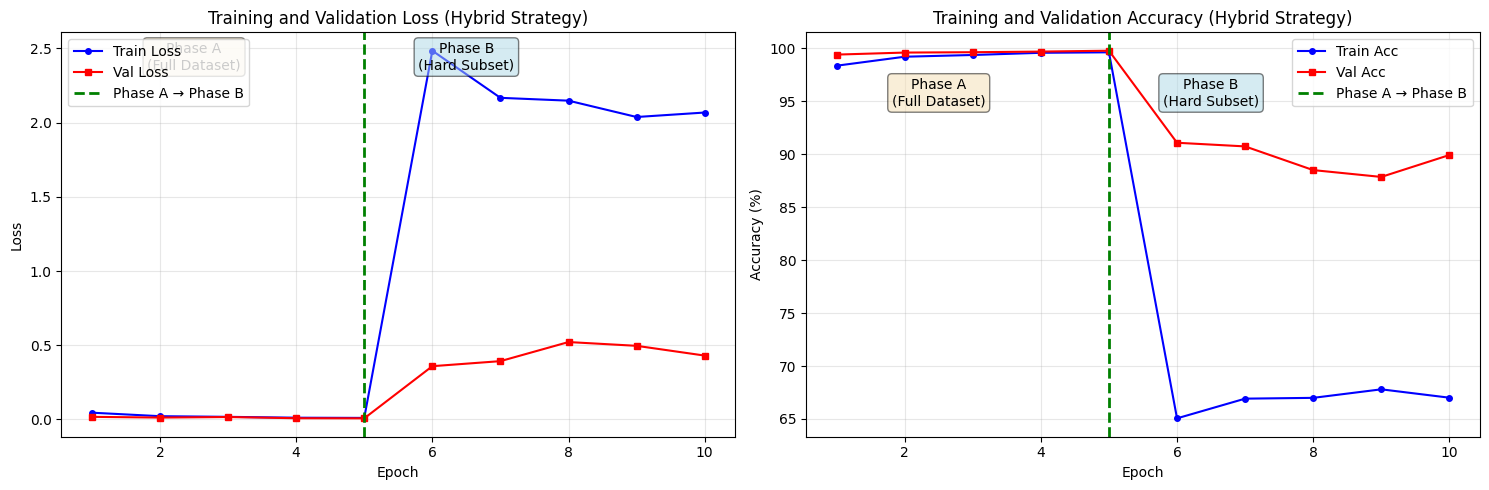

Training history plot saved to: /kaggle/working/models/Approach2_FineTuned_QuFeX_Fast/hybrid_training_history.png


In [ ]:
checkpoint_path = os.path.join(models_path, 'Approach2_FineTuned_QuFeX_Fast', 'QUFEX_FAST_latest.pth')

# Check if file exists and load it
if os.path.exists(checkpoint_path):
    print(f"Loading history from checkpoint: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    
    # Extract History
    if 'history' in checkpoint:
        recovered_history = checkpoint['history']
        print("History recovered successfully!")
        
        # Plot
        plot_dir = os.path.join(models_path, 'Approach2_FineTuned_QuFeX_Fast')
        plot_path = os.path.join(plot_dir, 'hybrid_training_history.png')
        
        plot_hybrid_training_history(recovered_history, plot_path)
    else:
        print("Error: Checkpoint exists but contains no history key.")
else:
    print(f"Error: Checkpoint not found at {checkpoint_path}")
    print("Check your /kaggle/working/models/ folder.")

#### **MAIN EXECUTION FOR VISUALIZATIONS**


MOUNTING GOOGLE DRIVE

MOUNTING GOOGLE DRIVE (KAGGLE):
Loading authentication token...
Testing connection...
Google Drive mounted successfully via OAuth!
Full read/write access enabled

Google Drive mounted successfully!
Will load hard-mined indices from Approach 1

SETTING UP PATHS
Data path: /kaggle/input/final-dataset/Final_Dataset
Models path: /kaggle/working/models
Drive folder: Deep Learning Semester Project

CHECKING HARD INDICES AVAILABILITY
  Found existing folder: Deep Learning Semester Project
  Found existing folder: models
  Found existing folder: Approach1_HardMining_VQC
 hard_indices.json FOUND in Drive
  File ID: 14FFTFjygvC8BedBAeEFeyxETDB_O1Vhm
  Ready to use for hybrid training!

CHECKING PHASE A STATUS
 Phase A COMPLETE (Epochs 1-5 done)
  Latest epoch: 10
  Best val acc: 99.78%
  Ready to start Phase B with hard-mining!

EXECUTING HYBRID HARD-MINING STRATEGY

HYBRID STRATEGY


Setting up Google Drive folders...
  Found existing folder: Deep Learning Semester Proje

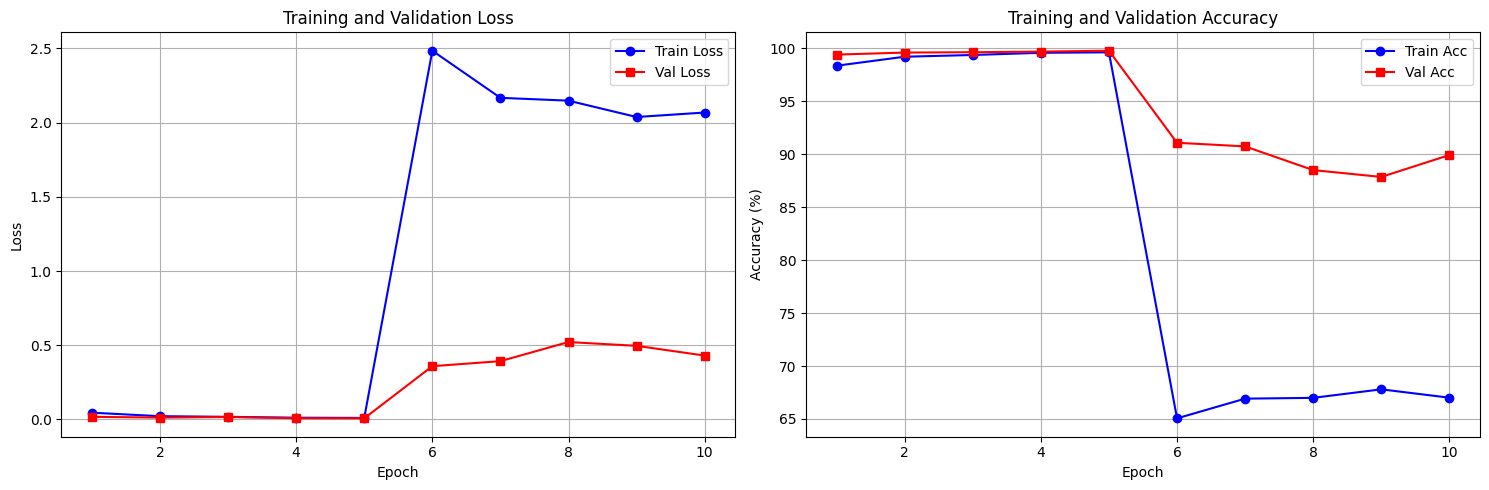

Training history plot saved to: /kaggle/working/models/Approach2_FineTuned_QuFeX_Fast/training_history.png
  Updated: training_history.png

EVALUATING Approach 2 (Fast QuFeX) ON TEST SET



Testing: 100%|██████████| 715/715 [27:31<00:00,  2.31s/it]



Results for Approach 2 (Fast QuFeX):
  Accuracy:  89.56%
  F1-Score:  92.14%


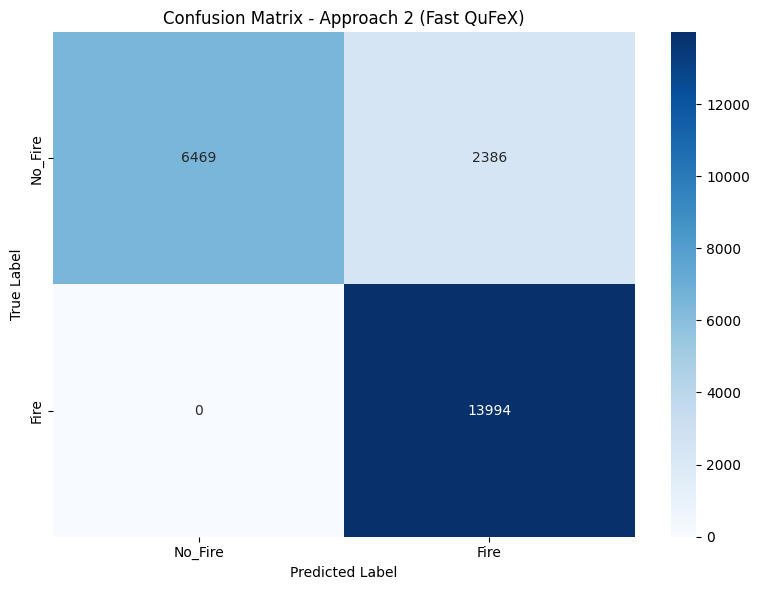

Confusion matrix saved to: /kaggle/working/models/Approach2_FineTuned_QuFeX_Fast/confusion_matrix.png


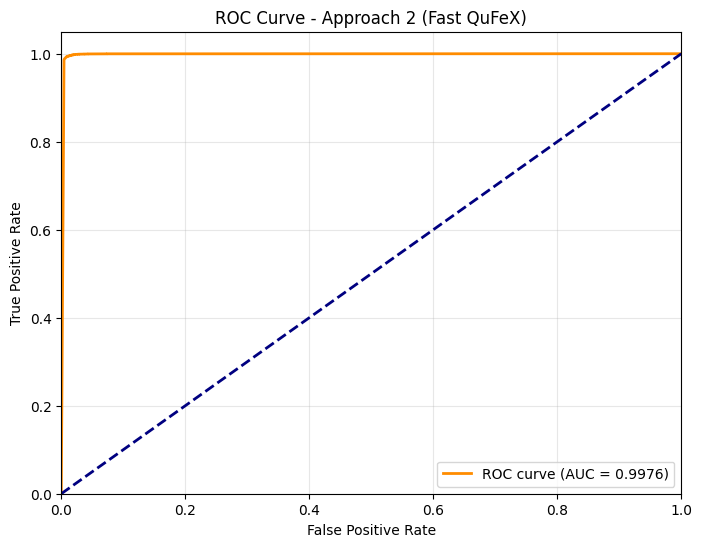

ROC curve saved to: /kaggle/working/models/Approach2_FineTuned_QuFeX_Fast/roc_curve.png

Uploading artifacts to Drive...
  Updated: confusion_matrix.png
  Updated: roc_curve.png
  Updated: evaluation_results.json
  Upload Complete!

HYBRID STRATEGY COMPLETE!
Final Test Accuracy: 89.56%


FINAL RESULTS SUMMARY

 TEST PERFORMANCE:
  Accuracy:  89.56%
  Precision: 85.43%
  Recall:    100.00%
  F1-Score:  92.14%

 CONFUSION MATRIX:
  True Negatives:  6,469
  False Positives: 2,386
  False Negatives: 0
  True Positives:  13,994

 SAVED LOCATIONS:
  Local: /kaggle/working/models/Approach2_FineTuned_QuFeX_Fast/
  Drive: Deep Learning Semester Project/models/Approach2_FineTuned_QuFeX_Fast/

HYBRID HARD-MINING TRAINING COMPLETE!


Results summary saved to: /kaggle/working/models/Approach2_FineTuned_QuFeX_Fast/final_results.json


In [ ]:
# MOUNT GOOGLE DRIVE

print("\n" + "="*70)
print("MOUNTING GOOGLE DRIVE")
print("="*70)

drive_service = mount_google_drive_kaggle()

if drive_service is None:
    print("\nWARNING: Google Drive not mounted!")
    print("Hard indices from Approach 1 won't be accessible.")
    print("Please ensure Drive is mounted to proceed.")
else:
    print("\nGoogle Drive mounted successfully!")
    print("Will load hard-mined indices from Approach 1")

# DEFINE PATHS

print("\n" + "="*70)
print("SETTING UP PATHS")
print("="*70)

data_path = '/kaggle/input/final-dataset/Final_Dataset'
models_path = '/kaggle/working/models'
drive_base_folder = 'Deep Learning Semester Project'

print(f"Data path: {data_path}")
print(f"Models path: {models_path}")
print(f"Drive folder: {drive_base_folder}")

# Create models directory
os.makedirs(models_path, exist_ok=True)

if drive_service:
    check_hard_indices_availability(drive_service, drive_base_folder)

# CHECK IF PHASE A IS COMPLETE

print("\n" + "="*70)
print("CHECKING PHASE A STATUS")
print("="*70)

# Check if Phase A checkpoint exists
phase_a_checkpoint = os.path.join(models_path, 
                                  'Approach2_FineTuned_QuFeX_Fast',
                                  'QUFEX_FAST_latest.pth')

if os.path.exists(phase_a_checkpoint):
    checkpoint = torch.load(phase_a_checkpoint, map_location='cpu')
    completed_epochs = checkpoint.get('epoch', 0)
    
    if completed_epochs >= 5:
        print(f" Phase A COMPLETE (Epochs 1-5 done)")
        print(f"  Latest epoch: {completed_epochs}")
        print(f"  Best val acc: {checkpoint.get('best_val_acc', 0):.2f}%")
        print(f"  Ready to start Phase B with hard-mining!")
    else:
        print(f"  Phase A INCOMPLETE")
        print(f"  Only {completed_epochs} epochs completed (need 5)")
        print(f"  Will complete Phase A first, then switch to hard-mining")
else:
    print("  Phase A NOT STARTED")
    print("  Will train Phase A on full dataset first")

# RUN HYBRID HARD-MINING STRATEGY

print("\n" + "="*70)
print("EXECUTING HYBRID HARD-MINING STRATEGY")
print("="*70)
    
# Run the hybrid hard-mining strategy
try:
    model, results = run_approach2_hybrid_hardmining(
        data_path=data_path,
        models_path=models_path,
        drive_service=drive_service,
        drive_base_folder=drive_base_folder,
        num_epochs=10,                    # 5 warmup + 5 finetune
        batch_size=32,
        learning_rate=0.001,
        grad_accumulation_steps=4,       
        resume_from='latest'             # Resume from epoch 5
)
        
# DISPLAY FINAL RESULTS
        
    print("\n" + "="*70)
    print("FINAL RESULTS SUMMARY")
    print("="*70)
        
    print(f"\n TEST PERFORMANCE:")
    print(f"  Accuracy:  {results['accuracy']*100:.2f}%")
    print(f"  Precision: {results['precision']*100:.2f}%")
    print(f"  Recall:    {results['recall']*100:.2f}%")
    print(f"  F1-Score:  {results['f1_score']*100:.2f}%")
        
    print(f"\n CONFUSION MATRIX:")
    cm = results['confusion_matrix']
    print(f"  True Negatives:  {cm[0][0]:,}")
    print(f"  False Positives: {cm[0][1]:,}")
    print(f"  False Negatives: {cm[1][0]:,}")
    print(f"  True Positives:  {cm[1][1]:,}")
        
    print(f"\n SAVED LOCATIONS:")
    print(f"  Local: {models_path}/Approach2_FineTuned_QuFeX_Fast/")
    print(f"  Drive: {drive_base_folder}/models/Approach2_FineTuned_QuFeX_Fast/")
        
    print("\n" + "="*70)
    print("HYBRID HARD-MINING TRAINING COMPLETE!")
    print("="*70 + "\n")
        
except Exception as e:
    print("\n" + "="*70)
    print("ERROR OCCURRED DURING TRAINING")
    print("="*70)
    print(f"\nError message: {str(e)}")
    print("\nTroubleshooting tips:")
    print("  1. Check if hard_indices.json exists in Approach 1 folder")
    print("  2. Verify Phase 0 (attention pre-computation) completed")
    print("  3. Ensure sufficient GPU memory available")
    print("  4. Check Drive permissions and folder structure")
    print("\nYou can resume training later using resume_from='latest'")
    print("="*70 + "\n")
    raise

# SAVE RESULTS TO JSON

if 'results' in locals():
    results_path = os.path.join(models_path, 
                                'Approach2_FineTuned_QuFeX_Fast',
                                'final_results.json')
    save_results_summary(results, results_path)